# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [7]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


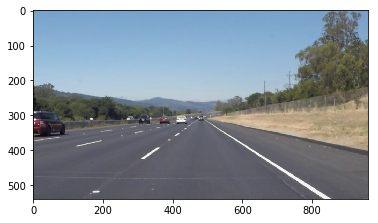

In [6]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [121]:
import math

threshold = 1000

def load_image(source_folder, file_name):
    s = "";
    sequence = (source_folder, file_name)
    fileFullPath = s.join(sequence)
    img = mpimg.imread(fileFullPath)
    return img

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, 255)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    global avg_pos_slope
    global avg_neg_slope
    global nFrames
    
    if lines is None:
        return;
    
    # lines is an array of <1,4> tuples
    num_line_segments = lines.shape
    slopes = [None]* num_line_segments[0]
    line_index=0
    for line in lines:
        for x1,y1,x2,y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            slopes[line_index] = (y2 - y1) / (x2 - x1);
        line_index+=1
    
    imshape = img.shape
    bottom_y = imshape[1]
    
    
    mean_negative_slope = compute_mean_slope(slopes, 1)
    print('avg_neg_slope(before) = ', avg_neg_slope)
    print('mean_negative_slope = ', mean_negative_slope)
    if ~np.isinf(mean_negative_slope) and ~np.isnan(mean_negative_slope):
        if avg_neg_slope != 0:
            avg_neg_slope = (mean_negative_slope + avg_neg_slope*nFrames)/(nFrames+1)
        else:
            avg_neg_slope = mean_negative_slope
    else:
        plt.imshow(img)
    print('avg_neg_slope = ', avg_neg_slope)
    if avg_neg_slope != 0:
        rlp1 = compute_highest_point(lines,1,avg_neg_slope)#[485, 300];
        rlp2 = compute_other_point(avg_neg_slope, rlp1, bottom_y)
        cv2.line(img, (rlp1[0], rlp1[1]), (int(rlp2[0]), int(rlp2[1])), color, 10)
        print('end-points = ', rlp1[0], rlp1[1], int(rlp2[0]), int(rlp2[1]))
    
    mean_positive_slope = compute_mean_slope(slopes, 0)
    print('avg_pos_slope(before) = ', avg_pos_slope)
    print('mean_positive_slope = ',mean_positive_slope)
    print('nFrames = ',nFrames)
    if ~np.isinf(mean_positive_slope) and ~np.isnan(mean_positive_slope):
        if avg_pos_slope != 0:
            avg_pos_slope = (mean_positive_slope + avg_pos_slope*nFrames)/(nFrames+1)
        else:
            avg_pos_slope = mean_positive_slope
    else:
        plt.imshow(img)
    print('avg_pos_slope = ', avg_pos_slope)
    if avg_pos_slope != 0:
        llp1 = compute_highest_point(lines,0,avg_pos_slope)#[485, 310];
        llp2 = compute_other_point(avg_pos_slope, llp1, bottom_y)
        cv2.line(img, (llp1[0], llp1[1]), (int(llp2[0]), int(llp2[1])), color, 10)
        print('end points = ', llp1[0], llp1[1], int(llp2[0]), int(llp2[1]))

def remove_noisy_slopes(slope_candidates):
    global threshold
    mean_slope = np.mean(slope_candidates)
    new_slope_candidates = []
    for slope in slope_candidates:
        if abs(slope - mean_slope) < threshold:
            new_slope_candidates.append(slope)
    return new_slope_candidates
    
def compute_mean_slope(slopes, is_slope_negative):
    num_line_segments = len(slopes)
    if is_slope_negative==1:
        slope_indices =  [i for i in range(num_line_segments) if slopes[i] < 0]
    else:
        slope_indices = [i for i in range(num_line_segments) if slopes[i] > 0]
    slope_candidates = [slopes[i] for i in slope_indices]
    slope_candidates = remove_noisy_slopes(slope_candidates)
    mean_slope = np.mean(slope_candidates)
    return mean_slope

def compute_highest_point(lines, is_slope_negative, mean_slope):
    global threshold
    highest_x = 0
    highest_y = 1000
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1) / (x2 - x1);
            if abs(slope - mean_slope) < threshold:
                if is_slope_negative and slope < 0:
                    if highest_y > y1:
                        highest_x = x1
                        highest_y = y1
                    if highest_y > y2:
                        highest_x = x2
                        highest_y = y2
            
            if abs(slope - mean_slope) < threshold:
                if not is_slope_negative and slope > 0:
                    if highest_y > y1:
                        highest_x = x1
                        highest_y = y1
                    if highest_y > y2:
                        highest_x = x2
                        highest_y = y2
    print('highest = ', [highest_x, highest_y])
    return [highest_x, highest_y]

def compute_other_point(slope, point, bottom_y):
    bias = point[1] - slope*point[0]
    bottom_x = (bottom_y - bias)/ slope;
    print('bottom = ',[bottom_x, bottom_y])
    return [bottom_x, bottom_y]
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [8]:
import os, sys
src_folder = "test_images/"
file_list = os.listdir(src_folder)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [83]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
i = 0
for file in file_list:
    
    img = load_image(src_folder, file)
    
    # Compute GrayScale of the  image
    gray = grayscale(img)
    
    # Compute guassian blur of the image
    kernel_size=5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # Compute canny edges pf the image
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Create masked edge image using region of interest
    imshape = image.shape
    vertices = np.array([[(0, imshape[0]), (450, 320), (490, 320), (imshape[1], imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 60 #minimum number of pixels making up a line
    max_line_gap = 60   # maximum gap in pixels between connectable line segments
    
    # Run hough on edge detected image and draw lines on image
    line_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Create a color binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))
    
    # Draw lines on edge image
    lane_overlayed_image = weighted_img(line_image, img)
    
    
    # save image in src_folder 
    s = "";
    new_file_name = s.join((src_folder, "modified_", file))
    mpimg.imsave(new_file_name, lane_overlayed_image)
    

NameError: name 'file_list' is not defined

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()

In [122]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # Compute GrayScale of the  image
    global nFrames
    
    nFrames = nFrames + 1
    
    gray = grayscale(image)
    
    # Compute guassian blur of the image
    kernel_size=5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # Compute canny edges pf the image
    low_threshold = 40
    high_threshold = 120
    edges = canny(blur_gray, low_threshold, high_threshold)
    
   # Create masked edge image using region of interest
    imshape = image.shape
    print(imshape)
    #vertices = np.array([[(50, imshape[0]-20), (imshape[1]/2-10, imshape[0]/2+40), (imshape[1]/2 + 10, imshape[0]/2+40), (imshape[1]-50, imshape[0]-20)]], dtype=np.int32)
    vertices = np.array([[(0, imshape[0]), (480, 310), 490, 310), (imshape[1], imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges, vertices)
    
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 100 #minimum number of pixels making up a line
    max_line_gap = 150   # maximum gap in pixels between connectable line segments
    # Run hough on edge detected image and draw lines on image
    line_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
    
    #plt.imshow(line_image)
    # Create a color binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))
    
    # Draw lines on edge image
    lane_overlayed_image = weighted_img(line_image, image)
    
    
    # save image in src_folder 
    #s = "";
    #new_file_name = s.join((src_folder, "modified_", file))
    #mpimg.imsave(new_file_name, lane_overlayed_image)
    plt.imshow(lane_overlayed_image)
    return lane_overlayed_image

SyntaxError: invalid syntax (<ipython-input-122-94aa8004afa9>, line 25)

Let's try the one with the solid white lane on the right first ...

(540, 960, 3)
avg_neg_slope(before) =  -0.670274971776
mean_negative_slope =  -0.732816817826
avg_neg_slope =  -0.701545894801
highest =  [474, 311]
bottom =  [-451.09984708028645, 960]
end-points =  474 311 -451 960
avg_pos_slope(before) =  0.570603667698
mean_positive_slope =  0.612251115811
nFrames =  1
avg_pos_slope =  0.591427391755
highest =  [486, 310]
bottom =  [1585.0360085819354, 960]
end points =  486 310 1585 960
[MoviePy] >>>> Building video test_videos/modified_solidWhiteRight.mp4
[MoviePy] Writing video test_videos/modified_solidWhiteRight.mp4



  0%|          | 0/222 [00:00<?, ?it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.701545894801
mean_negative_slope =  -0.732816817826
avg_neg_slope =  -0.711969535809
highest =  [474, 311]
bottom =  [-437.55585647692146, 960]
end-points =  474 311 -437 960
avg_pos_slope(before) =  0.591427391755
mean_positive_slope =  0.612251115811
nFrames =  2
avg_pos_slope =  0.598368633107
highest =  [486, 310]
bottom =  [1572.2868874411668, 960]
end points =  486 310 1572 960
(540, 960, 3)
avg_neg_slope(before) = 


  1%|          | 2/222 [00:00<00:12, 17.94it/s]

 -0.711969535809
mean_negative_slope =  -0.737307978175
avg_neg_slope =  -0.718304146401
highest =  [476, 310]
bottom =  [-428.90915757205011, 960]
end-points =  476 310 -428 960
avg_pos_slope(before) =  0.598368633107
mean_positive_slope =  0.629831105076
nFrames =  3
avg_pos_slope =  0.606234251099
highest =  [490, 310]
bottom =  [1562.1928014157484, 960]
end points =  490 310 1562 960
(540, 960, 3)
avg_neg_slope(before) =  -0.718304146401
mean_negative_slope =  -0.758970086665
avg_neg_slope =  -0.726437334454
highest =  [464, 313]
bottom =  [-426.64805636220729, 960]
end-points =  464 313 -426 960
avg_pos_slope(before) =  0.606234251099
mean_positive_slope =  0.611723876015
nFrames =  4
avg_pos_slope =  0.607332176082
highest =  [490, 310]
bottom =  [1560.2545091437869, 960]
end points =  490 310 1560 960
(540, 960, 3)
avg_neg_slope(before) =  -0.726437334454
mean_negative_slope =  -0.72724466945
avg_neg_slope =  -0.726571890286
highest =  [470, 310]
bottom =  [-424.6120937101976, 9


end points =  491 310 1558 960



  2%|▏         | 5/222 [00:00<00:11, 18.28it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.726571890286
mean_negative_slope =  -0.716330986716
avg_neg_slope =  -0.725108904062
highest =  [475, 311]
bottom =  [-420.03796790306274, 960]
end-points =  475 311 -420 960
avg_pos_slope(before) =  0.60884126084
mean_positive_slope =  0.58543224861
nFrames =  6
avg_pos_slope =  0.605497116236
highest =  [482, 310]
bottom =  [1555.4980936671627, 960]
end points =  482 310 1555 960
(540, 960, 3)


  3%|▎         | 7/222 [00:00<00:12, 17.84it/s]


avg_neg_slope(before) =  -0.725108904062
mean_negative_slope =  -0.713154040803
avg_neg_slope =  -0.723614546154
highest =  [470, 310]
bottom =  [-428.26828862727103, 960]
end-points =  470 310 -428 960
avg_pos_slope(before) =  0.605497116236
mean_positive_slope =  0.588080932622
nFrames =  7
avg_pos_slope =  0.603320093284
highest =  [487, 313]
bottom =  [1559.3992242297702, 960]
end points =  487 313 1559 960
(540, 960, 3)
avg_neg_slope(before) =  -0.723614546154
mean_negative_slope =  -0.712708828586
avg_neg_slope =  -0.722402799758
highest =  [474, 310]
bottom =  [-425.77502885887054, 960]
end-points =  474 310 -425 960
avg_pos_slope(before) =  0.603320093284
mean_positive_slope =  0.614113093965
nFrames =  8
avg_pos_slope =  0.604519315582
highest =  [491, 310]
bottom =  [1566.234460249409, 960]
end points =  491 310 1566 960
(540, 960, 3)
avg_neg_slope(before) =  -0.722402799758
mean_negative_slope =  -0.713311353659
avg_neg_slope =  -0.721493655148
highest =  [470, 310]
bottom 


  4%|▍         | 9/222 [00:00<00:11, 18.41it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.721493655148
mean_negative_slope =  -0.716133756521
avg_neg_slope =  -0.721006391636
highest =  [472, 312]
bottom =  [-426.74376637523841, 960]
end-points =  472 312 -426 960
avg_pos_slope(before) =  0.605518572874
mean_positive_slope =  0.609231522183
nFrames =  10
avg_pos_slope =  0.60585611372
highest =  [491, 310]
bottom =  [1563.8619969002641, 960]
end points =  491 310 1563 960



  5%|▍         | 11/222 [00:00<00:11, 18.79it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.721006391636
mean_negative_slope =  -0.710434389857
avg_neg_slope =  -0.720125391488
highest =  [478, 311]
bottom =  [-423.2319349811907, 960]
end-points =  478 311 -423 960
avg_pos_slope(before) =  0.60585611372
mean_positive_slope =  0.580991300465
nFrames =  11
avg_pos_slope =  0.603784045949
highest =  [478, 310]
bottom =  [1554.5438476905679, 960]
end points =  478 310 1554 960
(540, 960, 3)
avg_neg_slope(before) =  -0.720125391488
mean_negative_slope =  -0.732518908232
avg_neg_slope =  -0.72107873893
highest =  [473, 310]
bottom =  [-428.42721579128334, 960]
end-points =  473 310 -428 960
avg_pos_slope(before) =  0.603784045949
mean_positive_slope =  0.611190272672
nFrames =  12
avg_pos_slope =  0.604353755697
highest =  [482, 310]
bottom =  [1557.5290157013612, 960]
end points =  482 310 1557 960
(540, 960, 3)
avg_neg_slope(before) =  -0.72107873893
mean_negative_slope =  -0.717417775524
avg_neg_slope =  -0.720817241544
highest =  [477, 

avg_neg_slope(before) =  -0.720817241544
mean_negative_slope =  -0.731093791283
avg_neg_slope =  -0.72150234486
highest =  [477, 310]
bottom =  [-423.89797300138815, 960]
end-points =  477 310 -423 960
avg_pos_slope(before) =  0.605819808933
mean_positive_slope =  0.633863554367
nFrames =  14
avg_pos_slope =  0.607689391962
highest =  [482, 310]
bottom =  [1551.6253852664724, 960]
end points =  482 310 1551 960
(540, 960, 3)
avg_neg_slope(before) =  


  6%|▋         | 14/222 [00:00<00:10, 19.15it/s]

-0.72150234486
mean_negative_slope =  -0.709176768865
avg_neg_slope =  -0.72073199636
highest =  [470, 310]
bottom =  [-431.86089043168477, 960]
end-points =  470 310 -431 960
avg_pos_slope(before) =  0.607689391962
mean_positive_slope =  0.641944565559
nFrames =  15
avg_pos_slope =  0.609830340312
highest =  [482, 310]
bottom =  [1547.8702216543941, 960]
end points =  482 310 1547 960
(540, 960, 3)
avg_neg_slope(before) =  -0.72073199636
mean_negative_slope =  -0.719361959837
avg_neg_slope =  -0.720651405976
highest =  [474, 311]
bottom =  [-426.57411200169003, 960]
end-points =  474 311 -426 960
avg_pos_slope(before) =  0.609830340312
mean_positive_slope =  0.640303245563
nFrames =  16
avg_pos_slope =  0.61162286415
highest =  [487, 310]
bottom =  [1549.7464048502297, 960]
end points =  487 310 1549 960
(540, 960, 3)
avg_neg_slope(before) =  -0.720651405976
mean_negative_slope =  -0.71598453632
avg_neg_slope =  -0.72039213544
highest =  [470, 311]
bottom =  [-430.89823038344059, 960]


  8%|▊         | 17/222 [00:00<00:10, 19.94it/s]

 [490, 310]
bottom =  [1546.960117788796, 960]
end points =  490 310 1546 960
(540, 960, 3)
avg_neg_slope(before) =  -0.718298852441
mean_negative_slope =  -0.673136427697
avg_neg_slope =  -0.716040731203
highest =  [473, 310]
bottom =  [-434.76958862049145, 960]
end-points =  473 310 -434 960
avg_pos_slope(before) =  0.614971169735
mean_positive_slope =  0.637815748129
nFrames =  19
avg_pos_slope =  0.616113398655
highest =  [491, 310]
bottom =  [1546.0005914805745, 960]
end points =  491 310 1546 960



  9%|▉         | 20/222 [00:01<00:09, 20.37it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.716040731203
mean_negative_slope =  -0.708425286465
avg_neg_slope =  -0.715678090978
highest =  [472, 310]
bottom =  [-436.22956325515986, 960]
end-points =  472 310 -436 960
avg_pos_slope(before) =  0.616113398655
mean_positive_slope =  0.63647061126
nFrames =  20
avg_pos_slope =  0.617082789731
highest =  [487, 310]
bottom =  [1540.343264172089, 960]
end points =  487 310 1540 960
(540, 960, 3)
avg_neg_slope(before) =  -0.715678090978
mean_negative_slope =  -0.682131712861
avg_neg_slope =  -0.714153255609
highest =  [476, 310]
bottom =  [-434.16878365397122, 960]
end-points =  476 310 -434 960
avg_pos_slope(before) =  0.617082789731
mean_positive_slope =  0.641591123268
nFrames =  21
avg_pos_slope =  0.618196804892
highest =  [484, 310]
bottom =  [1535.4450978333196, 960]
end points =  484 310 1535 960
(540, 960, 3)
avg_neg_slope(before) =  -0.714153255609
mean_negative_slope =  -0.709206052588
avg_neg_slope =  -0.713938159825
highest =  [476


 12%|█▏        | 26/222 [00:01<00:09, 21.13it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.714267145812
mean_negative_slope =  -0.714192492804
avg_neg_slope =  -0.714264274542
highest =  [478, 310]
bottom =  [-432.02731505275051, 960]
end-points =  478 310 -432 960
avg_pos_slope(before) =  0.620790570881
mean_positive_slope =  0.637768278427
nFrames =  25
avg_pos_slope =  0.621443559633
highest =  [485, 310]
bottom =  [1530.9517842365342, 960]
end points =  485 310 1530 960
(540, 960, 3)
avg_neg_slope(before) =  -0.714264274542
mean_negative_slope =  -0.715549772857
avg_neg_slope =  -0.714311885591
highest =  [470, 310]
bottom =  [-439.96665897843837, 960]
end-points =  470 310 -439 960
avg_pos_slope(before) =  0.621443559633
mean_positive_slope =  0.637990556166
nFrames =  26
avg_pos_slope =  0.622056411356
highest =  [487, 310]
bottom =  [1531.9213096012395, 960]
end points =  487 310 1531 960
(540, 960, 3)
avg_neg_slope(before) =  -0.714311885591
mean_negative_slope =  -0.7115890583
avg_neg_slope =  -0.714214641759
highest =  [477

(540, 960, 3)
avg_neg_slope(before) =  -0.714242173177
mean_negative_slope =  -0.703428814391
avg_neg_slope =  -0.713881727885
highest =  [470, 310]
bottom =  [-440.51496993229938, 960]
end-points =  470 310 -440 960
avg_pos_slope(before) =  0.623132311828
mean_positive_slope =  0.6370636197
nFrames =  29
avg_pos_slope =  0.623596688757



 13%|█▎        | 29/222 [00:01<00:09, 21.12it/s]

highest =  [484, 310]
bottom =  [1526.3403647242985, 960]
end points =  484 310 1526 960
(540, 960, 3)
avg_neg_slope(before) =  -0.713881727885
mean_negative_slope =  -0.735181715742
avg_neg_slope =  -0.714568824267
highest =  [470, 310]
bottom =  [-439.63946078493984, 960]
end-points =  470 310 -439 960
avg_pos_slope(before) =  0.623596688757
mean_positive_slope =  0.639538133877
nFrames =  30
avg_pos_slope =  0.624110928922
highest =  [485, 310]
bottom =  [1526.4815217582943, 960]
end points =  485 310 1526 960
(540, 960, 3)
avg_neg_slope(before) =  -0.714568824267
mean_negative_slope =  -0.746600276184
avg_neg_slope =  -0.715569807139
highest =  [477, 310]
bottom =  [-431.36700139492041, 960]
end-points =  477 310 -431 960
avg_pos_slope(before) =  0.624110928922
mean_positive_slope =  0.636277346927
nFrames =  31
avg_pos_slope =  0.624491129485
highest =  [489, 310]
bottom =  [1529.8474505251295, 960]
end points =  489 310 1529 960
(540, 960, 3)
avg_neg_slope(before) =  -0.715569807


 14%|█▍        | 32/222 [00:01<00:08, 21.29it/s]


avg_pos_slope(before) =  0.624686215762
mean_positive_slope =  0.633799685591
nFrames =  33
avg_pos_slope =  0.624954258992
highest =  [488, 310]
bottom =  [1528.076118608109, 960]
end points =  488 310 1528 960
(540, 960, 3)
avg_neg_slope(before) =  -0.715467933633
mean_negative_slope =  -0.703405616866
avg_neg_slope =  -0.715123296011
highest =  [474, 310]
bottom =  [-434.93417068887845, 960]
end-points =  474 310 -434 960
avg_pos_slope(before) =  0.624954258992
mean_positive_slope =  0.633782632291
nFrames =  34
avg_pos_slope =  0.625206498229
highest =  [489, 310]



 16%|█▌        | 35/222 [00:01<00:08, 21.53it/s]

bottom =  [1528.6565004380654, 960]
end points =  489 310 1528 960
(540, 960, 3)
avg_neg_slope(before) =  -0.715123296011
mean_negative_slope =  -0.718121882042
avg_neg_slope =  -0.715206590067
highest =  [474, 311]
bottom =  [-433.43011741387733, 960]
end-points =  474 311 -433 960
avg_pos_slope(before) =  0.625206498229
mean_positive_slope =  0.647959377301
nFrames =  35
avg_pos_slope =  0.625838522648
highest =  [488, 310]
bottom =  [1526.6065677932731, 960]
end points =  488 310 1526 960
(540, 960, 3)
avg_neg_slope(before) =  -0.715206590067
mean_negative_slope =  -0.722283791935
avg_neg_slope =  -0.715397865794
highest =  [471, 310]
bottom =  [-437.58532165037809, 960]
end-points =  471 310 -437 960
avg_pos_slope(before) =  0.625838522648
mean_positive_slope =  0.635049471353
nFrames =  36
avg_pos_slope =  0.626087467207
highest =  [483, 310]
bottom =  [1521.1935976123341, 960]
end points =  483 310 1521 960
(540, 960, 3)
avg_neg_slope(before) =  -0.715397865794
mean_negative_slop


 18%|█▊        | 41/222 [00:01<00:08, 21.56it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.715329278704
mean_negative_slope =  -0.717319290033
avg_neg_slope =  -0.715377815566
highest =  [471, 310]
bottom =  [-437.61078699521926, 960]
end-points =  471 310 -437 960
avg_pos_slope(before) =  0.627124053541
mean_positive_slope =  0.647362409947
nFrames =  40
avg_pos_slope =  0.62761767199
highest =  [488, 310]
bottom =  [1523.6623610345177, 960]
end points =  488 310 1523 960
(540, 960, 3)
avg_neg_slope(before) =  -0.715377815566
mean_negative_slope =  -0.71607797302
avg_neg_slope =  -0.715394485981
highest =  [470, 310]
bottom =  [-438.58961417418504, 960]
end-points =  470 310 -438 960
avg_pos_slope(before) =  0.62761767199
mean_positive_slope =  0.633474800175
nFrames =  41
avg_pos_slope =  0.627757127423
highest =  [488, 310]
bottom =  [1523.4322899820861, 960]
end points =  488 310 1523 960
(540, 960, 3)
avg_neg_slope(before) =  -0.715394485981
mean_negative_slope =  -0.717562124855
avg_neg_slope =  -0.715444896188
highest =  [474,

 0.627998403325
mean_positive_slope =  0.627083114298
nFrames =  43
avg_pos_slope =  0.627977601301
highest =  [490, 310]
bottom =  [1525.0687646392084, 960]
end points =  490 310 1525 960
(540, 960, 3)
avg_neg_slope(before) =  -0.715235811314
mean_negative_slope =  -0.700373535424
avg_neg_slope =  -0.714905538517
highest =  [474, 310]
bottom =  [-435.21102856259733, 960]
end-points =  474 310 -435 960
avg_pos_slope(before) =  0.627977601301
mean_positive_slope =  0.638101247962
nFrames =  44
avg_pos_slope =  0.628202571227
highest =  [490, 310]
bottom =  [1524.6980890739767, 960]
end points =  490 310 1524 960



 20%|█▉        | 44/222 [00:02<00:08, 21.36it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.714905538517
mean_negative_slope =  -0.696729128292
avg_neg_slope =  -0.714510399164
highest =  [474, 310]
bottom =  [-435.71384147859567, 960]
end-points =  474 310 -435 960
avg_pos_slope(before) =  0.628202571227
mean_positive_slope =  0.65897720044
nFrames =  45
avg_pos_slope =  0.628871584906
highest =  [490, 310]
bottom =  [1523.597344197985, 960]
end points =  490 310 1523 960
(540, 960, 3)
avg_neg_slope(before) =  -0.714510399164
mean_negative_slope =  -0.719019392327
avg_neg_slope =  -0.714606335189
highest =  [470, 312]



 21%|██        | 47/222 [00:02<00:12, 14.50it/s]

bottom =  [-436.79296850725473, 960]
end-points =  470 312 -436 960
avg_pos_slope(before) =  0.628871584906
mean_positive_slope =  0.65722086664
nFrames =  46
avg_pos_slope =  0.629474761113
highest =  [489, 310]
bottom =  [1521.6069290705384, 960]
end points =  489 310 1521 960
(540, 960, 3)
avg_neg_slope(before) =  -0.714606335189
mean_negative_slope =  -0.721788683126
avg_neg_slope =  -0.714755967438
highest =  [473, 310]
bottom =  [-436.40129164684379, 960]
end-points =  473 310 -436 960
avg_pos_slope(before) =  0.629474761113
mean_positive_slope =  0.659405869974
nFrames =  47
avg_pos_slope =  0.630098325881
highest =  [495, 313]
bottom =  [1521.8238676808439, 960]
end points =  495 313 1521 960
(540, 960, 3)
avg_neg_slope(before) =  -0.714755967438
mean_negative_slope =  -0.713893848232
avg_neg_slope =  -0.714738373168
highest =  [473, 310]
bottom =  [-436.42367781219264, 960]
end-points =  473 310 -436 960
avg_pos_slope(before) =  0.630098325881
mean_positive_slope =  0.64471926


 23%|██▎       | 51/222 [00:02<00:10, 15.68it/s]


highest =  [495, 314]
bottom =  [1517.9620827358071, 960]
end points =  495 314 1517 960
(540, 960, 3)
avg_neg_slope(before) =  -0.715458882218
mean_negative_slope =  -0.717019844939
avg_neg_slope =  -0.715488900732
highest =  [471, 310]
bottom =  [-437.46971816748095, 960]
end-points =  471 310 -437 960
avg_pos_slope(before) =  0.631499457216
mean_positive_slope =  0.642642155325
nFrames =  51
avg_pos_slope =  0.631713739872
highest =  [488, 310]
bottom =  [1516.947067277604, 960]
end points =  488 310 1516 960
(540, 960, 3)
avg_neg_slope(before) =  -0.715488900732
mean_negative_slope =  -0.710234166237
avg_neg_slope =  -0.715389754798
highest =  [471, 310]
bottom =  [-437.59562307175787, 960]
end-points =  471 310 -437 960
avg_pos_slope(before) =  0.631713739872
mean_positive_slope =  0.64167141056
nFrames =  52
avg_pos_slope =  0.631901620451
highest =  [487, 310]
bottom =  [1515.6411348911015, 960]
end points =  487 310 1515 960
(540, 960, 3)
avg_neg_slope(before) =  -0.7153897547


 26%|██▌       | 57/222 [00:03<00:09, 16.79it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.71462977082
mean_negative_slope =  -0.681208422929
avg_neg_slope =  -0.714032961036
highest =  [471, 310]
bottom =  [-439.32212162390908, 960]
end-points =  471 310 -439 960
avg_pos_slope(before) =  0.632109077529
mean_positive_slope =  0.653952200601
nFrames =  55
avg_pos_slope =  0.632499133298
highest =  [491, 310]
bottom =  [1518.6693923845469, 960]
end points =  491 310 1518 960
(540, 960, 3)
avg_neg_slope(before) =  -0.714032961036
mean_negative_slope =  -0.662627779401
avg_neg_slope =  -0.713131115744
highest =  [471, 310]
bottom =  [-440.47334010438828, 960]
end-points =  471 310 -440 960
avg_pos_slope(before) =  0.632499133298
mean_positive_slope =  0.637923995316
nFrames =  56
avg_pos_slope =  0.632594306316
highest =  [491, 310]
bottom =  [1518.514780816824, 960]
end points =  491 310 1518 960
(540, 960, 3)
avg_neg_slope(before) =  -0.713131115744
mean_negative_slope =  -0.686615218423
avg_neg_slope =  -0.712673945101
highest =  [475


 27%|██▋       | 59/222 [00:03<00:09, 16.72it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.712373926459
mean_negative_slope =  -0.677224833347
avg_neg_slope =  -0.711788108241
highest =  [473, 310]
bottom =  [-440.1931153032852, 960]
end-points =  473 310 -440 960
avg_pos_slope(before) =  0.632691481662
mean_positive_slope =  0.633390817215
nFrames =  59
avg_pos_slope =  0.632703137255
highest =  [490, 311]
bottom =  [1515.7575184719467, 960]
end points =  490 311 1515 960
(540, 960, 3)
avg_neg_slope(before) =  -0.711788108241
mean_negative_slope =  -0.692521415808
avg_neg_slope =  -0.711472260824
highest =  [477, 310]
bottom =  [-436.59851366174706, 960]
end-points =  477 310 -436 960
avg_pos_slope(before) =  0.632703137255
mean_positive_slope =  0.649173149456
nFrames =  60
avg_pos_slope =  0.632973137455
highest =  [493, 313]
bottom =  [1515.1602809267483, 960]
end points =  493 313 1515 960
(540, 960, 3)
avg_neg_slope(before) =  -0.711472260824
mean_negative_slope =  -0.686676703796
avg_neg_slope =  -0.711072332484
highest =  [47


 28%|██▊       | 63/222 [00:03<00:09, 16.97it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.710418443759
mean_negative_slope =  -0.682880138074
avg_neg_slope =  -0.709988157733
highest =  [473, 310]
bottom =  [-442.50822773658763, 960]
end-points =  473 310 -442 960
avg_pos_slope(before) =  0.633726003929
mean_positive_slope =  0.658892111754
nFrames =  63
avg_pos_slope =  0.634119224364
highest =  [492, 312]
bottom =  [1513.8898514703178, 960]
end points =  492 312 1513 960
(540, 960, 3)
avg_neg_slope(before) =  -0.709988157733
mean_negative_slope =  -0.687340812467
avg_neg_slope =  -0.709639737036
highest =  [472, 310]
bottom =  [-443.95772626044607, 960]
end-points =  472 310 -443 960
avg_pos_slope(before) =  0.634119224364
mean_positive_slope =  0.65912880131
nFrames =  64
avg_pos_slope =  0.634503987086
highest =  [491, 312]
bottom =  [1512.2701782624454, 960]
end points =  491 312 1512 960
(540, 960, 3)
avg_neg_slope(before) =  -0.709639737036
mean_negative_slope =  -0.671234134295
avg_neg_slope =  -0.709057833965
highest =  [47


 31%|███       | 69/222 [00:03<00:08, 17.67it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.708526133694
mean_negative_slope =  -0.65327478412
avg_neg_slope =  -0.707713613847
highest =  [473, 310]
bottom =  [-445.45060951516655, 960]
end-points =  473 310 -445 960
avg_pos_slope(before) =  0.634850859511
mean_positive_slope =  0.658177493326
nFrames =  67
avg_pos_slope =  0.635193898243
highest =  [484, 311]
bottom =  [1505.7352556361623, 960]
end points =  484 311 1505 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707713613847
mean_negative_slope =  -0.688681883756
avg_neg_slope =  -0.707437791672
highest =  [473, 310]
bottom =  [-445.80870325561398, 960]
end-points =  473 310 -445 960
avg_pos_slope(before) =  0.635193898243
mean_positive_slope =  0.657279582255
nFrames =  68
avg_pos_slope =  0.63551398062
highest =  [484, 310]
bottom =  [1506.7941789191252, 960]
end points =  484 310 1506 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707437791672
mean_negative_slope =  -0.682397989515
avg_neg_slope =  -0.707080080212
highest =  [475


 32%|███▏      | 71/222 [00:03<00:08, 17.56it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.706524804146
mean_negative_slope =  -0.673328568044
avg_neg_slope =  -0.706063745312
highest =  [478, 310]
bottom =  [-442.59676525814376, 960]
end-points =  478 310 -442 960
avg_pos_slope(before) =  0.636179184865
mean_positive_slope =  0.65460049768
nFrames =  71
avg_pos_slope =  0.636435036432
highest =  [483, 310]
bottom =  [1504.3139798908521, 960]
end points =  483 310 1504 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706063745312
mean_negative_slope =  -0.687758620131
avg_neg_slope =  -0.705812990172
highest =  [470, 311]
bottom =  [-449.50702103346458, 960]
end-points =  470 311 -449 960
avg_pos_slope(before) =  0.636435036432
mean_positive_slope =  0.656496094153
nFrames =  72
avg_pos_slope =  0.636709845442
highest =  [482, 310]
bottom =  [1502.8731726917676, 960]
end points =  482 310 1502 960
(540, 960, 3)
avg_neg_slope(before) =  -0.705812990172
mean_negative_slope =  -0.64869636679
avg_neg_slope =  -0.70504114391
highest =  [477,


 35%|███▍      | 77/222 [00:04<00:07, 18.14it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.704875525811
mean_negative_slope =  -0.700269230325
avg_neg_slope =  -0.70481491666
highest =  [473, 310]
bottom =  [-449.22792769521749, 960]
end-points =  473 310 -449 960
avg_pos_slope(before) =  0.637178501433
mean_positive_slope =  0.65610006981
nFrames =  75
avg_pos_slope =  0.637427469438
highest =  [482, 310]
bottom =  [1501.7238606185538, 960]
end points =  482 310 1501 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70481491666
mean_negative_slope =  -0.670471374596
avg_neg_slope =  -0.704368896633
highest =  [473, 310]
bottom =  [-449.81190027975771, 960]
end-points =  473 310 -449 960
avg_pos_slope(before) =  0.637427469438
mean_positive_slope =  0.65820081991
nFrames =  76
avg_pos_slope =  0.637697253211
highest =  [480, 310]
bottom =  [1499.29245692581, 960]
end points =  480 310 1499 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704368896633
mean_negative_slope =  -0.681243139315
avg_neg_slope =  -0.704072412565
highest =  [474, 31


 36%|███▌      | 79/222 [00:04<00:08, 17.67it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.703754632747
mean_negative_slope =  -0.652307332262
avg_neg_slope =  -0.703111541491
highest =  [466, 314]
bottom =  [-452.77314178332449, 960]
end-points =  466 314 -452 960
avg_pos_slope(before) =  0.638524520235
mean_positive_slope =  0.678188553566
nFrames =  79
avg_pos_slope =  0.639020320652
highest =  [485, 310]
bottom =  [1502.1820503881456, 960]
end points =  485 310 1502 960
(540, 960, 3)
avg_neg_slope(before) =  -0.703111541491
mean_negative_slope =  -0.685799504399
avg_neg_slope =  -0.702897812638
highest =  [474, 310]
bottom =  [-450.74323907812527, 960]
end-points =  474 310 -450 960
avg_pos_slope(before) =  0.639020320652
mean_positive_slope =  0.664046012399
nFrames =  80
avg_pos_slope =  0.639329279809
highest =  [485, 310]
bottom =  [1501.6904919391341, 960]
end points =  485 310 1501 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702897812638
mean_negative_slope =  -0.64867143244
avg_neg_slope =  -0.702236515319
highest =  [47


 38%|███▊      | 85/222 [00:04<00:07, 17.60it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.701676197307
mean_negative_slope =  -0.664227622938
avg_neg_slope =  -0.701230380946
highest =  [474, 310]
bottom =  [-452.94215433630131, 960]
end-points =  474 310 -452 960
avg_pos_slope(before) =  0.640493137821
mean_positive_slope =  0.684981215057
nFrames =  83
avg_pos_slope =  0.641022757789
highest =  [484, 310]
bottom =  [1498.0045608403227, 960]
end points =  484 310 1498 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701230380946
mean_negative_slope =  -0.658972639058
avg_neg_slope =  -0.700733231041
highest =  [473, 310]
bottom =  [-454.59979291136744, 960]
end-points =  473 310 -454 960
avg_pos_slope(before) =  0.641022757789
mean_positive_slope =  0.693834351419
nFrames =  84
avg_pos_slope =  0.641644070655
highest =  [490, 310]
bottom =  [1503.0226861392396, 960]
end points =  490 310 1503 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700733231041
mean_negative_slope =  -0.662810388815
avg_neg_slope =  -0.70029226776
highest =  [47


 39%|███▉      | 87/222 [00:04<00:07, 16.92it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.699878092161
mean_negative_slope =  -0.660127409471
avg_neg_slope =  -0.699426379857
highest =  [475, 310]
bottom =  [-454.3329773071755, 960]
end-points =  475 310 -454 960
avg_pos_slope(before) =  0.642547281437
mean_positive_slope =  0.671958435594
nFrames =  87
avg_pos_slope =  0.642881499098
highest =  [482, 310]
bottom =  [1493.0728041051132, 960]
end points =  482 310 1493 960
(540, 960, 3)
avg_neg_slope(before) =  -0.699426379857
mean_negative_slope =  -0.66132018316
avg_neg_slope =  -0.698998220344
highest =  [474, 310]
bottom =  [-455.90222447235675, 960]
end-points =  474 310 -455 960
avg_pos_slope(before) =  0.642881499098
mean_positive_slope =  0.684276187139
nFrames =  88
avg_pos_slope =  0.643346607952
highest =  [484, 310]
bottom =  [1494.3418467831741, 960]
end points =  484 310 1494 960
(540, 960, 3)
avg_neg_slope(before) =  -0.698998220344
mean_negative_slope =  -0.65923165253
avg_neg_slope =  -0.69855636959
highest =  [481, 


 41%|████      | 91/222 [00:05<00:07, 16.99it/s]

960
(540, 960, 3)
avg_neg_slope(before) =  -0.698008530354
mean_negative_slope =  -0.660764562043
avg_neg_slope =  -0.697603704611
highest =  [474, 310]
bottom =  [-457.76110692015806, 960]
end-points =  474 310 -457 960
avg_pos_slope(before) =  0.64428125941
mean_positive_slope =  0.685586202267
nFrames =  91
avg_pos_slope =  0.64473022618
highest =  [484, 310]
bottom =  [1492.1736106140022, 960]
end points =  484 310 1492 960
(540, 960, 3)
avg_neg_slope(before) =  -0.697603704611
mean_negative_slope =  -0.661941167276
avg_neg_slope =  -0.697220236468
highest =  [477, 310]
bottom =  [-455.27357153759175, 960]
end-points =  477 310 -455 960
avg_pos_slope(before) =  0.64473022618
mean_positive_slope =  0.709173377391
nFrames =  92
avg_pos_slope =  0.64542316329
highest =  [487, 310]
bottom =  [1494.0912185530417, 960]
end points =  487 310 1494 960
(540, 960, 3)
avg_neg_slope(before) =  -0.697220236468
mean_negative_slope =  -0.656052833436
avg_neg_slope =  -0.696782285372
highest =  [4


 43%|████▎     | 95/222 [00:05<00:07, 17.38it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.696416498855
mean_negative_slope =  -0.648225354535
avg_neg_slope =  -0.695914507768
highest =  [479, 310]
bottom =  [-455.02277541915879, 960]
end-points =  479 310 -455 960
avg_pos_slope(before) =  0.646813635143
mean_positive_slope =  0.702944106659
nFrames =  95
avg_pos_slope =  0.647398327554
highest =  [491, 311]
bottom =  [1493.4740138758045, 960]
end points =  491 311 1493 960
(540, 960, 3)
avg_neg_slope(before) =  -0.695914507768
mean_negative_slope =  -0.662917315312
avg_neg_slope =  -0.695574330526
highest =  [478, 310]
bottom =  [-456.47956814078515, 960]
end-points =  478 310 -456 960
avg_pos_slope(before) =  0.647398327554
mean_positive_slope =  0.679859448189
nFrames =  96
avg_pos_slope =  0.647732978283
highest =  [485, 310]
bottom =  [1488.4999325236799, 960]
end points =  485 310 1488 960
(540, 960, 3)
avg_neg_slope(before) =  -0.695574330526
mean_negative_slope =  -0.66480694394
avg_neg_slope =  -0.695260377602
highest =  [47


 45%|████▍     | 99/222 [00:05<00:07, 17.50it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.694829744089
mean_negative_slope =  -0.666324488754
avg_neg_slope =  -0.694544691536
highest =  [475, 310]
bottom =  [-460.86490246251537, 960]
end-points =  475 310 -460 960
avg_pos_slope(before) =  0.648337265338
mean_positive_slope =  0.706009229119
nFrames =  99
avg_pos_slope =  0.648913984976
highest =  [498, 314]
bottom =  [1493.5094434035339, 960]
end points =  498 314 1493 960
(540, 960, 3)
avg_neg_slope(before) =  -0.694544691536
mean_negative_slope =  -0.661745150803
avg_neg_slope =  -0.694219943608
highest =  [470, 310]
bottom =  [-466.30268906142123, 960]
end-points =  470 310 -466 960
avg_pos_slope(before) =  0.648913984976
mean_positive_slope =  0.70573624614
nFrames =  100
avg_pos_slope =  0.649476581621
highest =  [505, 318]
bottom =  [1493.4882968338818, 960]
end points =  505 318 1493 960
(540, 960, 3)
avg_neg_slope(before) =  -0.694219943608
mean_negative_slope =  -0.649038040975
avg_neg_slope =  -0.693776983778
highest =  [4


 46%|████▋     | 103/222 [00:05<00:06, 17.40it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.693351272439
mean_negative_slope =  -0.673899515569
avg_neg_slope =  -0.693164236315
highest =  [478, 310]
bottom =  [-459.72870258729523, 960]
end-points =  478 310 -459 960
avg_pos_slope(before) =  0.65051998744
mean_positive_slope =  0.701399183149
nFrames =  103
avg_pos_slope =  0.651009210476
highest =  [490, 314]
bottom =  [1482.3054691163936, 960]
end points =  490 314 1482 960
(540, 960, 3)
avg_neg_slope(before) =  -0.693164236315
mean_negative_slope =  -0.659197136373
avg_neg_slope =  -0.692840740126
highest =  [485, 310]
bottom =  [-453.1665400943977, 960]
end-points =  485 310 -453 960
avg_pos_slope(before) =  0.651009210476
mean_positive_slope =  0.684684980883
nFrames =  104
avg_pos_slope =  0.651329932098
highest =  [487, 310]
bottom =  [1484.9581283879218, 960]
end points =  487 310 1484 960
(540, 960, 3)
avg_neg_slope(before) =  -0.692840740126
mean_negative_slope =  -0.645376450732
avg_neg_slope =  -0.69239296381
highest =  [48


 49%|████▉     | 109/222 [00:06<00:06, 17.62it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.692165013456
mean_negative_slope =  -0.671178042445
avg_neg_slope =  -0.691970689651
highest =  [478, 310]
bottom =  [-461.34614532327572, 960]
end-points =  478 310 -461 960
avg_pos_slope(before) =  0.652045644623
mean_positive_slope =  0.689920384712
nFrames =  107
avg_pos_slope =  0.652396336661
highest =  [489, 310]
bottom =  [1485.3268698388063, 960]
end points =  489 310 1485 960
(540, 960, 3)
avg_neg_slope(before) =  -0.691970689651
mean_negative_slope =  -0.687006983395
avg_neg_slope =  -0.691925151061
highest =  [478, 310]
bottom =  [-461.40796775947609, 960]
end-points =  478 310 -461 960
avg_pos_slope(before) =  0.652396336661
mean_positive_slope =  0.686845005018
nFrames =  108
avg_pos_slope =  0.65271237949
highest =  [490, 310]
bottom =  [1485.844449139573, 960]
end points =  490 310 1485 960
(540, 960, 3)
avg_neg_slope(before) =  -0.691925151061
mean_negative_slope =  -0.680725458254
avg_neg_slope =  -0.691823335672
highest =  [4


 50%|█████     | 111/222 [00:06<00:06, 17.06it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.691511788054
mean_negative_slope =  -0.68599687876
avg_neg_slope =  -0.691462547792
highest =  [477, 310]
bottom =  [-463.03645183030198, 960]
end-points =  477 310 -463 960
avg_pos_slope(before) =  0.65344730037
mean_positive_slope =  0.6866217644
nFrames =  111
avg_pos_slope =  0.653743500941
highest =  [493, 311]
bottom =  [1485.7440946879378, 960]
end points =  493 311 1485 960
(540, 960, 3)
avg_neg_slope(before) =  -0.691462547792
mean_negative_slope =  -0.689167850069
avg_neg_slope =  -0.691442240733
highest =  [477, 310]
bottom =  [-463.06405988637943, 960]
end-points =  477 310 -463 960
avg_pos_slope(before) =  0.653743500941
mean_positive_slope =  0.690753358731
nFrames =  112
avg_pos_slope =  0.654071021807
highest =  [493, 311]
bottom =  [1485.2469859731846, 960]
end points =  493 311 1485 960
(540, 960, 3)
avg_neg_slope(before) =  -0.691442240733
mean_negative_slope =  -0.688399873967
avg_neg_slope =  -0.691415553305
highest =  [480


 52%|█████▏    | 115/222 [00:06<00:06, 17.33it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.69135097056
mean_negative_slope =  -0.690342764173
avg_neg_slope =  -0.691342279126
highest =  [484, 310]
bottom =  [-456.19998432858898, 960]
end-points =  484 310 -456 960
avg_pos_slope(before) =  0.654627622517
mean_positive_slope =  0.657904865274
nFrames =  115
avg_pos_slope =  0.654655874609
highest =  [483, 311]
bottom =  [1474.3605379120636, 960]
end points =  483 311 1474 960
(540, 960, 3)
avg_neg_slope(before) =  -0.691342279126
mean_negative_slope =  -0.641692776166
avg_neg_slope =  -0.6909179244
highest =  [479, 310]
bottom =  [-461.77744554762404, 960]
end-points =  479 310 -461 960
avg_pos_slope(before) =  0.654655874609
mean_positive_slope =  0.674539517054
nFrames =  116
avg_pos_slope =  0.654825820271
highest =  [503, 316]
bottom =  [1486.4676337796727, 960]
end points =  503 316 1486 960
(540, 960, 3)
avg_neg_slope(before) =  -0.6909179244
mean_negative_slope =  -0.671370080555
avg_neg_slope =  -0.690752264706
highest =  [478,


 54%|█████▎    | 119/222 [00:06<00:05, 17.18it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.690850093586
mean_negative_slope =  -0.668562856956
avg_neg_slope =  -0.690664366614
highest =  [480, 310]
bottom =  [-461.1228252394439, 960]
end-points =  480 310 -461 960
avg_pos_slope(before) =  0.654882124554
mean_positive_slope =  0.667669192924
nFrames =  119
avg_pos_slope =  0.654988683457
highest =  [487, 310]
bottom =  [1479.3835577874165, 960]
end points =  487 310 1479 960
(540, 960, 3)
avg_neg_slope(before) =  -0.690664366614
mean_negative_slope =  -0.666544528197
avg_neg_slope =  -0.690465029106
highest =  [479, 310]
bottom =  [-462.39452774486278, 960]
end-points =  479 310 -462 960
avg_pos_slope(before) =  0.654988683457
mean_positive_slope =  0.660887147409
nFrames =  120
avg_pos_slope =  0.655037431093
highest =  [493, 312]
bottom =  [1482.2564443505623, 960]
end points =  493 312 1482 960
(540, 960, 3)
avg_neg_slope(before) =  -0.690465029106
mean_negative_slope =  -0.663183169758
avg_neg_slope =  -0.690241407309
highest =  [


 55%|█████▌    | 123/222 [00:06<00:05, 16.94it/s]

490 310 1482 960
(540, 960, 3)
avg_neg_slope(before) =  -0.690292105608
mean_negative_slope =  -0.683349207112
avg_neg_slope =  -0.690236114491
highest =  [470, 310]
bottom =  [-471.70673824991451, 960]
end-points =  470 310 -471 960
avg_pos_slope(before) =  0.65485605413
mean_positive_slope =  0.634976797309
nFrames =  123
avg_pos_slope =  0.654695737543
highest =  [490, 310]
bottom =  [1482.827603306755, 960]
end points =  490 310 1482 960
(540, 960, 3)
avg_neg_slope(before) =  -0.690236114491
mean_negative_slope =  -0.691379283035
avg_neg_slope =  -0.69024525984
highest =  [476, 310]
bottom =  [-465.69426118319183, 960]
end-points =  476 310 -465 960
avg_pos_slope(before) =  0.654695737543
mean_positive_slope =  0.645471565781
nFrames =  124
avg_pos_slope =  0.654621944169
highest =  [490, 310]
bottom =  [1482.9395214900608, 960]
end points =  490 310 1482 960
(540, 960, 3)
avg_neg_slope(before) =  -0.69024525984
mean_negative_slope =  -0.667859790898
avg_neg_slope =  -0.69006759738


 57%|█████▋    | 127/222 [00:07<00:05, 16.49it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.690094430009
mean_negative_slope =  -0.666499379427
avg_neg_slope =  -0.689910093676
highest =  [480, 310]
bottom =  [-462.15174695625535, 960]
end-points =  480 310 -462 960
avg_pos_slope(before) =  0.654027415334
mean_positive_slope =  0.637490885928
nFrames =  127
avg_pos_slope =  0.653898223698
highest =  [488, 311]
bottom =  [1480.5091955899697, 960]
end points =  488 311 1480 960
(540, 960, 3)
avg_neg_slope(before) =  -0.689910093676
mean_negative_slope =  -0.687549535322
avg_neg_slope =  -0.689891794774
highest =  [480, 310]
bottom =  [-462.17673687871479, 960]
end-points =  480 310 -462 960
avg_pos_slope(before) =  0.653898223698
mean_positive_slope =  0.639510089809
nFrames =  128
avg_pos_slope =  0.653786687776
highest =  [486, 310]
bottom =  [1480.2080684006492, 960]
end points =  486 310 1480 960
(540, 960, 3)
avg_neg_slope(before) =  -0.689891794774
mean_negative_slope =  -0.682961865575
avg_neg_slope =  -0.689838487627
highest =  


 59%|█████▉    | 131/222 [00:07<00:05, 16.28it/s]

[-461.32467258800523, 960]
end-points =  481 310 -461 960
avg_pos_slope(before) =  0.653656964743
mean_positive_slope =  0.636916210645
nFrames =  130
avg_pos_slope =  0.653529172727
highest =  [486, 310]
bottom =  [1480.5998237350018, 960]
end points =  486 310 1480 960
(540, 960, 3)
avg_neg_slope(before) =  -0.689783488545
mean_negative_slope =  -0.718010163037
avg_neg_slope =  -0.689997326988
highest =  [475, 310]
bottom =  [-467.03263487565471, 960]
end-points =  475 310 -467 960
avg_pos_slope(before) =  0.653529172727
mean_positive_slope =  0.625623354421
nFrames =  131
avg_pos_slope =  0.653317765013
highest =  [485, 310]
bottom =  [1479.9216672341067, 960]
end points =  485 310 1479 960
(540, 960, 3)
avg_neg_slope(before) =  -0.689997326988
mean_negative_slope =  -0.716144922133
avg_neg_slope =  -0.690193925448
highest =  [474, 310]
bottom =  [-467.76430135632876, 960]
end-points =  474 310 -467 960
avg_pos_slope(before) =  0.653317765013
mean_positive_slope =  0.6346612619
nFra


 61%|██████    | 135/222 [00:07<00:05, 16.49it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.69056331437
mean_negative_slope =  -0.717104554159
avg_neg_slope =  -0.690758470545
highest =  [481, 310]
bottom =  [-459.99461348221132, 960]
end-points =  481 310 -459 960
avg_pos_slope(before) =  0.652953308766
mean_positive_slope =  0.636493933494
nFrames =  135
avg_pos_slope =  0.652832283948
highest =  [491, 310]
bottom =  [1486.6615442935454, 960]
end points =  491 310 1486 960
(540, 960, 3)
avg_neg_slope(before) =  -0.690758470545
mean_negative_slope =  -0.709418998894
avg_neg_slope =  -0.690894678781
highest =  [479, 310]
bottom =  [-461.80909864117729, 960]
end-points =  479 310 -461 960
avg_pos_slope(before) =  0.652832283948
mean_positive_slope =  0.634771574898
nFrames =  136
avg_pos_slope =  0.652700453955
highest =  [489, 310]
bottom =  [1484.8626442831055, 960]
end points =  489 310 1484 960
(540, 960, 3)
avg_neg_slope(before) =  -0.690894678781
mean_negative_slope =  -0.696065728698
avg_neg_slope =  -0.690932150157
highest =  [


 63%|██████▎   | 139/222 [00:07<00:05, 15.68it/s]

 1487 960
(540, 960, 3)
avg_neg_slope(before) =  -0.691096406868
mean_negative_slope =  -0.717075653081
avg_neg_slope =  -0.691281972912
highest =  [473, 310]
bottom =  [-467.28200570879108, 960]
end-points =  473 310 -467 960
avg_pos_slope(before) =  0.652465586046
mean_positive_slope =  0.635130637832
nFrames =  139
avg_pos_slope =  0.652341764987
highest =  [491, 310]
bottom =  [1487.410217598954, 960]
end points =  491 310 1487 960
(540, 960, 3)
avg_neg_slope(before) =  -0.691281972912
mean_negative_slope =  -0.698999074771
avg_neg_slope =  -0.691336704131
highest =  [473, 310]
bottom =  [-467.20756617747111, 960]
end-points =  473 310 -467 960
avg_pos_slope(before) =  0.652341764987
mean_positive_slope =  0.635113696391
nFrames =  140
avg_pos_slope =  0.652219580104
highest =  [490, 310]
bottom =  [1486.5968821368408, 960]
end points =  490 310 1486 960
(540, 960, 3)
avg_neg_slope(before) =  -0.691336704131
mean_negative_slope =  -0.706970935461
avg_neg_slope =  -0.691446804351
hi


 64%|██████▍   | 143/222 [00:08<00:05, 15.57it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.691514712911
mean_negative_slope =  -0.703636104241
avg_neg_slope =  -0.69159888924
highest =  [480, 310]
bottom =  [-459.85113352942039, 960]
end-points =  480 310 -459 960
avg_pos_slope(before) =  0.652015475751
mean_positive_slope =  0.646207164572
nFrames =  143
avg_pos_slope =  0.651975140256
highest =  [492, 311]
bottom =  [1487.4367274567669, 960]
end points =  492 311 1487 960
(540, 960, 3)
avg_neg_slope(before) =  -0.69159888924
mean_negative_slope =  -0.728405470487
avg_neg_slope =  -0.691852727731
highest =  [480, 310]
bottom =  [-459.50630523826527, 960]
end-points =  480 310 -459 960
avg_pos_slope(before) =  0.651975140256
mean_positive_slope =  0.641222394072
nFrames =  144
avg_pos_slope =  0.651900983386
highest =  [491, 313]
bottom =  [1483.4820125892356, 960]
end points =  491 313 1483 960
(540, 960, 3)
avg_neg_slope(before) =  -0.691852727731
mean_negative_slope =  -0.711114825228
avg_neg_slope =  -0.691984659906
highest =  [4


 66%|██████▌   | 147/222 [00:08<00:04, 15.80it/s]

mean_negative_slope =  -0.742572640443
avg_neg_slope =  -0.692328795828
highest =  [477, 310]
bottom =  [-461.8602697400633, 960]
end-points =  477 310 -461 960
avg_pos_slope(before) =  0.651777275737
mean_positive_slope =  0.636144420441
nFrames =  146
avg_pos_slope =  0.651670929783
highest =  [491, 311]
bottom =  [1486.9014133345545, 960]
end points =  491 311 1486 960
(540, 960, 3)
avg_neg_slope(before) =  -0.692328795828
mean_negative_slope =  -0.707579521797
avg_neg_slope =  -0.692431841274
highest =  [477, 310]
bottom =  [-461.7205516202232, 960]
end-points =  477 310 -461 960
avg_pos_slope(before) =  0.651670929783
mean_positive_slope =  0.631999261789
nFrames =  147
avg_pos_slope =  0.651538013107
highest =  [495, 313]
bottom =  [1488.0349219598322, 960]
end points =  495 313 1488 960
(540, 960, 3)
avg_neg_slope(before) =  -0.692431841274
mean_negative_slope =  -0.694966572072
avg_neg_slope =  -0.69244885289
highest =  [486, 310]
bottom =  [-452.69748976723952, 960]
end-points


 68%|██████▊   | 151/222 [00:08<00:04, 16.10it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.692427479095
mean_negative_slope =  -0.724154117098
avg_neg_slope =  -0.692636206977
highest =  [480, 310]
bottom =  [-458.44357752705179, 960]
end-points =  480 310 -458 960
avg_pos_slope(before) =  0.651201375974
mean_positive_slope =  0.58618345145
nFrames =  151
avg_pos_slope =  0.650773626471
highest =  [488, 310]
bottom =  [1486.8112203088476, 960]
end points =  488 310 1486 960
(540, 960, 3)
avg_neg_slope(before) =  -0.692636206977
mean_negative_slope =  -0.750246720604
avg_neg_slope =  -0.693012746281
highest =  [477, 310]
bottom =  [-460.93368662803664, 960]
end-points =  477 310 -460 960
avg_pos_slope(before) =  0.650773626471
mean_positive_slope =  0.602423011462
nFrames =  152
avg_pos_slope =  0.650457609379
highest =  [486, 310]
bottom =  [1485.2964808582055, 960]
end points =  486 310 1485 960
(540, 960, 3)
avg_neg_slope(before) =  -0.693012746281
mean_negative_slope =  -0.723242606346
avg_neg_slope =  -0.693209044074
highest =  [


 70%|██████▉   | 155/222 [00:08<00:04, 16.45it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.693326222016
mean_negative_slope =  -0.728334602214
avg_neg_slope =  -0.69355063471
highest =  [478, 310]
bottom =  [-459.20626507973373, 960]
end-points =  478 310 -459 960
avg_pos_slope(before) =  0.650254370971
mean_positive_slope =  0.634413956572
nFrames =  155
avg_pos_slope =  0.650152829853
highest =  [501, 315]
bottom =  [1493.0744329383904, 960]
end points =  501 315 1493 960
(540, 960, 3)
avg_neg_slope(before) =  -0.69355063471
mean_negative_slope =  -0.736283035642
avg_neg_slope =  -0.693822815607
highest =  [477, 310]
bottom =  [-459.83860688691516, 960]
end-points =  477 310 -459 960
avg_pos_slope(before) =  0.650152829853
mean_positive_slope =  0.632372735205
nFrames =  156
avg_pos_slope =  0.650039580843
highest =  [513, 321]
bottom =  [1496.0170636248254, 960]
end points =  513 321 1496 960
(540, 960, 3)
avg_neg_slope(before) =  -0.693822815607
mean_negative_slope =  -0.71172392781
avg_neg_slope =  -0.693936113786
highest =  [48


 72%|███████▏  | 159/222 [00:09<00:04, 15.63it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.694231923001
mean_negative_slope =  -0.765864595659
avg_neg_slope =  -0.694679627205
highest =  [480, 310]
bottom =  [-455.68311858458924, 960]
end-points =  480 310 -455 960
avg_pos_slope(before) =  0.649709560248
mean_positive_slope =  0.609615861461
nFrames =  159
avg_pos_slope =  0.649458974631
highest =  [482, 310]
bottom =  [1482.8330400999096, 960]
end points =  482 310 1482 960
(540, 960, 3)
avg_neg_slope(before) =  -0.694679627205
mean_negative_slope =  -0.747782367532
avg_neg_slope =  -0.69500945789
highest =  [478, 310]
bottom =  [-457.23907138395515, 960]
end-points =  478 310 -457 960
avg_pos_slope(before) =  0.649458974631
mean_positive_slope =  0.612155326558
nFrames =  160
avg_pos_slope =  0.649227274953
highest =  [497, 314]
bottom =  [1492.0290521086881, 960]
end points =  497 314 1492 960
(540, 960, 3)
avg_neg_slope(before) =  -0.69500945789
mean_negative_slope =  -0.738210300255
avg_neg_slope =  -0.695276129756
highest =  [4


 73%|███████▎  | 163/222 [00:09<00:03, 16.01it/s]

 0.648795873427
mean_positive_slope =  0.58907503263
nFrames =  162
avg_pos_slope =  0.648429487901
highest =  [498, 314]
bottom =  [1494.2532735689099, 960]
end points =  498 314 1494 960
(540, 960, 3)
avg_neg_slope(before) =  -0.69557111017
mean_negative_slope =  -0.747642205569
avg_neg_slope =  -0.69588861685
highest =  [481, 310]
bottom =  [-453.05752624982614, 960]
end-points =  481 310 -453 960
avg_pos_slope(before) =  0.648429487901
mean_positive_slope =  0.591468893037
nFrames =  163
avg_pos_slope =  0.648082167201
highest =  [486, 310]
bottom =  [1488.9592432818501, 960]
end points =  486 310 1488 960
(540, 960, 3)
avg_neg_slope(before) =  -0.69588861685
mean_negative_slope =  -0.71968481034
avg_neg_slope =  -0.696032836204
highest =  [481, 310]
bottom =  [-452.86398771761822, 960]
end-points =  481 310 -452 960
avg_pos_slope(before) =  0.648082167201
mean_positive_slope =  0.565768039625
nFrames =  164
avg_pos_slope =  0.6475832937
highest =  [486, 311]
bottom =  [1488.187681


 75%|███████▌  | 167/222 [00:09<00:03, 16.39it/s]


mean_positive_slope =  0.589852434151
nFrames =  166
avg_pos_slope =  0.646875404436
highest =  [493, 311]
bottom =  [1496.2843968856037, 960]
end points =  493 311 1496 960
(540, 960, 3)
avg_neg_slope(before) =  -0.696809575842
mean_negative_slope =  -0.789892210851
avg_neg_slope =  -0.697363639145
highest =  [478, 310]
bottom =  [-454.08186305290252, 960]
end-points =  478 310 -454 960
avg_pos_slope(before) =  0.646875404436
mean_positive_slope =  0.589589242143
nFrames =  167
avg_pos_slope =  0.646534415375
highest =  [489, 310]
bottom =  [1494.3602477185425, 960]
end points =  489 310 1494 960
(540, 960, 3)
avg_neg_slope(before) =  -0.697363639145
mean_negative_slope =  -0.762208834791
avg_neg_slope =  -0.697747338528
highest =  [478, 310]
bottom =  [-453.56930038793365, 960]
end-points =  478 310 -453 960
avg_pos_slope(before) =  0.646534415375
mean_positive_slope =  0.586930718771
nFrames =  168
avg_pos_slope =  0.64618173078
highest =  [484, 310]
bottom =  [1489.9089711738773, 


 77%|███████▋  | 171/222 [00:09<00:02, 17.15it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.698688547297
mean_negative_slope =  -0.76561948782
avg_neg_slope =  -0.699077680672
highest =  [483, 310]
bottom =  [-446.79652758351301, 960]
end-points =  483 310 -446 960
avg_pos_slope(before) =  0.645496121063
mean_positive_slope =  0.586118771112
nFrames =  171
avg_pos_slope =  0.645150903913
highest =  [484, 310]
bottom =  [1491.5162199385895, 960]
end points =  484 310 1491 960
(540, 960, 3)
avg_neg_slope(before) =  -0.699077680672
mean_negative_slope =  -0.76629302433
avg_neg_slope =  -0.69946620867
highest =  [477, 310]
bottom =  [-452.28005948404996, 960]
end-points =  477 310 -452 960
avg_pos_slope(before) =  0.645150903913
mean_positive_slope =  0.589974330735
nFrames =  172
avg_pos_slope =  0.644831964183
highest =  [483, 310]
bottom =  [1491.0145465854569, 960]
end points =  483 310 1491 960
(540, 960, 3)
avg_neg_slope(before) =  -0.69946620867
mean_negative_slope =  -0.782576979596
avg_neg_slope =  -0.699943856779
highest =  [477


 79%|███████▉  | 175/222 [00:10<00:02, 16.44it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.700287882847
mean_negative_slope =  -0.788784669126
avg_neg_slope =  -0.700790705497
highest =  [477, 310]
bottom =  [-450.52371699816672, 960]
end-points =  477 310 -450 960
avg_pos_slope(before) =  0.644195535311
mean_positive_slope =  0.591746274341
nFrames =  175
avg_pos_slope =  0.643897528146
highest =  [491, 311]
bottom =  [1498.9243538459157, 960]
end points =  491 311 1498 960
(540, 960, 3)
avg_neg_slope(before) =  -0.700790705497
mean_negative_slope =  -0.781647682081
avg_neg_slope =  -0.701247524573
highest =  [474, 311]
bottom =  [-451.49346308899334, 960]
end-points =  474 311 -451 960
avg_pos_slope(before) =  0.643897528146
mean_positive_slope =  0.587529080206
nFrames =  176
avg_pos_slope =  0.643579062339
highest =  [484, 310]
bottom =  [1493.976921309061, 960]
end points =  484 310 1493 960
(540, 960, 3)
avg_neg_slope(before) =  -0.701247524573
mean_negative_slope =  -0.797460150034
avg_neg_slope =  -0.701788044941
highest =  [


 81%|████████  | 179/222 [00:10<00:02, 16.43it/s]

 480 310 -445 960
avg_pos_slope(before) =  0.643289049297
mean_positive_slope =  0.599097401193
nFrames =  178
avg_pos_slope =  0.643042168581
highest =  [485, 310]
bottom =  [1495.8201790779326, 960]
end points =  485 310 1495 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702106802103
mean_negative_slope =  -0.778434801007
avg_neg_slope =  -0.702530846542
highest =  [472, 310]
bottom =  [-453.22627753624278, 960]
end-points =  472 310 -453 960
avg_pos_slope(before) =  0.643042168581
mean_positive_slope =  0.586266038737
nFrames =  179
avg_pos_slope =  0.642726745638
highest =  [485, 310]
bottom =  [1496.316246619047, 960]
end points =  485 310 1496 960
(540, 960, 3)
avg_neg_slope(before) =  -0.702530846542
mean_negative_slope =  -0.78013955311
avg_neg_slope =  -0.702959623926
highest =  [480, 310]
bottom =  [-444.66192634206897, 960]
end-points =  480 310 -444 960
avg_pos_slope(before) =  0.642726745638
mean_positive_slope =  0.589918030393
nFrames =  180
avg_pos_slope =  0.6424349847


 82%|████████▏ | 183/222 [00:10<00:02, 16.37it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.70400346139
mean_negative_slope =  -0.794124326194
avg_neg_slope =  -0.704493248698
highest =  [474, 310]
bottom =  [-448.64901218150106, 960]
end-points =  474 310 -448 960
avg_pos_slope(before) =  0.641853358579
mean_positive_slope =  0.583391613965
nFrames =  183
avg_pos_slope =  0.641535631706
highest =  [486, 310]
bottom =  [1499.1939176501696, 960]
end points =  486 310 1499 960
(540, 960, 3)
avg_neg_slope(before) =  -0.704493248698
mean_negative_slope =  -0.80481111221
avg_neg_slope =  -0.70503550742
highest =  [474, 310]
bottom =  [-447.93938200168361, 960]
end-points =  474 310 -447 960
avg_pos_slope(before) =  0.641535631706
mean_positive_slope =  0.589560484335
nFrames =  184
avg_pos_slope =  0.641254684963
highest =  [489, 311]
bottom =  [1501.0783757507552, 960]
end points =  489 311 1501 960
(540, 960, 3)
avg_neg_slope(before) =  -0.70503550742
mean_negative_slope =  -0.803742841027
avg_neg_slope =  -0.705566192009
highest =  [475


 84%|████████▍ | 187/222 [00:10<00:02, 16.79it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.706094609717
mean_negative_slope =  -0.798192045245
avg_neg_slope =  -0.706584489693
highest =  [477, 310]
bottom =  [-442.91829636981402, 960]
end-points =  477 310 -442 960
avg_pos_slope(before) =  0.640611691836
mean_positive_slope =  0.590339450673
nFrames =  187
avg_pos_slope =  0.640344286298
highest =  [501, 315]
bottom =  [1508.2706414378642, 960]
end points =  501 315 1508 960
(540, 960, 3)
avg_neg_slope(before) =  -0.706584489693
mean_negative_slope =  -0.788046648107
avg_neg_slope =  -0.707015506404
highest =  [473, 310]
bottom =  [-446.3574880776834, 960]
end-points =  473 310 -446 960
avg_pos_slope(before) =  0.640344286298
mean_positive_slope =  0.589682295333
nFrames =  188
avg_pos_slope =  0.640076233435
highest =  [491, 310]
bottom =  [1506.504038497786, 960]
end points =  491 310 1506 960
(540, 960, 3)
avg_neg_slope(before) =  -0.707015506404
mean_negative_slope =  -0.783975541053
avg_neg_slope =  -0.707420559218
highest =  [4


 86%|████████▌ | 191/222 [00:11<00:01, 16.22it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.707885612505
mean_negative_slope =  -0.772392824353
avg_neg_slope =  -0.708221587567
highest =  [475, 310]
bottom =  [-442.79184849938605, 960]
end-points =  475 310 -442 960
avg_pos_slope(before) =  0.639535549699
mean_positive_slope =  0.587396987073
nFrames =  191
avg_pos_slope =  0.639263994686
highest =  [525, 327]
bottom =  [1515.2012396476521, 960]
end points =  525 327 1515 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708221587567
mean_negative_slope =  -0.79391241413
avg_neg_slope =  -0.708665581487
highest =  [470, 310]
bottom =  [-447.21683256631098, 960]
end-points =  470 310 -447 960
avg_pos_slope(before) =  0.639263994686
mean_positive_slope =  0.543043730399
nFrames =  192
avg_pos_slope =  0.638765444094
highest =  [481, 310]
bottom =  [1498.5879205899873, 960]
end points =  481 310 1498 960
(540, 960, 3)
avg_neg_slope(before) =  -0.708665581487
mean_negative_slope =  -0.786215550191
avg_neg_slope =  -0.709065323593
highest =  [


 89%|████████▊ | 197/222 [00:11<00:01, 16.92it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.709404172574
mean_negative_slope =  -0.781348290674
avg_neg_slope =  -0.709771234401
highest =  [484, 310]
bottom =  [-431.78802929206148, 960]
end-points =  484 310 -431 960
avg_pos_slope(before) =  0.638018057097
mean_positive_slope =  0.58741389053
nFrames =  195
avg_pos_slope =  0.637759872574
highest =  [490, 311]
bottom =  [1507.6243879698745, 960]
end points =  490 311 1507 960
(540, 960, 3)
avg_neg_slope(before) =  -0.709771234401
mean_negative_slope =  -0.770413853679
avg_neg_slope =  -0.710079064955
highest =  [481, 310]
bottom =  [-434.39102063349435, 960]
end-points =  481 310 -434 960
avg_pos_slope(before) =  0.637759872574
mean_positive_slope =  0.588853906075
nFrames =  196
avg_pos_slope =  0.637511618937
highest =  [503, 316]
bottom =  [1513.1776671517534, 960]
end points =  503 316 1513 960
(540, 960, 3)
avg_neg_slope(before) =  -0.710079064955
mean_negative_slope =  -0.772359779868
avg_neg_slope =  -0.710393614021
highest =  [


 90%|████████▉ | 199/222 [00:11<00:01, 17.06it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.710597544909
mean_negative_slope =  -0.782495416514
avg_neg_slope =  -0.710957034267
highest =  [474, 310]
bottom =  [-440.26059335676956, 960]
end-points =  474 310 -440 960
avg_pos_slope(before) =  0.636955156943
mean_positive_slope =  0.588462786163
nFrames =  199
avg_pos_slope =  0.636712695089
highest =  [489, 310]
bottom =  [1509.8686037097316, 960]
end points =  489 310 1509 960
(540, 960, 3)
avg_neg_slope(before) =  -0.710957034267
mean_negative_slope =  -0.79774732849
avg_neg_slope =  -0.711388826775
highest =  [476, 311]
bottom =  [-436.29996251383574, 960]
end-points =  476 311 -436 960
avg_pos_slope(before) =  0.636712695089
mean_positive_slope =  0.583720012758
nFrames =  200
avg_pos_slope =  0.636449049904
highest =  [488, 310]
bottom =  [1509.2914923803437, 960]
end points =  488 310 1509 960
(540, 960, 3)
avg_neg_slope(before) =  -0.711388826775
mean_negative_slope =  -0.843928337227
avg_neg_slope =  -0.712044962966
highest =  [


 91%|█████████▏| 203/222 [00:11<00:01, 17.29it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.712522531415
mean_negative_slope =  -0.78507598438
avg_neg_slope =  -0.712878185597
highest =  [472, 310]
bottom =  [-439.79673208260942, 960]
end-points =  472 310 -439 960
avg_pos_slope(before) =  0.635872475969
mean_positive_slope =  0.581314826623
nFrames =  203
avg_pos_slope =  0.635605036511
highest =  [502, 316]
bottom =  [1515.2078303447825, 960]
end points =  502 316 1515 960
(540, 960, 3)
avg_neg_slope(before) =  -0.712878185597
mean_negative_slope =  -0.778049734264
avg_neg_slope =  -0.71319609559
highest =  [477, 311]
bottom =  [-432.98815615076865, 960]
end-points =  477 311 -432 960
avg_pos_slope(before) =  0.635605036511
mean_positive_slope =  0.55597448374
nFrames =  204
avg_pos_slope =  0.635216594791
highest =  [486, 310]
bottom =  [1509.2730147962213, 960]
end points =  486 310 1509 960
(540, 960, 3)
avg_neg_slope(before) =  -0.71319609559
mean_negative_slope =  -0.804316533887
avg_neg_slope =  -0.713638427815
highest =  [474


 93%|█████████▎| 207/222 [00:12<00:00, 16.82it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.713915077378
mean_negative_slope =  -0.776640007146
avg_neg_slope =  -0.714216639541
highest =  [478, 310]
bottom =  [-432.08800973629508, 960]
end-points =  478 310 -432 960
avg_pos_slope(before) =  0.634550857928
mean_positive_slope =  0.568664421513
nFrames =  207
avg_pos_slope =  0.634234096215
highest =  [490, 310]
bottom =  [1514.8581775708958, 960]
end points =  490 310 1514 960
(540, 960, 3)
avg_neg_slope(before) =  -0.714216639541
mean_negative_slope =  -0.799207683605
avg_neg_slope =  -0.714623295254
highest =  [480, 310]
bottom =  [-429.57012501135148, 960]
end-points =  480 310 -429 960
avg_pos_slope(before) =  0.634234096215
mean_positive_slope =  0.566662452132
nFrames =  208
avg_pos_slope =  0.633910786913
highest =  [489, 310]
bottom =  [1514.3808791697791, 960]
end points =  489 310 1514 960
(540, 960, 3)
avg_neg_slope(before) =  -0.714623295254
mean_negative_slope =  -0.810523721271
avg_neg_slope =  -0.715079963949
highest =  


 96%|█████████▌| 213/222 [00:12<00:00, 17.22it/s]

[487, 310]
bottom =  [1513.410929574778, 960]
end points =  487 310 1513 960
(540, 960, 3)
avg_neg_slope(before) =  -0.715516742139
mean_negative_slope =  -0.771532830593
avg_neg_slope =  -0.715780968971
highest =  [479, 310]
bottom =  [-429.09902494958681, 960]
end-points =  479 310 -429 960
avg_pos_slope(before) =  0.633274628388
mean_positive_slope =  0.564870244544
nFrames =  211
avg_pos_slope =  0.6329519662
highest =  [488, 310]
bottom =  [1514.9341667459271, 960]
end points =  488 310 1514 960
(540, 960, 3)
avg_neg_slope(before) =  -0.715780968971
mean_negative_slope =  -0.804237402387
avg_neg_slope =  -0.716196257391
highest =  [480, 310]
bottom =  [-427.57246116878321, 960]
end-points =  480 310 -427 960
avg_pos_slope(before) =  0.6329519662
mean_positive_slope =  0.561919222751
nFrames =  212
avg_pos_slope =  0.632618479142
highest =  [489, 310]
bottom =  [1516.4755187073019, 960]
end points =  489 310 1516 960
(540, 960, 3)
avg_neg_slope(before) =  -0.716196257391
mean_negat


 98%|█████████▊| 217/222 [00:12<00:00, 17.74it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.716826073059
mean_negative_slope =  -0.774293103482
avg_neg_slope =  -0.717092124125
highest =  [483, 311]
bottom =  [-422.04410544386138, 960]
end-points =  483 311 -422 960
avg_pos_slope(before) =  0.632012282641
mean_positive_slope =  0.563531157813
nFrames =  215
avg_pos_slope =  0.631695240397
highest =  [482, 310]
bottom =  [1510.9772004487054, 960]
end points =  482 310 1510 960
(540, 960, 3)
avg_neg_slope(before) =  -0.717092124125
mean_negative_slope =  -0.771699331565
avg_neg_slope =  -0.717343770243
highest =  [481, 312]
bottom =  [-422.33258178394914, 960]
end-points =  481 312 -422 960
avg_pos_slope(before) =  0.631695240397
mean_positive_slope =  0.565977705989
nFrames =  216
avg_pos_slope =  0.631392394616
highest =  [488, 310]
bottom =  [1517.4707467857045, 960]
end points =  488 310 1517 960
(540, 960, 3)
avg_neg_slope(before) =  -0.717343770243
mean_negative_slope =  -0.827783765822
avg_neg_slope =  -0.717850375727
highest =  


 99%|█████████▊| 219/222 [00:12<00:00, 16.39it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.718146652984
mean_negative_slope =  -0.796714446136
avg_neg_slope =  -0.718503779317
highest =  [482, 312]
bottom =  [-419.87417053840932, 960]
end-points =  482 312 -419 960
avg_pos_slope(before) =  0.630781694718
mean_positive_slope =  0.568163743565
nFrames =  219
avg_pos_slope =  0.630497067668
highest =  [481, 310]
bottom =  [1511.932629717706, 960]
end points =  481 310 1511 960
(540, 960, 3)
avg_neg_slope(before) =  -0.718503779317
mean_negative_slope =  -0.768671138368
avg_neg_slope =  -0.718730780941
highest =  [482, 310]
bottom =  [-422.37200859634146, 960]
end-points =  482 310 -422 960
avg_pos_slope(before) =  0.630497067668
mean_positive_slope =  0.56889881225
nFrames =  220
avg_pos_slope =  0.63021834253
highest =  [482, 311]
bottom =  [1511.8018261329905, 960]
end points =  482 311 1511 960
(540, 960, 3)
avg_neg_slope(before) =  -0.718730780941
mean_negative_slope =  -0.782151231536
avg_neg_slope =  -0.719016458647
highest =  [47


100%|█████████▉| 221/222 [00:12<00:00, 16.30it/s]


[481, 310]
bottom =  [-422.70278650881477, 960]
end-points =  481 310 -422 960
avg_pos_slope(before) =  0.629932001722
mean_positive_slope =  0.564691798639
nFrames =  222
avg_pos_slope =  0.629639444758
highest =  [486, 310]
bottom =  [1518.3368483529271, 960]
end points =  486 310 1518 960
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/modified_solidWhiteRight.mp4 

CPU times: user 10.3 s, sys: 3.51 s, total: 13.8 s
Wall time: 13.8 s


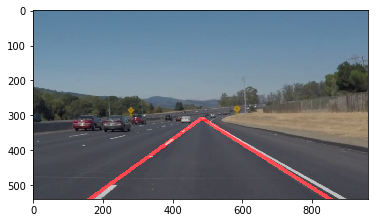

In [124]:
nFrames = 0
white_output = 'test_videos/modified_solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [254]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
nFrames = 0
yellow_output = 'test_videos/modified_solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

(540, 960, 3)
avg_neg_slope(before) =  -0.713971572942
mean_negative_slope =  -0.646457642822
avg_neg_slope =  -0.680214607882
highest =  [467, 314]
bottom =  [-482.70027475850281, 960]
end-points =  467 314 -482 960
avg_pos_slope(before) =  0.609316381488
mean_positive_slope =  0.699813587652
nFrames =  1
avg_pos_slope =  0.65456498457
highest =  [511, 320]
bottom =  [1488.7486041666602, 960]
end points =  511 320 1488 960
[MoviePy] >>>> Building video test_videos/modified_solidYellowLeft.mp4
[MoviePy] Writing video test_videos/modified_solidYellowLeft.mp4



  0%|          | 0/683 [00:00<?, ?it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.680214607882
mean_negative_slope =  -0.646457642822
avg_neg_slope =  -0.668962286195
highest =  [467, 314]
bottom =  [-498.67476721942319, 960]
end-points =  467 314 -498 960
avg_pos_slope(before) =  0.65456498457
mean_positive_slope =  0.699813587652
nFrames =  2
avg_pos_slope =  0.669647852264
highest =  [511, 320]
bottom =  [1466.726204207102, 960]
end points =  511 320 1466 960



  0%|          | 2/683 [00:00<00:59, 11.52it/s]

(540, 960, 3)
(540, 960, 3)


avg_neg_slope(before) =  -0.668962286195
mean_negative_slope =  nan
avg_neg_slope =  -0.668962286195
highest =  [0, 1000]
bottom =  [59.794103233400818, 960]
end-points =  0 1000 59 960
avg_pos_slope(before) =  0.669647852264
mean_positive_slope =  nan
nFrames =  4



  0%|          | 3/683 [00:00<01:22,  8.20it/s]

avg_pos_slope =  0.669647852264
highest =  [0, 1000]
bottom =  [-59.732887762943868, 960]
end points =  0 1000 -59 960
(540, 960, 3)



  1%|          | 4/683 [00:00<01:22,  8.26it/s]

avg_neg_slope(before) =  -0.668962286195
mean_negative_slope =  nan
avg_neg_slope =  -0.668962286195
highest =  [0, 1000]
bottom =  [59.794103233400818, 960]
end-points =  0 1000 59 960
avg_pos_slope(before) =  0.669647852264
mean_positive_slope =  nan
nFrames =  5
avg_pos_slope =  0.669647852264
highest =  [0, 1000]
bottom =  [-59.732887762943868, 960]
end points =  0 1000 -59 960
(540, 960, 3)
avg_neg_slope(before) =  -0.668962286195
mean_negative_slope =  nan


avg_neg_slope =  -0.668962286195
highest =  [0, 1000]
bottom =  [59.794103233400818, 960]
end-points =  0 1000 59 960
avg_pos_slope(before) =  0.669647852264
mean_positive_slope =  0.44262295082
nFrames =  6
avg_pos_slope =  0.637215723486
highest = 


  1%|          | 5/683 [00:00<01:26,  7.81it/s]

 [479, 342]
bottom =  [1448.8442414738918, 960]
end points =  479 342 1448 960
(540, 960, 3)
avg_neg_slope(before) =  -0.668962286195
mean_negative_slope =  nan
avg_neg_slope =  -0.668962286195
highest =  [0, 1000]
bottom =  [59.794103233400818, 960]
end-points =  0 1000 59 960
avg_pos_slope(before) =  0.637215723486
mean_positive_slope =  nan
nFrames =  7



  1%|          | 6/683 [00:00<01:24,  8.04it/s]

avg_pos_slope =  0.637215723486
highest =  [0, 1000]
bottom =  [-62.773090063035063, 960]
end points =  0 1000 -62 960
(540, 960, 3)
avg_neg_slope(before) =  -0.668962286195
mean_negative_slope =  nan


avg_neg_slope =  -0.668962286195
highest =  [0, 1000]
bottom =  [59.794103233400818, 960]
end-points =  0 1000 59 960
avg_pos_slope(before) =  0.637215723486
mean_positive_slope =  0.08
nFrames =  8
avg_pos_slope =  0.575302865321
highest =  [429, 340]
bottom =  [1506.6932245134967, 960]
end points =  429 340 1506 960
(540, 960, 3)
avg_neg_slope(before) =  -0.668962286195
mean_negative_slope =  nan



  1%|          | 8/683 [00:00<01:13,  9.20it/s]

avg_neg_slope =  -0.668962286195
highest =  [0, 1000]
bottom =  [59.794103233400818, 960]
end-points =  0 1000 59 960
avg_pos_slope(before) =  0.575302865321
mean_positive_slope =  0.391210278414
nFrames =  9
avg_pos_slope =  0.556893606631
highest =  [463, 337]
bottom =  [1581.7056065688105, 960]
end points =  463 337 1581 960
(540, 960, 3)
avg_neg_slope(before) =  -0.668962286195
mean_negative_slope =  nan


avg_neg_slope =  -0.668962286195
highest =  [0, 1000]
bottom =  [59.794103233400818, 960]
end-points =  0 1000 59 960
avg_pos_slope(before) =  0.556893606631
mean_positive_slope =  0.493272625757
nFrames =  10
avg_pos_slope =  0.551109881097
highest =  [412, 339]
bottom =  [1538.81703105061, 960]
end points =  412 339 1538 960
(540, 960, 3)
avg_neg_slope(before) =  -0.668962286195
mean_negative_slope =  nan



  1%|▏         | 10/683 [00:01<01:04, 10.37it/s]

avg_neg_slope =  -0.668962286195
highest =  [0, 1000]
bottom =  [59.794103233400818, 960]
end-points =  0 1000 59 960
avg_pos_slope(before) =  0.551109881097
mean_positive_slope =  0.405790120891
nFrames =  11
avg_pos_slope =  0.538999901079
highest =  [415, 340]
bottom =  [1565.2785042414341, 960]
end points =  415 340 1565 960
(540, 960, 3)
avg_neg_slope(before) =  -0.668962286195
mean_negative_slope =  -0.389017311347
avg_neg_slope =  -0.647428057361
highest =  [463, 350]
bottom =  [-479.18962719468846, 960]
end-points =  463 350 -479 960
avg_pos_slope(before) =  0.538999901079
mean_positive_slope =  0.47366415885
nFrames =  12
avg_pos_slope =  0.533974074754
highest =  [492, 336]
bottom =  [1660.5960601875465, 960]
end points =  492 336 1660 960


(540, 960, 3)
avg_neg_slope(before) =  -0.647428057361
mean_negative_slope =  nan
avg_neg_slope =  -0.647428057361
highest =  [0, 1000]
bottom =  [61.7829263734222, 960]
end-points =  0 1000 61 960
avg_pos_slope(before) =  0.533974074754
mean_positive_slope =  0.423044808148
nFrames =  13
avg_pos_slope =  0.526050555711
highest =  [447, 336]
bottom =  [1633.1977774299874, 960]
end points =  447 336 1633 960



  2%|▏         | 12/683 [00:01<00:56, 11.86it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.647428057361
mean_negative_slope =  -0.629337779338
avg_neg_slope =  -0.646222038826
highest =  [446, 337]
bottom =  [-518.06492284296644, 960]
end-points =  446 337 -518 960
avg_pos_slope(before) =  0.526050555711
mean_positive_slope =  0.50596205427
nFrames =  14
avg_pos_slope =  0.524711322281
highest =  [413, 342]
bottom =  [1590.7904797497492, 960]
end points =  413 342 1590 960



  2%|▏         | 14/683 [00:01<00:49, 13.39it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.646222038826
mean_negative_slope =  -0.604026845638
avg_neg_slope =  -0.643584839252
highest =  [468, 338]
bottom =  [-498.46154798080602, 960]
end-points =  468 338 -498 960
avg_pos_slope(before) =  0.524711322281
mean_positive_slope =  0.427686619428
nFrames =  15
avg_pos_slope =  0.518647278353
highest =  [442, 339]
bottom =  [1639.3455292619558, 960]
end points =  442 339 1639 960
(540, 960, 3)
avg_neg_slope(before) =  -0.643584839252
mean_negative_slope =  -0.90099009901
avg_neg_slope =  -0.65872632512
highest =  [412, 347]
bottom =  [-518.58372896915614, 960]
end-points =  412 347 -518 960
avg_pos_slope(before) =  0.518647278353
mean_positive_slope =  0.408079881906
nFrames =  16
avg_pos_slope =  0.512143313856
highest =  [449, 336]
bottom =  [1667.4089553010126, 960]
end points =  449 336 1667 960


(540, 960, 3)
avg_neg_slope(before) =  -0.65872632512
mean_negative_slope =  -0.304708399996
avg_neg_slope =  -0.639058662613
highest =  [441, 342]
bottom =  [-526.04737163456889, 960]
end-points =  441 342 -526 960
avg_pos_slope(before) =  0.512143313856
mean_positive_slope =  0.523519142845
nFrames =  17
avg_pos_slope =  0.512775304356
highest =  [404, 343]
bottom =  [1607.2560748519652, 960]
end points =  404 343 1607 960
(540, 960, 3)
avg_neg_slope(before) =  -0.639058662613
mean_negative_slope =  -0.439707746719
avg_neg_slope =  -0.628566509145
highest =  [447, 338]
bottom =  


  2%|▏         | 17/683 [00:01<00:44, 15.13it/s]

[-542.55319914570384, 960]
end-points =  447 338 -542 960
avg_pos_slope(before) =  0.512775304356
mean_positive_slope =  0.479143296302
nFrames =  18
avg_pos_slope =  0.511005198669
highest =  [474, 336]
bottom =  [1695.1226062392136, 960]
end points =  474 336 1695 960
(540, 960, 3)
avg_neg_slope(before) =  -0.628566509145
mean_negative_slope =  -1.29152956331
avg_neg_slope =  -0.661714661853


  3%|▎         | 19/683 [00:01<00:41, 16.14it/s]


highest =  [446, 338]
bottom =  [-493.98219452807348, 960]
end-points =  446 338 -493 960
avg_pos_slope(before) =  0.511005198669
mean_positive_slope =  0.399337512442
nFrames =  19
avg_pos_slope =  0.505421814357
highest =  [453, 338]
bottom =  [1683.6552315929314, 960]
end points =  453 338 1683 960
(540, 960, 3)
avg_neg_slope(before) =  -0.661714661853
mean_negative_slope =  -0.538539904778
avg_neg_slope =  -0.65584919723
highest =  [446, 338]
bottom =  [-502.38874946656517, 960]
end-points =  446 338 -502 960
avg_pos_slope(before) =  0.505421814357
mean_positive_slope =  1.6128240567
nFrames =  20
avg_pos_slope =  0.558155254469
highest =  [471, 336]
bottom =  [1588.9685132475081, 960]
end points =  471 336 1588 960
(540, 960, 3)


avg_neg_slope(before) =  -0.65584919723
mean_negative_slope =  -0.601145958676
avg_neg_slope =  -0.653362686387
highest =  [444, 339]
bottom =  [-506.46750134143559, 960]
end-points =  444 339 -506 960
avg_pos_slope(before) =  0.558155254469
mean_positive_slope =  0.514719681279
nFrames =  21
avg_pos_slope =  0.556180910233
highest =  [470, 336]
bottom =  [1591.9371044908726, 960]
end points =  470 336 1591 960
(540, 960, 3)
avg_neg_slope(before) =  -0.653362686387
mean_negative_slope =  nan
avg_neg_slope =  -0.653362686387
highest =  [464, 335]
bottom =  [-492.58967526311937, 960]
end-points =  464 335 -492 960
avg_pos_slope(before) =  0.556180910233
mean_positive_slope =  3.20427658908
nFrames =  22
avg_pos_slope =  0.671315504966
highest =  [400, 348]
bottom =  [1311.642879500241, 960]
end points =  400 348 1311 960



  3%|▎         | 21/683 [00:01<00:41, 15.81it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.653362686387
mean_negative_slope =  -9.77169718351
avg_neg_slope =  -1.03329329043
highest =  [403, 351]
bottom =  [-186.37767779783491, 960]
end-points =  403 351 -186 960
avg_pos_slope(before) =  0.671315504966
mean_positive_slope =  1.25990698103
nFrames =  23
avg_pos_slope =  0.695840149802
highest =  [461, 344]
bottom =  [1346.2607889551773, 960]
end points =  461 344 1346 960
(540, 960, 3)
avg_neg_slope(before) =  -1.03329329043
mean_negative_slope =  -10.1320396974
avg_neg_slope =  -1.39724314671
highest =  [559, 348]
bottom =  [120.99463104247893, 960]
end-points =  559 348 120 960
avg_pos_slope(before) =  0.695840149802
mean_positive_slope =  2.55913143614
nFrames =  24
avg_pos_slope =  0.770371801255
highest =  [559, 349]
bottom =  [1352.1235268534472, 960]
end points =  559 349 1352 960



  3%|▎         | 23/683 [00:01<00:39, 16.71it/s]

(540, 960, 3)
avg_neg_slope(before) =  -1.39724314671
mean_negative_slope =  -0.469368826815
avg_neg_slope =  -1.36155567287
highest =  [563, 351]
bottom =  [115.71751854600419, 960]
end-points =  563 351 115 960
avg_pos_slope(before) =  0.770371801255
mean_positive_slope =  1.14969370799
nFrames =  25
avg_pos_slope =  0.78496110536
highest =  [562, 350]
bottom =  [1339.1085673346909, 960]
end points =  562 350 1339 960
(540, 960, 3)
avg_neg_slope(before) =  -1.36155567287
mean_negative_slope =  nan
avg_neg_slope =  -1.36155567287
highest =  [567, 350]
bottom =  [118.98306455346888, 960]
end-points =  567 350 118 960
avg_pos_slope(before) =  0.78496110536
mean_positive_slope =  0.984127316694
nFrames =  26
avg_pos_slope =  0.792337631706
highest =  [536, 335]
bottom =  [1324.8051444108548, 960]
end points =  536 335 1324 960



  4%|▎         | 25/683 [00:01<00:39, 16.62it/s]

(540, 960, 3)
avg_neg_slope(before) =  -1.36155567287
mean_negative_slope =  -3.90542755911
avg_neg_slope =  -1.45240824024
highest =  [540, 342]
bottom =  [114.49979772989671, 960]
end-points =  540 342 114 960
avg_pos_slope(before) =  0.792337631706
mean_positive_slope =  0.620984472686
nFrames =  27
avg_pos_slope =  0.786217876027
highest =  [539, 337]
bottom =  [1331.4012147223557, 960]
end points =  539 337 1331 960
(540, 960, 3)
avg_neg_slope(before) =  -1.45240824024
mean_negative_slope =  -0.517445371229
avg_neg_slope =  -1.42016814131
highest =  [538, 337]
bottom =  [99.319549509944366, 960]
end-points =  538 337 99 960
avg_pos_slope(before) =  0.786217876027
mean_positive_slope =  0.488485150439
nFrames =  28
avg_pos_slope =  0.775951230317
highest =  [539, 337]
bottom =  [1341.8855109175574, 960]
end points =  539 337 1341 960



  4%|▍         | 27/683 [00:01<00:38, 17.20it/s]

(540, 960, 3)
avg_neg_slope(before) =  -1.42016814131
mean_negative_slope =  -0.521255172073
avg_neg_slope =  -1.39020437567
highest =  [549, 343]
bottom =  [105.18036398091151, 960]
end-points =  549 343 105 960
avg_pos_slope(before) =  0.775951230317
mean_positive_slope =  0.527004554029
nFrames =  29
avg_pos_slope =  0.767653007774
highest =  [541, 337]
bottom =  [1352.564591932824, 960]
end points =  541 337 1352 960
(540, 960, 3)
avg_neg_slope(before) =  -1.39020437567
mean_negative_slope =  -0.557676997024
avg_neg_slope =  -1.36334865377
highest =  [474, 339]
bottom =  [18.503896137615964, 960]
end-points =  474 339 18 960
avg_pos_slope(before) =  0.767653007774
mean_positive_slope =  0.415246511213
nFrames =  30
avg_pos_slope =  0.756285056272
highest =  [544, 337]
bottom =  [1367.763467006826, 960]
end points =  544 337 1367 960
(540, 960, 3)



  4%|▍         | 30/683 [00:02<00:37, 17.31it/s]

avg_neg_slope(before) =  -1.36334865377
mean_negative_slope =  nan
avg_neg_slope =  -1.36334865377
highest =  [473, 335]
bottom =  [14.56994377779389, 960]
end-points =  473 335 14 960
avg_pos_slope(before) =  0.756285056272
mean_positive_slope =  1.88165139257
nFrames =  31
avg_pos_slope =  0.791452754281
highest =  [545, 338]
bottom =  [1330.8965638005766, 960]
end points =  545 338 1330 960
(540, 960, 3)
avg_neg_slope(before) =  -1.36334865377
mean_negative_slope =  -0.736490785731
avg_neg_slope =  -1.3443529608
highest =  [446, 322]
bottom =  [-28.577747512826598, 960]
end-points =  446 322 -28 960
avg_pos_slope(before) =  0.791452754281
mean_positive_slope =  0.618367738642
nFrames =  32
avg_pos_slope =  0.786207753807
highest =  [528, 329]
bottom =  [1330.5868441826319, 960]
end points =  528 329 1330 960



  5%|▍         | 32/683 [00:02<00:36, 17.69it/s]

(540, 960, 3)
avg_neg_slope(before) =  -1.3443529608
mean_negative_slope =  -0.706608422453
avg_neg_slope =  -1.3255957685
highest =  [423, 347]
bottom =  [-39.433582369069661, 960]
end-points =  423 347 -39 960
avg_pos_slope(before) =  0.786207753807
mean_positive_slope =  0.63533047748
nFrames =  33
avg_pos_slope =  0.781770186856
highest =  [527, 328]
bottom =  [1335.4217211472283, 960]
end points =  527 328 1335 960
(540, 960, 3)
avg_neg_slope(before) =  -1.3255957685
mean_negative_slope =  -0.711419861344
avg_neg_slope =  -1.30804788544
highest =  [443, 329]
bottom =  [-39.398241704474259, 960]
end-points =  443 329 -39 960
avg_pos_slope(before) =  0.781770186856
mean_positive_slope =  0.610786449622
nFrames =  34
avg_pos_slope =  0.776884937221
highest =  [529, 329]
bottom =  [1341.2180901808906, 960]
end points =  529 329 1341 960



  5%|▍         | 34/683 [00:02<00:35, 18.15it/s]

(540, 960, 3)
avg_neg_slope(before) =  -1.30804788544
mean_negative_slope =  -0.727191168291
avg_neg_slope =  -1.29191297663
highest =  [453, 319]
bottom =  [-43.163450322660616, 960]
end-points =  453 319 -43 960
avg_pos_slope(before) =  0.776884937221
mean_positive_slope =  0.60908735757
nFrames =  35
avg_pos_slope =  0.772223893342
highest =  [531, 330]
bottom =  [1346.8255726504703, 960]
end points =  531 330 1346 960
(540, 960, 3)
avg_neg_slope(before) =  -1.29191297663
mean_negative_slope =  -0.745270026216
avg_neg_slope =  -1.27713884283
highest =  [444, 323]
bottom =  [-54.771142679599905, 960]
end-points =  444 323 -54 960
avg_pos_slope(before) =  0.772223893342
mean_positive_slope =  0.639679725814
nFrames =  36
avg_pos_slope =  0.768641618544
highest =  [531, 330]
bottom =  [1350.6277495271838, 960]
end points =  531 330 1350 960



  5%|▌         | 36/683 [00:02<00:38, 16.77it/s]

(540, 960, 3)
avg_neg_slope(before) =  -1.27713884283
mean_negative_slope =  -0.74155875208
avg_neg_slope =  -1.26304462992
highest =  [454, 318]
bottom =  [-54.295577838581792, 960]
end-points =  454 318 -54 960
avg_pos_slope(before) =  0.768641618544
mean_positive_slope =  0.637226209172
nFrames =  37
avg_pos_slope =  0.765183318297
highest =  [532, 331]
bottom =  [1354.0252388666224, 960]
end points =  532 331 1354 960
(540, 960, 3)
avg_neg_slope(before) =  -1.26304462992
mean_negative_slope =  


  6%|▌         | 38/683 [00:02<00:38, 16.77it/s]

-0.772708250402
avg_neg_slope =  -1.25047190224
highest =  [454, 318]
bottom =  [-59.406177980509071, 960]
end-points =  454 318 -59 960
avg_pos_slope(before) =  0.765183318297
mean_positive_slope =  0.620079681308
nFrames =  38
avg_pos_slope =  0.761462712221
highest =  [533, 331]
bottom =  [1359.0417613434288, 960]
end points =  533 331 1359 960
(540, 960, 3)
avg_neg_slope(before) =  -1.25047190224
mean_negative_slope =  -0.740262360399
avg_neg_slope =  -1.23771666369
highest =  [453, 319]
bottom =  [-64.889125034460093, 960]
end-points =  453 319 -64 960
avg_pos_slope(before) =  0.761462712221
mean_positive_slope =  0.604032970203
nFrames =  39
avg_pos_slope =  0.75752696867
highest =  [535, 333]
bottom =  [1362.6933045707221, 960]
end points =  535 333 1362 960
(540, 960, 3)
avg_neg_slope(before) =  -1.23771666369
mean_negative_slope =  -0.772437570649
avg_neg_slope =  -1.22636839313
highest =  [452, 319]
bottom =  [-70.681441882275649, 960]
end-points =  452 319 -70 960
avg_pos_sl

(540, 960, 3)
avg_neg_slope(before) =  -1.22636839313
mean_negative_slope =  -0.753571062466
avg_neg_slope =  -1.21511131383
highest =  [434, 328]
bottom =  [-86.116957852022111, 960]
end-points =  434 328 -86 960
avg_pos_slope(before) =  0.754122922695
mean_positive_slope =  0.607137882376
nFrames =  41
avg_pos_slope =  0.750623278878
highest =  [538, 334]
bottom =  [1371.9736024921515, 960]
end points =  538 334 1371 960
(540, 960, 3)



  6%|▌         | 41/683 [00:02<00:36, 17.48it/s]

avg_neg_slope(before) =  -1.21511131383
mean_negative_slope =  -0.752646997242
avg_neg_slope =  -1.20435632972
highest =  [439, 328]
bottom =  [-85.761637733930542, 960]
end-points =  439 328 -85 960
avg_pos_slope(before) =  0.750623278878
mean_positive_slope =  0.613104159718
nFrames =  42
avg_pos_slope =  0.747425159827
highest =  [539, 334]
bottom =  [1376.5420492194885, 960]
end points =  539 334 1376 960
(540, 960, 3)
avg_neg_slope(before) =  -1.20435632972
mean_negative_slope =  -0.729331422648
avg_neg_slope =  -1.19356030911
highest =  [436, 327]
bottom =  [-94.346053878002564, 960]
end-points =  436 327 -94 960
avg_pos_slope(before) =  0.747425159827
mean_positive_slope =  0.612043259909
nFrames =  43
avg_pos_slope =  0.744348298466
highest =  [532, 331]
bottom =  [1377.0345104525009, 960]
end points =  532 331 1377 960
(540, 960, 3)
avg_neg_slope(before) =  -1.19356030911
mean_negative_slope =  -0.725706386195
avg_neg_slope =  -1.18316355526
highest =  [446, 324]
bottom =  [-9


  6%|▋         | 43/683 [00:02<00:36, 17.53it/s]

(540, 960, 3)
avg_neg_slope(before) =  -1.18316355526
mean_negative_slope =  -0.735179158323
avg_neg_slope =  -1.17342476403
highest =  [442, 328]
bottom =  [-96.59439426824585, 960]
end-points =  442 328 -96 960
avg_pos_slope(before) =  0.741661406161
mean_positive_slope =  0.609448429652
nFrames =  45
avg_pos_slope =  0.738787211019
highest =  [524, 327]
bottom =  [1380.8096341658295, 960]
end points =  524 327 1380 960



  7%|▋         | 45/683 [00:03<00:38, 16.42it/s]

(540, 960, 3)
avg_neg_slope(before) =  -1.17342476403
mean_negative_slope =  -0.72818760677
avg_neg_slope =  -1.16395163302
highest =  [442, 324]
bottom =  [-104.4144574027314, 960]
end-points =  442 324 -104 960
avg_pos_slope(before) =  0.738787211019
mean_positive_slope =  0.605858218976
nFrames =  46
avg_pos_slope =  0.735958934593
highest =  [525, 327]
bottom =  [1385.1023375713678, 960]
end points =  525 327 1385 960
(540, 960, 3)
avg_neg_slope(before) =  -1.16395163302
mean_negative_slope =  -0.734162715619
avg_neg_slope =  -1.15499769724
highest =  [454, 318]
bottom =  [-101.84526404972594, 960]
end-points =  454 318 -101 960
avg_pos_slope(before) =  0.735958934593
mean_positive_slope =  0.635552749311
nFrames =  47
avg_pos_slope =  0.733867139066
highest =  [515, 322]
bottom =  [1384.3671729350274, 960]
end points =  515 322 1384 960
(540, 960, 3)
avg_neg_slope(before) =  -1.15499769724
mean_negative_slope =  -0.737844687405
avg_neg_slope =  -1.14648437051
highest =  [454, 318]


  7%|▋         | 47/683 [00:03<00:37, 16.85it/s]

(540, 960, 3)
avg_neg_slope(before) =  -1.14648437051
mean_negative_slope =  -0.735424884696
avg_neg_slope =  -1.13826318079
highest =  [449, 323]
bottom =  [-110.62453213655526, 960]
end-points =  449 323 -110 960



  7%|▋         | 49/683 [00:03<00:38, 16.31it/s]

avg_pos_slope(before) =  0.731629772186
mean_positive_slope =  0.617338882205
nFrames =  49
avg_pos_slope =  0.729343954387
highest =  [515, 323]
bottom =  [1388.3876467595198, 960]
end points =  515 323 1388 960
(540, 960, 3)
avg_neg_slope(before) =  -1.13826318079
mean_negative_slope =  -0.739876976575
avg_neg_slope =  -1.13045168659
highest =  [454, 318]
bottom =  [-113.91458459816421, 960]
end-points =  454 318 -113 960
avg_pos_slope(before) =  0.729343954387
mean_positive_slope =  0.609986396471
nFrames =  50
avg_pos_slope =  0.727003610114
highest =  [516, 323]
bottom =  [1392.1992253385511, 960]
end points =  516 323 1392 960
(540, 960, 3)
avg_neg_slope(before) =  -1.13045168659
mean_negative_slope =  -0.724011582549
avg_neg_slope =  -1.12263553075
highest =  [450, 322]
bottom =  [-118.30554755006214, 960]
end-points =  450 322 -118 960
avg_pos_slope(before) =  0.727003610114
mean_positive_slope =  0.613046333097
nFrames =  51
avg_pos_slope =  0.724812124017
highest =  [517, 323


  7%|▋         | 51/683 [00:03<00:39, 16.00it/s]


bottom =  [-122.49121675461289, 960]
end-points =  452 319 -122 960
avg_pos_slope(before) =  0.724812124017
mean_positive_slope =  0.611787168697
nFrames =  52
avg_pos_slope =  0.72267957769
highest =  [518, 324]
bottom =  [1398.0580777894984, 960]
end points =  518 324 1398 960
(540, 960, 3)



  8%|▊         | 53/683 [00:03<00:40, 15.73it/s]

avg_neg_slope(before) =  -1.115769887
mean_negative_slope =  -0.737774887437
avg_neg_slope =  -1.1087699796
highest =  [454, 318]
bottom =  [-125.02000578333626, 960]
end-points =  454 318 -125 960
avg_pos_slope(before) =  0.72267957769
mean_positive_slope =  0.611084443564
nFrames =  53
avg_pos_slope =  0.720613001133
highest =  [518, 324]
bottom =  [1400.5819115120157, 960]
end points =  518 324 1400 960
(540, 960, 3)
avg_neg_slope(before) =  -1.1087699796
mean_negative_slope =  -0.76489329117
avg_neg_slope =  -1.10251767617
highest =  [454, 319]
bottom =  [-127.39657427062549, 960]
end-points =  454 319 -127 960
avg_pos_slope(before) =  0.720613001133
mean_positive_slope =  0.618186801066
nFrames =  54
avg_pos_slope =  0.718750706586
highest =  [520, 325]
bottom =  [1403.4773923440903, 960]
end points =  520 325 1403 960
(540, 960, 3)
avg_neg_slope(before) =  -1.10251767617
mean_negative_slope =  -0.771288089326
avg_neg_slope =  -1.09660286212
highest =  [457, 317]
bottom =  [-129.3


  8%|▊         | 57/683 [00:03<00:39, 15.70it/s]

highest =  [511, 320]
bottom =  [1406.2283747131651, 960]
end points =  511 320 1406 960
(540, 960, 3)
avg_neg_slope(before) =  -1.09002776061
mean_negative_slope =  -0.713692693784
avg_neg_slope =  -1.08353922497
highest =  [456, 317]
bottom =  [-137.42567872039766, 960]
end-points =  456 317 -137 960
avg_pos_slope(before) =  0.714901379444
mean_positive_slope =  0.632595009702
nFrames =  57
avg_pos_slope =  0.713482304104
highest =  [512, 321]
bottom =  [1407.6073560964569, 960]
end points =  512 321 1407 960
(540, 960, 3)
avg_neg_slope(before) =  -1.08353922497
mean_negative_slope =  -0.726926570415
avg_neg_slope =  -1.07749494269
highest =  [456, 317]
bottom =  [-140.75454104044667, 960]
end-points =  456 317 -140 960
avg_pos_slope(before) =  0.713482304104
mean_positive_slope =  0.651819973869
nFrames =  58
avg_pos_slope =  0.712437179863
highest =  [511, 320]
bottom =  [1409.3248180892228, 960]
end points =  511 320 1409 960
(540, 960, 3)
avg_neg_slope(before) =  -1.07749494269
m

 960
avg_pos_slope(before) =  0.712437179863
mean_positive_slope =  0.642916000466
nFrames =  59
avg_pos_slope =  0.711278493539
highest =  [509, 319]
bottom =  [1410.1941255392917, 960]
end points =  509 319 1410 960
(540, 960, 3)
avg_neg_slope(before) =  -1.07148256115
mean_negative_slope =  -0.683205346639
avg_neg_slope =  -1.06511736091
highest =  [444, 323]
bottom = 


  9%|▉         | 61/683 [00:04<00:39, 15.83it/s]

 [-154.05616111166984, 960]
end-points =  444 323 -154 960
avg_pos_slope(before) =  0.711278493539
mean_positive_slope =  0.633821495753
nFrames =  60
avg_pos_slope =  0.71000870669
highest =  [507, 318]
bottom =  [1411.2142637837435, 960]
end points =  507 318 1411 960
(540, 960, 3)
avg_neg_slope(before) =  -1.06511736091
mean_negative_slope =  -0.717660788023
avg_neg_slope =  -1.05951322264
highest =  [458, 316]
bottom =  [-149.82629819004197, 960]
end-points =  458 316 -149 960
avg_pos_slope(before) =  0.71000870669
mean_positive_slope =  0.617306672609
nFrames =  61
avg_pos_slope =  0.708513512592
highest =  [512, 321]
bottom =  [1413.8882331010511, 960]
end points =  512 321 1413 960
(540, 960, 3)
avg_neg_slope(before) =  -1.05951322264
mean_negative_slope =  -0.705308659149
avg_neg_slope =  -1.05389092798
highest =  [458, 316]
bottom =  [-153.06892838916588, 960]
end-points =  458 316 -153 960
avg_pos_slope(before) =  0.708513512592
mean_positive_slope =  0.61102687984
nFrames = 

 -1.0485896754
highest =  [458, 316]
bottom =  [-156.15824998770486, 960]
end-points =  458 316 -156 960
avg_pos_slope(before) =  0.706966105723
mean_positive_slope =  0.624203954519
nFrames =  63
avg_pos_slope =  0.705672947111
highest =  [507, 318]
bottom =  [1416.7698907528313, 960]
end points =  507 318 1416 960
(540, 960, 3)
avg_neg_slope(before) =  -1.0485896754
mean_negative_slope =  -0.710736011159
avg_neg_slope =  -1.04339192672
highest =  [456, 317]
bottom =  [-160.25932071428818, 960]
end-points =  456 317 -160 960
avg_pos_slope(before) =  0.705672947111
mean_positive_slope =  0.60198711502
nFrames =  64
avg_pos_slope =  0.704077780463
highest =  [513, 321]
bottom =  [1420.570182913289, 960]
end points =  513 321 1420 960



  9%|▉         | 63/683 [00:04<00:40, 15.23it/s]

(540, 960, 3)
avg_neg_slope(before) =  -1.04339192672
mean_negative_slope =  -0.710204120928
avg_neg_slope =  -1.03834362663
highest =  [456, 317]
bottom =  [-163.25549837942481, 960]
end-points =  456 317 -163 960
avg_pos_slope(before) =  0.704077780463
mean_positive_slope =  0.610412802444
nFrames =  65
avg_pos_slope =  0.702658614129
highest =  [507, 318]
bottom =  [1420.6727097488792, 960]
end points =  507 318 1420 960
(540, 960, 3)
avg_neg_slope(before) =  -1.03834362663
mean_negative_slope =  -0.715874591189
avg_neg_slope =  -1.03353065596
highest =  [458, 316]
bottom =  [-165.10681960838147, 960]
end-points =  458 316 -165 960
avg_pos_slope(before) =  0.702658614129
mean_positive_slope =  0.610174011416
nFrames =  66
avg_pos_slope =  0.701278246925
highest =  [509, 320]
bottom =  [1421.6192104297447, 960]
end points =  509 320 1421 960



 10%|▉         | 65/683 [00:04<00:41, 14.93it/s]

(540, 960, 3)
avg_neg_slope(before) =  -1.03353065596
mean_negative_slope =  -0.711651855014
avg_neg_slope =  -1.02879714418
highest =  [457, 317]
bottom =  [-168.00173492861384, 960]
end-points =  457 317 -168 960
avg_pos_slope(before) =  0.701278246925
mean_positive_slope =  0.614488114174
nFrames =  67
avg_pos_slope =  0.700001921443
highest =  [505, 317]
bottom =  [1423.5689071744487, 960]
end points =  505 317 1423 960



 10%|▉         | 67/683 [00:04<00:41, 14.84it/s]

(540, 960, 3)
avg_neg_slope(before) =  -1.02879714418
mean_negative_slope =  -0.709050527604
avg_neg_slope =  -1.02416313524
highest =  [458, 316]
bottom =  [-170.80607379856585, 960]
end-points =  458 316 -170 960
avg_pos_slope(before) =  0.700001921443
mean_positive_slope =  0.612893263505
nFrames =  68
avg_pos_slope =  0.698739477125
highest =  [511, 322]
bottom =  [1424.0727844731869, 960]
end points =  511 322 1424 960
(540, 960, 3)
avg_neg_slope(before) =  -1.02416313524
mean_negative_slope =  -0.70523928828
avg_neg_slope =  -1.01960708028
highest =  [460, 315]
bottom =  [-172.59662714406267, 960]
end-points =  460 315 -172 960
avg_pos_slope(before) =  0.698739477125
mean_positive_slope =  0.662126092837
nFrames =  69
avg_pos_slope =  0.698216428778
highest =  [505, 318]
bottom =  [1424.4856688254272, 960]
end points =  505 318 1424 960
(540, 960, 3)
avg_neg_slope(before) =  -1.01960708028
mean_negative_slope =  -0.708788370265
avg_neg_slope =  -1.01522935197
highest =  [462, 314


 10%|█         | 69/683 [00:04<00:41, 14.86it/s]

70
avg_pos_slope =  0.697282329276
highest =  [503, 316]
bottom =  [1426.5857169488474, 960]
end points =  503 316 1426 960
(540, 960, 3)



 10%|█         | 71/683 [00:04<00:40, 14.99it/s]

avg_neg_slope(before) =  -1.01522935197
mean_negative_slope =  -0.691257902762
avg_neg_slope =  -1.01072974851
highest =  [453, 323]
bottom =  [-177.23770789104628, 960]
end-points =  453 323 -177 960
avg_pos_slope(before) =  0.697282329276
mean_positive_slope =  0.620999061817
nFrames =  71
avg_pos_slope =  0.69622283945
highest =  [503, 316]
bottom =  [1427.9912003873862, 960]
end points =  503 316 1427 960
(540, 960, 3)
avg_neg_slope(before) =  -1.01072974851
mean_negative_slope =  -0.711204226173
avg_neg_slope =  -1.00662665917
highest =  [462, 314]
bottom =  [-179.74735898155342, 960]
end-points =  462 314 -179 960
avg_pos_slope(before) =  0.69622283945
mean_positive_slope =  0.62857670104
nFrames =  72
avg_pos_slope =  0.69529618002
highest =  [503, 316]
bottom =  [1429.223986994577, 960]
end points =  503 316 1429 960
(540, 960, 3)
avg_neg_slope(before) =  -1.00662665917
mean_negative_slope =  -0.702742756545
avg_neg_slope =  -1.00252011994
highest =  [450, 320]
bottom =  [-188.


 11%|█         | 75/683 [00:04<00:39, 15.35it/s]

-1.00252011994
mean_negative_slope =  -0.710315065448
avg_neg_slope =  -0.998624052548
highest =  [462, 314]
bottom =  [-184.89008676671412, 960]
end-points =  462 314 -184 960
avg_pos_slope(before) =  0.69453317708
mean_positive_slope =  0.635484471688
nFrames =  74
avg_pos_slope =  0.693745861008
highest =  [501, 315]
bottom =  [1430.7352766368249, 960]
end points =  501 315 1430 960
(540, 960, 3)
avg_neg_slope(before) =  -0.998624052548
mean_negative_slope =  -0.712785129135
avg_neg_slope =  -0.994863014082
highest =  [464, 313]
bottom =  [-186.34079148785176, 960]
end-points =  464 313 -186 960
avg_pos_slope(before) =  0.693745861008
mean_positive_slope =  0.62255454401
nFrames =  75
avg_pos_slope =  0.692809133153
highest =  [501, 315]
bottom =  [1431.9923457052698, 960]
end points =  501 315 1431 960
(540, 960, 3)
avg_neg_slope(before) =  -0.994863014082
mean_negative_slope =  -0.710419581168
avg_neg_slope =  -0.991168943525
highest =  [462, 314]
bottom =  [-189.75569131822613, 9


 12%|█▏        | 81/683 [00:05<00:35, 16.99it/s]

 960
avg_pos_slope(before) =  0.691400843725
mean_positive_slope =  0.629612587728
nFrames =  78
avg_pos_slope =  0.690618713902
highest =  [499, 314]
bottom =  [1434.3931293726898, 960]
end points =  499 314 1434 960
(540, 960, 3)
avg_neg_slope(before) =  -0.984163967697
mean_negative_slope =  -0.710354436588
avg_neg_slope =  -0.980741348559
highest =  [464, 313]
bottom =  [-195.70502921179229, 960]
end-points =  464 313 -195 960
avg_pos_slope(before) =  0.690618713902
mean_positive_slope =  0.655080070089
nFrames =  79
avg_pos_slope =  0.690174480854
highest =  [501, 315]
bottom =  [1435.5462892248804, 960]
end points =  501 315 1435 960
(540, 960, 3)
avg_neg_slope(before) =  -0.980741348559
mean_negative_slope =  -0.717157192879
avg_neg_slope =  -0.97748722318
highest =  [464, 313]
bottom =  [-197.90123477555696, 960]
end-points =  464 313 -197 960
avg_pos_slope(before) =  0.690174480854
mean_positive_slope =  0.661318729999
nFrames =  80
avg_pos_slope =  0.689818237016
highest =  [


 12%|█▏        | 83/683 [00:05<00:35, 17.05it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.971058222919
mean_negative_slope =  -0.697754810253
avg_neg_slope =  -0.967804610864
highest =  [456, 320]
bottom =  [-205.2905051452779, 960]
end-points =  456 320 -205 960
avg_pos_slope(before) =  0.688817124076
mean_positive_slope =  0.661134452624
nFrames =  83
avg_pos_slope =  0.688487568463
highest =  [501, 315]
bottom =  [1437.8360875993762, 960]
end points =  501 315 1437 960
(540, 960, 3)
avg_neg_slope(before) =  -0.967804610864
mean_negative_slope =  -0.713303030308
avg_neg_slope =  -0.964810474622
highest =  [464, 313]
bottom =  [-206.59802626371942, 960]
end-points =  464 313 -206 960
avg_pos_slope(before) =  0.688487568463
mean_positive_slope =  0.64549869379
nFrames =  84
avg_pos_slope =  0.687981816997
highest =  [501, 315]
bottom =  [1438.5247776398594, 960]
end points =  501 315 1438 960
(540, 960, 3)
avg_neg_slope(before) =  -0.964810474622
mean_negative_slope =  -0.713111170515
avg_neg_slope =  -0.961883738528
highest =  [460


 13%|█▎        | 87/683 [00:05<00:37, 16.08it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.959184991591
mean_negative_slope =  -0.705097239887
avg_neg_slope =  -0.956297630776
highest =  [463, 314]
bottom =  [-212.52190783480145, 960]
end-points =  463 314 -212 960
avg_pos_slope(before) =  0.687381344004
mean_positive_slope =  0.667267841411
nFrames =  87
avg_pos_slope =  0.687152781474
highest =  [501, 315]
bottom =  [1439.6558817623427, 960]
end points =  501 315 1439 960
(540, 960, 3)
avg_neg_slope(before) =  -0.956297630776
mean_negative_slope =  -0.690858412285
avg_neg_slope =  -0.953315167647
highest =  [463, 314]
bottom =  [-214.63528990549926, 960]
end-points =  463 314 -214 960
avg_pos_slope(before) =  0.687152781474
mean_positive_slope =  0.644608171216
nFrames =  88
avg_pos_slope =  0.686674752145
highest =  [499, 314]
bottom =  [1439.76562154316, 960]
end points =  499 314 1439 960
(540, 960, 3)
avg_neg_slope(before) =  -0.953315167647
mean_negative_slope =  -0.686073582093
avg_neg_slope =  -0.950345816697
highest =  [464


 13%|█▎        | 91/683 [00:05<00:37, 15.98it/s]

960
avg_pos_slope(before) =  0.686066145909
mean_positive_slope =  0.633923639958
nFrames =  90
avg_pos_slope =  0.685493151338
highest =  [501, 315]
bottom =  [1441.9284377843146, 960]
end points =  501 315 1441 960
(540, 960, 3)
avg_neg_slope(before) =  -0.947415610763
mean_negative_slope =  -0.697311003653
avg_neg_slope =  -0.944697082425
highest =  [466, 312]
bottom =  [-219.93416033042055, 960]
end-points =  466 312 -219 960
avg_pos_slope(before) =  0.685493151338
mean_positive_slope =  0.625343268099
nFrames =  91
avg_pos_slope =  0.684839348259
highest =  [499, 314]
bottom =  [1442.2869207096205, 960]
end points =  499 314 1442 960
(540, 960, 3)
avg_neg_slope(before) =  -0.944697082425
mean_negative_slope =  -0.688402216309
avg_neg_slope =  -0.94194122365
highest =  [468, 311]
bottom =  [-221.00265080790868, 960]
end-points =  468 311 -221 960
avg_pos_slope(before) =  0.684839348259
mean_positive_slope =  0.637382922239
nFrames =  92
avg_pos_slope =  0.684329064108
highest =  [4


 14%|█▍        | 95/683 [00:06<00:36, 15.97it/s]

 [-213.35219974315672, 960]
end-points =  482 310 -213 960
avg_pos_slope(before) =  0.683902108019
mean_positive_slope =  0.644530307569
nFrames =  94
avg_pos_slope =  0.683487668014
highest =  [485, 310]
bottom =  [1436.0047224242464, 960]
end points =  485 310 1436 960
(540, 960, 3)
avg_neg_slope(before) =  -0.934778088342
mean_negative_slope =  -0.688872007571
avg_neg_slope =  -0.932216566667
highest =  [470, 313]
bottom =  [-224.04473502691954, 960]
end-points =  470 313 -224 960
avg_pos_slope(before) =  0.683487668014
mean_positive_slope =  0.669241290633
nFrames =  95
avg_pos_slope =  0.68333926825
highest =  [490, 312]
bottom =  [1438.2844468457226, 960]
end points =  490 312 1438 960
(540, 960, 3)
avg_neg_slope(before) =  -0.932216566667
mean_negative_slope =  -0.634447073386
avg_neg_slope =  -0.929146778076
highest =  [470, 313]
bottom =  [-226.33777489873316, 960]
end-points =  470 313 -226 960
avg_pos_slope(before) =  0.68333926825
mean_positive_slope =  0.64281524722
nFrame


 14%|█▍        | 99/683 [00:06<00:35, 16.63it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.924329179525
mean_negative_slope =  -0.692456954053
avg_neg_slope =  -0.92201045727
highest =  [468, 314]
bottom =  [-232.64281256897519, 960]
end-points =  468 314 -232 960
avg_pos_slope(before) =  0.682594101892
mean_positive_slope =  0.525875290619
nFrames =  99
avg_pos_slope =  0.681026913779
highest =  [491, 311]
bottom =  [1443.9726166010034, 960]
end points =  491 311 1443 960
(540, 960, 3)
avg_neg_slope(before) =  -0.92201045727
mean_negative_slope =  -0.693934722842
avg_neg_slope =  -0.919752281682
highest =  [470, 312]
bottom =  [-234.53752918656426, 960]
end-points =  470 312 -234 960
avg_pos_slope(before) =  0.681026913779
mean_positive_slope =  0.572069221588
nFrames =  100
avg_pos_slope =  0.679948124748
highest =  [492, 311]
bottom =  [1446.4845796005145, 960]
end points =  492 311 1446 960
(540, 960, 3)
avg_neg_slope(before) =  -0.919752281682
mean_negative_slope =  -0.68804558774
avg_neg_slope =  -0.917480647428
highest =  [492


 15%|█▌        | 103/683 [00:06<00:34, 16.61it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.915278772329
mean_negative_slope =  -0.699501651067
avg_neg_slope =  -0.913203992316
highest =  [470, 312]
bottom =  [-239.58953908678583, 960]
end-points =  470 312 -239 960
avg_pos_slope(before) =  0.679420663995
mean_positive_slope =  0.648001416079
nFrames =  103
avg_pos_slope =  0.679118555842
highest =  [492, 311]
bottom =  [1447.6505184809823, 960]
end points =  492 311 1447 960
(540, 960, 3)
avg_neg_slope(before) =  -0.913203992316
mean_negative_slope =  -0.680309224461
avg_neg_slope =  -0.910985946908
highest =  [470, 312]
bottom =  [-241.31722964467397, 960]
end-points =  470 312 -241 960
avg_pos_slope(before) =  0.679118555842
mean_positive_slope =  0.636962523622
nFrames =  104
avg_pos_slope =  0.67871706982
highest =  [491, 311]
bottom =  [1447.215820786357, 960]
end points =  491 311 1447 960
(540, 960, 3)
avg_neg_slope(before) =  -0.910985946908
mean_negative_slope =  -0.68838643445
avg_neg_slope =  -0.908885951508
highest =  [47


 16%|█▌        | 107/683 [00:06<00:35, 16.35it/s]

106
avg_pos_slope =  0.677836950553
highest =  [498, 314]
bottom =  [1451.0315505411559, 960]
end points =  498 314 1451 960
(540, 960, 3)
avg_neg_slope(before) =  -0.90635638497
mean_negative_slope =  -0.447768465501
avg_neg_slope =  -0.902110200531
highest =  [469, 312]
bottom =  [-249.31578849112196, 960]
end-points =  469 312 -249 960
avg_pos_slope(before) =  0.677836950553
mean_positive_slope =  0.641627599063
nFrames =  107
avg_pos_slope =  0.67750167878
highest =  [491, 311]
bottom =  [1448.9312056736815, 960]
end points =  491 311 1448 960
(540, 960, 3)
avg_neg_slope(before) =  -0.902110200531
mean_negative_slope =  -0.687577749117
avg_neg_slope =  -0.900142012903
highest =  [470, 311]
bottom =  [-250.99734341584568, 960]
end-points =  470 311 -250 960
avg_pos_slope(before) =  0.67750167878
mean_positive_slope =  0.647683021105
nFrames =  108
avg_pos_slope =  0.677228113114
highest =  [491, 311]
bottom =  [1449.3181610937315, 960]
end points =  491 311 1449 960
(540, 960, 3)
av


 16%|█▋        | 111/683 [00:07<00:35, 16.12it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.893767299934
mean_negative_slope =  -0.690693986666
avg_neg_slope =  -0.891954145352
highest =  [470, 313]
bottom =  [-255.37361182948609, 960]
end-points =  470 313 -255 960
avg_pos_slope(before) =  0.676038340691
mean_positive_slope =  0.646025806211
nFrames =  111
avg_pos_slope =  0.675770371633
highest =  [491, 313]
bottom =  [1448.4258167551375, 960]
end points =  491 313 1448 960
(540, 960, 3)
avg_neg_slope(before) =  -0.891954145352
mean_negative_slope =  -0.707501948105
avg_neg_slope =  -0.890321825022
highest =  [471, 310]
bottom =  [-259.07308338636454, 960]
end-points =  471 310 -259 960
avg_pos_slope(before) =  0.675770371633
mean_positive_slope =  0.64601523488
nFrames =  112
avg_pos_slope =  0.675507051839
highest =  [492, 314]
bottom =  [1448.3186620202409, 960]
end points =  492 314 1448 960
(540, 960, 3)
avg_neg_slope(before) =  -0.890321825022
mean_negative_slope =  -0.712333960672
avg_neg_slope =  -0.888760527966
highest =  [


 17%|█▋        | 115/683 [00:07<00:33, 16.81it/s]

end-points =  493 311 -238 960
avg_pos_slope(before) =  0.67515999797
mean_positive_slope =  0.635576252923
nFrames =  114
avg_pos_slope =  0.674815791491
highest =  [487, 310]
bottom =  [1450.2258287309712, 960]
end points =  487 310 1450 960
(540, 960, 3)
avg_neg_slope(before) =  -0.887075771924
mean_negative_slope =  -0.710325178432
avg_neg_slope =  -0.885552059911
highest =  [471, 310]
bottom =  [-263.00540682498377, 960]
end-points =  471 310 -263 960
avg_pos_slope(before) =  0.674815791491
mean_positive_slope =  0.631469707822
nFrames =  115
avg_pos_slope =  0.674442118356
highest =  [488, 310]
bottom =  [1451.7595018296884, 960]
end points =  488 310 1451 960
(540, 960, 3)
avg_neg_slope(before) =  -0.885552059911
mean_negative_slope =  -0.698466657871
avg_neg_slope =  -0.883953039381
highest =  [468, 311]
bottom =  [-266.20189884106907, 960]
end-points =  468 311 -266 960
avg_pos_slope(before) =  0.674442118356
mean_positive_slope =  0.628455028796
nFrames =  116
avg_pos_slope =


 17%|█▋        | 119/683 [00:07<00:34, 16.48it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.880910168072
mean_negative_slope =  -0.452668152903
avg_neg_slope =  -0.877341484613
highest =  [471, 310]
bottom =  [-269.87457552180291, 960]
end-points =  471 310 -269 960
avg_pos_slope(before) =  0.673362077779
mean_positive_slope =  0.646900658702
nFrames =  119
avg_pos_slope =  0.673141565954
highest =  [489, 310]
bottom =  [1454.6215466043741, 960]
end points =  489 310 1454 960
(540, 960, 3)
avg_neg_slope(before) =  -0.877341484613
mean_negative_slope =  -0.669316879493
avg_neg_slope =  -0.875622273
highest =  [471, 310]
bottom =  [-271.32922122116742, 960]
end-points =  471 310 -271 960
avg_pos_slope(before) =  0.673141565954
mean_positive_slope =  0.662358013978
nFrames =  120
avg_pos_slope =  0.67305244569
highest =  [490, 310]
bottom =  [1455.7494065474802, 960]
end points =  490 310 1455 960
(540, 960, 3)
avg_neg_slope(before) =  -0.875622273
mean_negative_slope =  -0.684772796124
avg_neg_slope =  -0.874057933026
highest =  [480, 3


 18%|█▊        | 123/683 [00:07<00:34, 16.45it/s]


mean_positive_slope =  0.641238287003
nFrames =  122
avg_pos_slope =  0.672747203765
highest =  [489, 310]
bottom =  [1455.1875907654762, 960]
end points =  489 310 1455 960
(540, 960, 3)
avg_neg_slope(before) =  -0.872457503067
mean_negative_slope =  -0.714905676356
avg_neg_slope =  -0.87118692382
highest =  [471, 311]
bottom =  [-273.96067635472906, 960]
end-points =  471 311 -273 960
avg_pos_slope(before) =  0.672747203765
mean_positive_slope =  0.657198889744
nFrames =  123
avg_pos_slope =  0.672621814136
highest =  [488, 310]
bottom =  [1454.3677066957057, 960]
end points =  488 310 1454 960
(540, 960, 3)
avg_neg_slope(before) =  -0.87118692382
mean_negative_slope =  -0.715682841779
avg_neg_slope =  -0.869942891163
highest =  [471, 310]
bottom =  [-276.17548312955762, 960]
end-points =  471 310 -276 960
avg_pos_slope(before) =  0.672621814136
mean_positive_slope =  0.631786208554
nFrames =  124
avg_pos_slope =  0.672295129291
highest =  [488, 310]
bottom =  [1454.8372886848995, 9


 19%|█▊        | 127/683 [00:08<00:32, 16.96it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.867471984808
mean_negative_slope =  -0.715451702813
avg_neg_slope =  -0.866284326355
highest =  [471, 311]
bottom =  [-278.17666204417435, 960]
end-points =  471 311 -278 960
avg_pos_slope(before) =  0.671647514076
mean_positive_slope =  0.647941613702
nFrames =  127
avg_pos_slope =  0.67146231173
highest =  [482, 310]
bottom =  [1450.0364610867407, 960]
end points =  482 310 1450 960
(540, 960, 3)
avg_neg_slope(before) =  -0.866284326355
mean_negative_slope =  -0.708850592671
avg_neg_slope =  -0.865063909815
highest =  [480, 310]
bottom =  [-271.38957090346662, 960]
end-points =  480 310 -271 960
avg_pos_slope(before) =  0.67146231173
mean_positive_slope =  0.633984853426
nFrames =  128
avg_pos_slope =  0.671171788797
highest =  [490, 310]
bottom =  [1458.4554846455644, 960]
end points =  490 310 1458 960
(540, 960, 3)
avg_neg_slope(before) =  -0.865063909815
mean_negative_slope =  -0.678836969546
avg_neg_slope =  -0.86363139489
highest =  [47


 19%|█▉        | 131/683 [00:08<00:32, 17.24it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.862381969355
mean_negative_slope =  -0.714000028464
avg_neg_slope =  -0.861257863742
highest =  [479, 310]
bottom =  [-275.71009016518235, 960]
end-points =  479 310 -275 960
avg_pos_slope(before) =  0.670440982318
mean_positive_slope =  0.610824099667
nFrames =  131
avg_pos_slope =  0.669989339268
highest =  [484, 310]
bottom =  [1454.1646905462687, 960]
end points =  484 310 1454 960
(540, 960, 3)
avg_neg_slope(before) =  -0.861257863742
mean_negative_slope =  -0.538695618992
avg_neg_slope =  -0.858832583706
highest =  [478, 310]
bottom =  [-278.84133593898878, 960]
end-points =  478 310 -278 960
avg_pos_slope(before) =  0.669989339268
mean_positive_slope =  0.645878467455
nFrames =  132
avg_pos_slope =  0.669808054517
highest =  [485, 310]
bottom =  [1455.4272673586238, 960]
end points =  485 310 1455 960
(540, 960, 3)
avg_neg_slope(before) =  -0.858832583706
mean_negative_slope =  -0.700759873092
avg_neg_slope =  -0.857652936612
highest =  


 20%|█▉        | 135/683 [00:08<00:36, 15.11it/s]


mean_negative_slope =  -0.706569573939
avg_neg_slope =  -0.856533800592
highest =  [478, 310]
bottom =  [-280.87256235618304, 960]
end-points =  478 310 -280 960
avg_pos_slope(before) =  0.669568176258
mean_positive_slope =  0.615426399102
nFrames =  134
avg_pos_slope =  0.669167126057
highest =  [483, 310]
bottom =  [1454.3567428664392, 960]
end points =  483 310 1454 960
(540, 960, 3)
avg_neg_slope(before) =  -0.856533800592
mean_negative_slope =  -0.710577135291
avg_neg_slope =  -0.855460589818
highest =  [476, 310]
bottom =  [-283.82459944580768, 960]
end-points =  476 310 -283 960
avg_pos_slope(before) =  0.669167126057
mean_positive_slope =  0.627387648201
nFrames =  135
avg_pos_slope =  0.668859924014
highest =  [483, 310]
bottom =  [1454.8028792923642, 960]
end points =  483 310 1454 960
(540, 960, 3)
avg_neg_slope(before) =  -0.855460589818
mean_negative_slope =  -0.714159001962
avg_neg_slope =  -0.854429191366
highest =  [476, 310]
bottom =  [-284.74179881493018, 960]
end-po


 20%|██        | 139/683 [00:08<00:36, 15.07it/s]

highest =  [480, 310]
bottom =  [1453.090972565278, 960]
end points =  480 310 1453 960
(540, 960, 3)
avg_neg_slope(before) =  -0.85218465497
mean_negative_slope =  -0.681615016114
avg_neg_slope =  -0.850966300406
highest =  [480, 310]
bottom =  [-283.83753350701545, 960]
end-points =  480 310 -283 960
avg_pos_slope(before) =  0.667974545367
mean_positive_slope =  0.635812781172
nFrames =  139
avg_pos_slope =  0.66774481848
highest =  [484, 310]
bottom =  [1457.4257488957123, 960]
end points =  484 310 1457 960
(540, 960, 3)
avg_neg_slope(before) =  -0.850966300406
mean_negative_slope =  -0.724757059316
avg_neg_slope =  -0.850071199406
highest =  [479, 310]
bottom =  [-285.64183288928734, 960]
end-points =  479 310 -285 960
avg_pos_slope(before) =  0.66774481848
mean_positive_slope =  0.638561651131
nFrames =  140
avg_pos_slope =  0.667537845662
highest =  [484, 310]
bottom =  [1457.7275634995503, 960]
end points =  484 310 1457 960
(540, 960, 3)
avg_neg_slope(before) =  -0.85007119940


 21%|██        | 143/683 [00:09<00:35, 15.22it/s]

-0.707580952066
avg_neg_slope =  -0.848094161578
highest =  [476, 312]
bottom =  [-288.0661018041593, 960]
end-points =  476 312 -288 960
avg_pos_slope(before) =  0.667338592154
mean_positive_slope =  0.604529950484
nFrames =  142
avg_pos_slope =  0.666899370884
highest =  [482, 310]
bottom =  [1456.6597888352098, 960]
end points =  482 310 1456 960
(540, 960, 3)
avg_neg_slope(before) =  -0.848094161578
mean_negative_slope =  -0.712362234704
avg_neg_slope =  -0.847151578753
highest =  [479, 310]
bottom =  [-288.27709220226802, 960]
end-points =  479 310 -288 960
avg_pos_slope(before) =  0.666899370884
mean_positive_slope =  0.638644659841
nFrames =  143
avg_pos_slope =  0.666703157613
highest =  [476, 310]
bottom =  [1450.9466349123893, 960]
end points =  476 310 1450 960
(540, 960, 3)
avg_neg_slope(before) =  -0.847151578753
mean_negative_slope =  -0.693325956118
avg_neg_slope =  -0.84609071239
highest =  [477, 310]
bottom =  [-291.23913852460237, 960]
end-points =  477 310 -291 960
a


 22%|██▏       | 147/683 [00:09<00:36, 14.86it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.84516899949
mean_negative_slope =  -0.700323672397
avg_neg_slope =  -0.844183657129
highest =  [482, 310]
bottom =  [-287.97463112567215, 960]
end-points =  482 310 -287 960
avg_pos_slope(before) =  0.666050550062
mean_positive_slope =  0.601702244841
nFrames =  146
avg_pos_slope =  0.665612806489
highest =  [486, 311]
bottom =  [1461.0413358533385, 960]
end points =  486 311 1461 960
(540, 960, 3)
avg_neg_slope(before) =  -0.844183657129
mean_negative_slope =  -0.71428056857
avg_neg_slope =  -0.843305933557
highest =  [474, 310]
bottom =  [-296.77603054215859, 960]
end-points =  474 310 -296 960
avg_pos_slope(before) =  0.665612806489
mean_positive_slope =  0.631336573834
nFrames =  147
avg_pos_slope =  0.665381210322
highest =  [485, 311]
bottom =  [1460.3807139904789, 960]
end points =  485 311 1460 960
(540, 960, 3)
avg_neg_slope(before) =  -0.843305933557
mean_negative_slope =  -0.70046701699
avg_neg_slope =  -0.842347283111
highest =  [47


 22%|██▏       | 149/683 [00:09<00:35, 15.18it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.842347283111
mean_negative_slope =  -0.714254568536
avg_neg_slope =  -0.84149333168
highest =  [473, 310]
bottom =  [-299.43630523157674, 960]
end-points =  473 310 -299 960
avg_pos_slope(before) =  0.665005644545
mean_positive_slope =  0.626815527003
nFrames =  149
avg_pos_slope =  0.664751043761
highest =  [480, 311]
bottom =  [1456.3053493345128, 960]
end points =  480 311 1456 960
(540, 960, 3)
avg_neg_slope(before) =  -0.84149333168
mean_negative_slope =  -0.707512982593
avg_neg_slope =  -0.8406060446
highest =  [478, 310]
bottom =  [-295.25163692969534, 960]
end-points =  478 310 -295 960
avg_pos_slope(before) =  0.664751043761
mean_positive_slope =  0.623451487729
nFrames =  150
avg_pos_slope =  0.664477536768
highest =  [493, 311]
bottom =  [1469.7072084285383, 960]
end points =  493 311 1469 960
(540, 960, 3)
avg_neg_slope(before) =  -0.8406060446
mean_negative_slope =  -0.719015561841
avg_neg_slope =  -0.839806107213
highest =  [477, 


 22%|██▏       | 153/683 [00:09<00:33, 15.59it/s]

1462 960
(540, 960, 3)
avg_neg_slope(before) =  -0.838941530702
mean_negative_slope =  -0.735722001754
avg_neg_slope =  -0.83827127402
highest =  [482, 310]
bottom =  [-293.40531346442475, 960]
end-points =  482 310 -293 960
avg_pos_slope(before) =  0.663700729619
mean_positive_slope =  0.611162513891
nFrames =  153
avg_pos_slope =  0.663359572374
highest =  [483, 310]
bottom =  [1462.8607377804719, 960]
end points =  483 310 1462 960
(540, 960, 3)
avg_neg_slope(before) =  -0.83827127402
mean_negative_slope =  -0.723104044589
avg_neg_slope =  -0.837528259637
highest =  [471, 312]
bottom =  [-302.70523626377263, 960]
end-points =  471 312 -302 960
avg_pos_slope(before) =  0.663359572374
mean_positive_slope =  0.600320129928
nFrames =  154
avg_pos_slope =  0.662952866294
highest =  [482, 310]
bottom =  [1462.4618594290266, 960]
end points =  482 310 1462 960
(540, 960, 3)
avg_neg_slope(before) =  -0.837528259637
mean_negative_slope =  -0.723624311234
avg_neg_slope =  -0.836798106122
high


 23%|██▎       | 157/683 [00:10<00:32, 16.28it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.835877710636
mean_negative_slope =  -0.682852939766
avg_neg_slope =  -0.834909199428
highest =  [485, 310]
bottom =  [-293.52777337349778, 960]
end-points =  485 310 -293 960
avg_pos_slope(before) =  0.662464363665
mean_positive_slope =  0.548884287396
nFrames =  157
avg_pos_slope =  0.661745502423
highest =  [485, 311]
bottom =  [1465.7395707617459, 960]
end points =  485 311 1465 960
(540, 960, 3)
avg_neg_slope(before) =  -0.834909199428
mean_negative_slope =  -0.687934133484
avg_neg_slope =  -0.833984827944
highest =  [485, 311]
bottom =  [-293.19161482785819, 960]
end-points =  485 311 -293 960
avg_pos_slope(before) =  0.661745502423
mean_positive_slope =  0.580722800305
nFrames =  158
avg_pos_slope =  0.66123592568
highest =  [479, 311]
bottom =  [1460.4953707064792, 960]
end points =  479 311 1460 960
(540, 960, 3)
avg_neg_slope(before) =  -0.833984827944
mean_negative_slope =  -0.688585126051
avg_neg_slope =  -0.833076079808
highest =  [


 24%|██▎       | 161/683 [00:10<00:33, 15.64it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.832271697849
mean_negative_slope =  -0.68770202244
avg_neg_slope =  -0.831379292446
highest =  [486, 310]
bottom =  [-295.8332810381338, 960]
end-points =  486 310 -295 960
avg_pos_slope(before) =  0.660369572361
mean_positive_slope =  0.612034665856
nFrames =  161
avg_pos_slope =  0.66007120874
highest =  [486, 312]
bottom =  [1467.7122628884003, 960]
end points =  486 312 1467 960
(540, 960, 3)
avg_neg_slope(before) =  -0.831379292446
mean_negative_slope =  -0.71174544097
avg_neg_slope =  -0.830645342437
highest =  [485, 311]
bottom =  [-296.32021795990789, 960]
end-points =  485 311 -296 960
avg_pos_slope(before) =  0.66007120874
mean_positive_slope =  0.587248018695
nFrames =  162
avg_pos_slope =  0.659624440703
highest =  [478, 312]
bottom =  [1460.3771831575859, 960]
end points =  478 312 1460 960
(540, 960, 3)
avg_neg_slope(before) =  -0.830645342437
mean_negative_slope =  -0.678656115859
avg_neg_slope =  -0.82971857886
highest =  [490, 


 24%|██▍       | 163/683 [00:10<00:37, 13.90it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.82971857886
mean_negative_slope =  -0.703512519726
avg_neg_slope =  -0.828953693653
highest =  [490, 310]
bottom =  [-294.12100093978279, 960]
end-points =  490 310 -294 960
avg_pos_slope(before) =  0.659264620248
mean_positive_slope =  0.589903274058
nFrames =  164
avg_pos_slope =  0.658844248453
highest =  [478, 311]
bottom =  [1463.058307063656, 960]
end points =  478 311 1463 960
(540, 960, 3)
avg_neg_slope(before) =  -0.828953693653
mean_negative_slope =  -0.712719903559
avg_neg_slope =  -0.828253490098
highest =  [490, 310]
bottom =  [-294.78389499190581, 960]
end-points =  490 310 -294 960
avg_pos_slope(before) =  0.658844248453
mean_positive_slope =  0.580349840861
nFrames =  165
avg_pos_slope =  0.658371390576
highest =  [484, 311]
bottom =  [1469.7657991973131, 960]
end points =  484 311 1469 960
(540, 960, 3)
avg_neg_slope(before) =  -0.828253490098
mean_negative_slope =  -0.711780449675
avg_neg_slope =  -0.827556046742
highest =  [4


 24%|██▍       | 167/683 [00:10<00:36, 14.26it/s]

avg_pos_slope =  0.658029795626
highest =  [486, 310]
bottom =  [1473.7972157500365, 960]
end points =  486 310 1473 960
(540, 960, 3)
avg_neg_slope(before) =  -0.827556046742
mean_negative_slope =  -0.722933171193
avg_neg_slope =  -0.826933291531
highest =  [486, 310]
bottom =  [-300.03680206980874, 960]
end-points =  486 310 -300 960
avg_pos_slope(before) =  0.658029795626
mean_positive_slope =  0.579939140214
nFrames =  167
avg_pos_slope =  0.657564970296
highest =  [485, 310]
bottom =  [1473.4954785641467, 960]
end points =  485 310 1473 960
(540, 960, 3)
avg_neg_slope(before) =  -0.826933291531
mean_negative_slope =  -0.768591499289
avg_neg_slope =  -0.826588073825
highest =  [484, 310]
bottom =  [-302.36508387050344, 960]
end-points =  484 310 -302 960
avg_pos_slope(before) =  0.657564970296
mean_positive_slope =  0.580645253058
nFrames =  168
avg_pos_slope =  0.65710982404
highest =  [485, 310]
bottom =  [1474.1801586579879, 960]
end points =  485 310 1474 960
(540, 960, 3)
avg_


 25%|██▌       | 171/683 [00:11<00:34, 14.91it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.825272513618
mean_negative_slope =  -0.709290835562
avg_neg_slope =  -0.824598201536
highest =  [485, 310]
bottom =  [-303.26269422995506, 960]
end-points =  485 310 -303 960
avg_pos_slope(before) =  0.656245421822
mean_positive_slope =  0.58444508728
nFrames =  171
avg_pos_slope =  0.655827978017
highest =  [487, 312]
bottom =  [1475.0639767149858, 960]
end points =  487 312 1475 960
(540, 960, 3)
avg_neg_slope(before) =  -0.824598201536
mean_negative_slope =  -0.708414975836
avg_neg_slope =  -0.823926622197
highest =  [487, 310]
bottom =  [-301.90520404227476, 960]
end-points =  487 310 -301 960
avg_pos_slope(before) =  0.655827978017
mean_positive_slope =  0.531411237946
nFrames =  172
avg_pos_slope =  0.655108806109
highest =  [483, 310]
bottom =  [1475.201591459296, 960]
end points =  483 310 1475 960
(540, 960, 3)
avg_neg_slope(before) =  -0.823926622197
mean_negative_slope =  -0.711709969493
avg_neg_slope =  -0.823281698905
highest =  [4


 25%|██▌       | 173/683 [00:11<00:37, 13.74it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.823281698905
mean_negative_slope =  -0.700267907152
avg_neg_slope =  -0.822578762952
highest =  [487, 310]
bottom =  [-303.19788654274765, 960]
end-points =  487 310 -303 960
avg_pos_slope(before) =  0.654805587076
mean_positive_slope =  0.580582624836
nFrames =  174
avg_pos_slope =  0.654381455863
highest =  [487, 311]
bottom =  [1478.7762708358348, 960]
end points =  487 311 1478 960
(540, 960, 3)
avg_neg_slope(before) =  -0.822578762952
mean_negative_slope =  -0.7748862643
avg_neg_slope =  -0.822307782847
highest =  [487, 310]
bottom =  [-303.4582852784838, 960]
end-points =  487 310 -303 960
avg_pos_slope(before) =  0.654381455863
mean_positive_slope =  0.573494159061
nFrames =  175
avg_pos_slope =  0.653921868949
highest =  [483, 310]
bottom =  [1477.0025419921781, 960]
end points =  483 310 1477 960
(540, 960, 3)
avg_neg_slope(before) =  -0.822307782847
mean_negative_slope =  -0.740462267257
avg_neg_slope =  -0.821845378804
highest =  [48


 26%|██▌       | 177/683 [00:11<00:40, 12.57it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.821845378804
mean_negative_slope =  -0.750978907362
avg_neg_slope =  -0.82144725256
highest =  [484, 310]
bottom =  [-307.28635219686174, 960]
end-points =  484 310 -307 960
avg_pos_slope(before) =  0.653534175842
mean_positive_slope =  0.564469714001
nFrames =  177
avg_pos_slope =  0.653033813697
highest =  [486, 310]
bottom =  [1481.3542777822684, 960]
end points =  486 310 1481 960
(540, 960, 3)
avg_neg_slope(before) =  -0.82144725256
mean_negative_slope =  -0.805248087331
avg_neg_slope =  -0.82135675443
highest =  [483, 310]
bottom =  [-308.37353713154215, 960]
end-points =  483 310 -308 960
avg_pos_slope(before) =  0.653033813697
mean_positive_slope =  0.590524304121
nFrames =  178
avg_pos_slope =  0.65268459856
highest =  [487, 310]
bottom =  [1482.8868363588667, 960]
end points =  487 310 1482 960
(540, 960, 3)
avg_neg_slope(before) =  -0.82135675443
mean_negative_slope =  -0.764838572162
avg_neg_slope =  -0.821042764528
highest =  [483,


 26%|██▌       | 179/683 [00:11<00:40, 12.52it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.821042764528
mean_negative_slope =  -0.793776650501
avg_neg_slope =  -0.820892123014
highest =  [478, 310]
bottom =  [-313.82146079459386, 960]
end-points =  478 310 -313 960
avg_pos_slope(before) =  0.652223361692
mean_positive_slope =  0.588107823613
nFrames =  180
avg_pos_slope =  0.6518691322
highest =  [486, 310]
bottom =  [1483.1326572963137, 960]
end points =  486 310 1483 960
(540, 960, 3)
avg_neg_slope(before) =  -0.820892123014
mean_negative_slope =  -0.684982426844
avg_neg_slope =  -0.820145366442
highest =  [486, 310]
bottom =  [-306.54242795990706, 960]
end-points =  486 310 -306 960
avg_pos_slope(before) =  0.6518691322
mean_positive_slope =  0.561768336593
nFrames =  181
avg_pos_slope =  0.651374072883
highest =  [483, 310]
bottom =  [1480.8905011104214, 960]
end points =  483 310 1480 960
(540, 960, 3)
avg_neg_slope(before) =  -0.820145366442
mean_negative_slope =  -0.681657561033
avg_neg_slope =  -0.819388602478
highest =  [485


 27%|██▋       | 183/683 [00:12<00:40, 12.41it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.819388602478
mean_negative_slope =  -0.766721402089
avg_neg_slope =  -0.819102367693
highest =  [485, 310]
bottom =  [-308.55160677962942, 960]
end-points =  485 310 -308 960
avg_pos_slope(before) =  0.650819646063
mean_positive_slope =  0.512448638126
nFrames =  183
avg_pos_slope =  0.650067629716
highest =  [485, 311]
bottom =  [1483.3576636226885, 960]
end points =  485 311 1483 960
(540, 960, 3)
avg_neg_slope(before) =  -0.819102367693
mean_negative_slope =  -0.766256398204
avg_neg_slope =  -0.818816713804
highest =  [482, 310]
bottom =  [-311.82844663753809, 960]
end-points =  482 310 -311 960
avg_pos_slope(before) =  0.650067629716
mean_positive_slope =  0.542134432034
nFrames =  184
avg_pos_slope =  0.649484207026
highest =  [483, 310]
bottom =  [1483.7941578387861, 960]
end points =  483 310 1483 960
(540, 960, 3)
avg_neg_slope(before) =  -0.818816713804
mean_negative_slope =  -0.765365552336
avg_neg_slope =  -0.818529341968
highest =  


 27%|██▋       | 185/683 [00:12<00:43, 11.37it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.818529341968
mean_negative_slope =  -0.76426390724
avg_neg_slope =  -0.818239152478
highest =  [486, 310]
bottom =  [-308.38877745177962, 960]
end-points =  486 310 -308 960
avg_pos_slope(before) =  0.649016448569
mean_positive_slope =  0.55075103173
nFrames =  186
avg_pos_slope =  0.648490965056
highest =  [482, 310]
bottom =  [1484.3269945536249, 960]
end points =  482 310 1484 960
(540, 960, 3)
avg_neg_slope(before) =  -0.818239152478
mean_negative_slope =  -0.768760634101
avg_neg_slope =  -0.817975968869
highest =  [486, 310]
bottom =  [-308.64437188592836, 960]
end-points =  486 310 -308 960
avg_pos_slope(before) =  0.648490965056
mean_positive_slope =  0.546011018992
nFrames =  187
avg_pos_slope =  0.64794585896
highest =  [484, 312]
bottom =  [1484.083557968773, 960]
end points =  484 312 1484 960
(540, 960, 3)
avg_neg_slope(before) =  -0.817975968869
mean_negative_slope =  -0.756591122985
avg_neg_slope =  -0.817651181325
highest =  [494


 28%|██▊       | 189/683 [00:12<00:42, 11.72it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.817651181325
mean_negative_slope =  -0.774983133535
avg_neg_slope =  -0.817426612652
highest =  [474, 314]
bottom =  [-316.28501152391743, 960]
end-points =  474 314 -316 960
avg_pos_slope(before) =  0.647516070208
mean_positive_slope =  0.562611483825
nFrames =  189
avg_pos_slope =  0.647069203964
highest =  [484, 310]
bottom =  [1488.5293393941909, 960]
end points =  484 310 1488 960
(540, 960, 3)
avg_neg_slope(before) =  -0.817426612652
mean_negative_slope =  -0.79016504851
avg_neg_slope =  -0.81728388195
highest =  [485, 310]
bottom =  [-310.31728736534541, 960]
end-points =  485 310 -310 960
avg_pos_slope(before) =  0.647069203964
mean_positive_slope =  0.566747691193
nFrames =  190
avg_pos_slope =  0.646648672483
highest =  [473, 311]
bottom =  [1476.6361746599182, 960]
end points =  473 311 1476 960



 28%|██▊       | 191/683 [00:12<00:38, 12.64it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.81728388195
mean_negative_slope =  -0.765870568389
avg_neg_slope =  -0.817016104275
highest =  [484, 310]
bottom =  [-311.57795323572759, 960]
end-points =  484 310 -311 960
avg_pos_slope(before) =  0.646648672483
mean_positive_slope =  0.580171637507
nFrames =  191
avg_pos_slope =  0.646302437926
highest =  [484, 311]
bottom =  [1488.1738386173756, 960]
end points =  484 311 1488 960
(540, 960, 3)
avg_neg_slope(before) =  -0.817016104275
mean_negative_slope =  -0.772411672851
avg_neg_slope =  -0.816784993232
highest =  [485, 310]
bottom =  [-310.8030637024994, 960]
end-points =  485 310 -310 960
avg_pos_slope(before) =  0.646302437926
mean_positive_slope =  0.576195435513
nFrames =  192
avg_pos_slope =  0.645939189209
highest =  [484, 311]
bottom =  [1488.7385432595238, 960]
end points =  484 311 1488 960
(540, 960, 3)
avg_neg_slope(before) =  -0.816784993232
mean_negative_slope =  -0.788355400884
avg_neg_slope =  -0.816638448941
highest =  [4


 29%|██▊       | 195/683 [00:12<00:34, 13.96it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.814912855982
mean_negative_slope =  -0.772157687792
avg_neg_slope =  -0.814694717369
highest =  [484, 310]
bottom =  [-313.84486893325095, 960]
end-points =  484 310 -313 960
avg_pos_slope(before) =  0.64518744929
mean_positive_slope =  0.580891152174
nFrames =  195
avg_pos_slope =  0.644859406958
highest =  [491, 310]
bottom =  [1498.9716493035953, 960]
end points =  491 310 1498 960
(540, 960, 3)
avg_neg_slope(before) =  -0.814694717369
mean_negative_slope =  -0.765545095931
avg_neg_slope =  -0.814445226905
highest =  [484, 310]
bottom =  [-314.08927418003208, 960]
end-points =  484 310 -314 960
avg_pos_slope(before) =  0.644859406958
mean_positive_slope =  0.565531979938
nFrames =  196
avg_pos_slope =  0.644456729663
highest =  [490, 310]
bottom =  [1498.6014624128495, 960]
end points =  490 310 1498 960
(540, 960, 3)
avg_neg_slope(before) =  -0.814445226905
mean_negative_slope =  -0.789760498809
avg_neg_slope =  -0.814320556561
highest =  [


 29%|██▉       | 199/683 [00:13<00:32, 14.84it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.814094076818
mean_negative_slope =  -0.782045427506
avg_neg_slope =  -0.813933833571
highest =  [480, 310]
bottom =  [-318.59071240234863, 960]
end-points =  480 310 -318 960
avg_pos_slope(before) =  0.643724103903
mean_positive_slope =  0.570363502347
nFrames =  199
avg_pos_slope =  0.643357300896
highest =  [489, 311]
bottom =  [1497.7707081221247, 960]
end points =  489 311 1497 960
(540, 960, 3)
avg_neg_slope(before) =  -0.813933833571
mean_negative_slope =  -0.764581295985
avg_neg_slope =  -0.813688298558
highest =  [483, 310]
bottom =  [-315.8316916338191, 960]
end-points =  483 310 -315 960
avg_pos_slope(before) =  0.643357300896
mean_positive_slope =  0.593991514252
nFrames =  200
avg_pos_slope =  0.643111699967
highest =  [491, 310]
bottom =  [1501.710892109915, 960]
end points =  491 310 1501 960
(540, 960, 3)
avg_neg_slope(before) =  -0.813688298558
mean_negative_slope =  -0.757948151908
avg_neg_slope =  -0.813412357238
highest =  [4


 30%|██▉       | 203/683 [00:13<00:32, 14.90it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.813412357238
mean_negative_slope =  -0.768889837766
avg_neg_slope =  -0.813193034482
highest =  [483, 310]
bottom =  [-316.31820913079417, 960]
end-points =  483 310 -316 960
avg_pos_slope(before) =  0.64284667414
mean_positive_slope =  0.573573928007
nFrames =  202
avg_pos_slope =  0.642505429086
highest =  [470, 310]
bottom =  [1481.6646032472554, 960]
end points =  470 310 1481 960
(540, 960, 3)
avg_neg_slope(before) =  -0.813193034482
mean_negative_slope =  -0.773955308839
avg_neg_slope =  -0.81300069269
highest =  [472, 311]
bottom =  [-326.27730263392016, 960]
end-points =  472 311 -326 960
avg_pos_slope(before) =  0.642505429086
mean_positive_slope =  0.567315482211
nFrames =  203
avg_pos_slope =  0.642136850915
highest =  [483, 310]
bottom =  [1495.2452855247984, 960]
end points =  483 310 1495 960
(540, 960, 3)
avg_neg_slope(before) =  -0.81300069269
mean_negative_slope =  -0.771275947039
avg_neg_slope =  -0.812797157345
highest =  [47


 30%|███       | 207/683 [00:13<00:29, 16.06it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.812603477859
mean_negative_slope =  -0.743841044807
avg_neg_slope =  -0.812271292192
highest =  [482, 310]
bottom =  [-318.22525263155154, 960]
end-points =  482 310 -318 960
avg_pos_slope(before) =  0.641499107133
mean_positive_slope =  0.562893964224
nFrames =  206
avg_pos_slope =  0.641119372143
highest =  [489, 310]
bottom =  [1502.8517540451383, 960]
end points =  489 310 1502 960
(540, 960, 3)
avg_neg_slope(before) =  -0.812271292192
mean_negative_slope =  -0.749191299628
avg_neg_slope =  -0.811968022997
highest =  [473, 315]
bottom =  [-321.36625794572745, 960]
end-points =  473 315 -321 960
avg_pos_slope(before) =  0.641119372143
mean_positive_slope =  0.57723229384
nFrames =  207
avg_pos_slope =  0.640812222729
highest =  [469, 311]
bottom =  [1481.7771864846191, 960]
end points =  469 311 1481 960
(540, 960, 3)
avg_neg_slope(before) =  -0.811968022997
mean_negative_slope =  -0.740039518327
avg_neg_slope =  -0.811623867473
highest =  [


 31%|███       | 211/683 [00:13<00:28, 16.83it/s]

bottom =  [1498.2502401955198, 960]
end points =  483 310 1498 960
(540, 960, 3)
avg_neg_slope(before) =  -0.811343625009
mean_negative_slope =  -0.761479191072
avg_neg_slope =  -0.811107300677
highest =  [475, 312]
bottom =  [-323.90786269432698, 960]
end-points =  475 312 -323 960
avg_pos_slope(before) =  0.640236243505
mean_positive_slope =  0.597793896118
nFrames =  210
avg_pos_slope =  0.640035094939
highest =  [488, 310]
bottom =  [1503.569310401781, 960]
end points =  488 310 1503 960
(540, 960, 3)
avg_neg_slope(before) =  -0.811107300677
mean_negative_slope =  -0.727010303104
avg_neg_slope =  -0.810710616727
highest =  [483, 310]
bottom =  [-318.76574302734531, 960]
end-points =  483 310 -318 960
avg_pos_slope(before) =  0.640035094939
mean_positive_slope =  0.571910022081
nFrames =  211
avg_pos_slope =  0.639713750256
highest =  [472, 314]
bottom =  [1481.8266603491288, 960]
end points =  472 314 1481 960
(540, 960, 3)
avg_neg_slope(before) =  -0.810710616727
mean_negative_slo


 31%|███▏      | 215/683 [00:14<00:27, 17.12it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.810059907931
mean_negative_slope =  -0.740846525518
avg_neg_slope =  -0.809737985222
highest =  [490, 310]
bottom =  [-312.72879852870659, 960]
end-points =  490 310 -312 960
avg_pos_slope(before) =  0.639233289166
mean_positive_slope =  0.587289417868
nFrames =  214
avg_pos_slope =  0.638991689765
highest =  [488, 310]
bottom =  [1505.2276266052697, 960]
end points =  488 310 1505 960
(540, 960, 3)
avg_neg_slope(before) =  -0.809737985222
mean_negative_slope =  -0.745673971797
avg_neg_slope =  -0.809441392567
highest =  [479, 311]
bottom =  [-322.78751168372531, 960]
end-points =  479 311 -322 960
avg_pos_slope(before) =  0.638991689765
mean_positive_slope =  0.594929990829
nFrames =  215
avg_pos_slope =  0.638787700418
highest =  [488, 311]
bottom =  [1503.9870009635147, 960]
end points =  488 311 1503 960
(540, 960, 3)
avg_neg_slope(before) =  -0.809441392567
mean_negative_slope =  -0.721223994145
avg_neg_slope =  -0.809034860777
highest =  


 32%|███▏      | 219/683 [00:14<00:26, 17.34it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.808701196811
mean_negative_slope =  -0.765336666896
avg_neg_slope =  -0.808503185259
highest =  [478, 311]
bottom =  [-324.71792595588175, 960]
end-points =  478 311 -324 960
avg_pos_slope(before) =  0.638312302913
mean_positive_slope =  0.588353349276
nFrames =  218
avg_pos_slope =  0.638084179837
highest =  [486, 310]
bottom =  [1504.6743701531122, 960]
end points =  486 310 1504 960
(540, 960, 3)
avg_neg_slope(before) =  -0.808503185259
mean_negative_slope =  -0.566637316477
avg_neg_slope =  -0.807403794947
highest =  [478, 311]
bottom =  [-325.8109358192321, 960]
end-points =  478 311 -325 960
avg_pos_slope(before) =  0.638084179837
mean_positive_slope =  0.600406199966
nFrames =  219
avg_pos_slope =  0.637912916292
highest =  [486, 310]
bottom =  [1504.9478585544969, 960]
end points =  486 310 1504 960
(540, 960, 3)
avg_neg_slope(before) =  -0.807403794947
mean_negative_slope =  -0.748527473648
avg_neg_slope =  -0.807137386253
highest =  [


 33%|███▎      | 223/683 [00:14<00:26, 17.27it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.806703331117
mean_negative_slope =  -0.703663901166
avg_neg_slope =  -0.806241270893
highest =  [479, 310]
bottom =  [-327.21027906454844, 960]
end-points =  479 310 -327 960
avg_pos_slope(before) =  0.637481388008
mean_positive_slope =  0.597436390279
nFrames =  222
avg_pos_slope =  0.637301814027
highest =  [473, 311]
bottom =  [1491.355802094836, 960]
end points =  473 311 1491 960
(540, 960, 3)
avg_neg_slope(before) =  -0.806241270893
mean_negative_slope =  -0.737283585832
avg_neg_slope =  -0.805933424085
highest =  [479, 310]
bottom =  [-327.51823162467139, 960]
end-points =  479 310 -327 960
avg_pos_slope(before) =  0.637301814027
mean_positive_slope =  0.603682287065
nFrames =  223
avg_pos_slope =  0.637151726853
highest =  [486, 310]
bottom =  [1506.1651704066735, 960]
end points =  486 310 1506 960
(540, 960, 3)
avg_neg_slope(before) =  -0.805933424085
mean_negative_slope =  -0.735022796202
avg_neg_slope =  -0.805618265739
highest =  [


 33%|███▎      | 227/683 [00:14<00:26, 16.98it/s]

225
avg_pos_slope =  0.636935181227
highest =  [491, 311]
bottom =  [1509.9419883345756, 960]
end points =  491 311 1509 960
(540, 960, 3)
avg_neg_slope(before) =  -0.805348851632
mean_negative_slope =  -0.757274518126
avg_neg_slope =  -0.805137070428
highest =  [476, 312]
bottom =  [-328.83190229450548, 960]
end-points =  476 312 -328 960
avg_pos_slope(before) =  0.636935181227
mean_positive_slope =  0.59722242788
nFrames =  226
avg_pos_slope =  0.636760235177
highest =  [480, 311]
bottom =  [1499.2219365257138, 960]
end points =  480 311 1499 960
(540, 960, 3)
avg_neg_slope(before) =  -0.805137070428
mean_negative_slope =  -0.745077667863
avg_neg_slope =  -0.804873651995
highest =  [474, 311]
bottom =  [-332.33773809241563, 960]
end-points =  474 311 -332 960
avg_pos_slope(before) =  0.636760235177
mean_positive_slope =  0.584581470905
nFrames =  227
avg_pos_slope =  0.636531380948
highest =  [470, 310]
bottom =  [1491.1593952082662, 960]
end points =  470 310 1491 960
(540, 960, 3)



 34%|███▍      | 231/683 [00:15<00:26, 17.03it/s]

 -0.740152179486
avg_neg_slope =  -0.804271485831
highest =  [475, 310]
bottom =  [-333.18481253061145, 960]
end-points =  475 310 -333 960
avg_pos_slope(before) =  0.636417792429
mean_positive_slope =  0.61189370699
nFrames =  229
avg_pos_slope =  0.63631116597
highest =  [487, 310]
bottom =  [1508.5127987090127, 960]
end points =  487 310 1508 960
(540, 960, 3)
avg_neg_slope(before) =  -0.804271485831
mean_negative_slope =  -0.714657270312
avg_neg_slope =  -0.803883545504
highest =  [476, 310]
bottom =  [-332.57482857477578, 960]
end-points =  476 310 -332 960
avg_pos_slope(before) =  0.63631116597
mean_positive_slope =  0.60588817764
nFrames =  230
avg_pos_slope =  0.636179464722
highest =  [481, 310]
bottom =  [1502.7242712856726, 960]
end points =  481 310 1502 960
(540, 960, 3)
avg_neg_slope(before) =  -0.803883545504
mean_negative_slope =  -0.709900847315
avg_neg_slope =  -0.803478447667
highest =  [476, 310]
bottom =  [-332.98249590559033, 960]
end-points =  476 310 -332 960
av


 34%|███▍      | 235/683 [00:15<00:26, 16.77it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.801991721489
mean_negative_slope =  -0.709217160089
avg_neg_slope =  -0.801596936122
highest =  [476, 310]
bottom =  [-334.88134286634175, 960]
end-points =  476 310 -334 960
avg_pos_slope(before) =  0.635222297741
mean_positive_slope =  0.587089527331
nFrames =  234
avg_pos_slope =  0.635017477441
highest =  [481, 312]
bottom =  [1501.4443547143817, 960]
end points =  481 312 1501 960
(540, 960, 3)
avg_neg_slope(before) =  -0.801596936122
mean_negative_slope =  -0.712772861503
avg_neg_slope =  -0.801220562924
highest =  [475, 311]
bottom =  [-335.01415843759054, 960]
end-points =  475 311 -335 960
avg_pos_slope(before) =  0.635017477441
mean_positive_slope =  0.619049390842
nFrames =  235
avg_pos_slope =  0.634949816057
highest =  [488, 310]
bottom =  [1511.7029503150193, 960]
end points =  488 310 1511 960
(540, 960, 3)
avg_neg_slope(before) =  -0.801220562924
mean_negative_slope =  -0.692502844498
avg_neg_slope =  -0.800761838374
highest =  


 35%|███▍      | 239/683 [00:15<00:26, 16.99it/s]

 [-335.83038463027242, 960]
end-points =  475 311 -335 960
avg_pos_slope(before) =  0.634413486116
mean_positive_slope =  0.592489721325
nFrames =  237
avg_pos_slope =  0.634237335844
highest =  [476, 310]
bottom =  [1500.8529426844598, 960]
end points =  476 310 1500 960
(540, 960, 3)
avg_neg_slope(before) =  -0.800414010503
mean_negative_slope =  -0.70375022464
avg_neg_slope =  -0.800009559517
highest =  [474, 310]
bottom =  [-338.49029123195805, 960]
end-points =  474 310 -338 960
avg_pos_slope(before) =  0.634237335844
mean_positive_slope =  0.600763618904
nFrames =  238
avg_pos_slope =  0.634097278451
highest =  [481, 310]
bottom =  [1506.0793089476397, 960]
end points =  481 310 1506 960
(540, 960, 3)
avg_neg_slope(before) =  -0.800009559517
mean_negative_slope =  -0.714620526517
avg_neg_slope =  -0.799653771879
highest =  [473, 310]
bottom =  [-339.85179018484689, 960]
end-points =  473 310 -339 960
avg_pos_slope(before) =  0.634097278451
mean_positive_slope =  0.596935555021
nF


 36%|███▌      | 243/683 [00:15<00:26, 16.85it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.798913756202
mean_negative_slope =  -0.71292720738
avg_neg_slope =  -0.798559902091
highest =  [473, 311]
bottom =  [-339.71298283350706, 960]
end-points =  473 311 -339 960
avg_pos_slope(before) =  0.633709789109
mean_positive_slope =  0.595675487086
nFrames =  242
avg_pos_slope =  0.633553269348
highest =  [491, 310]
bottom =  [1516.959507192448, 960]
end points =  491 310 1516 960
(540, 960, 3)
avg_neg_slope(before) =  -0.798559902091
mean_negative_slope =  -0.733087976333
avg_neg_slope =  -0.798291574527
highest =  [481, 311]
bottom =  [-331.98615782664001, 960]
end-points =  481 311 -331 960
avg_pos_slope(before) =  0.633553269348
mean_positive_slope =  0.588790601111
nFrames =  243
avg_pos_slope =  0.633369815789
highest =  [483, 310]
bottom =  [1509.2566731097688, 960]
end points =  483 310 1509 960
(540, 960, 3)
avg_neg_slope(before) =  -0.798291574527
mean_negative_slope =  -0.620401308158
avg_neg_slope =  -0.797565491807
highest =  [4


 36%|███▌      | 247/683 [00:16<00:25, 17.39it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.797172503273
mean_negative_slope =  -0.711858647596
avg_neg_slope =  -0.796827103048
highest =  [476, 313]
bottom =  [-335.97037290159938, 960]
end-points =  476 313 -335 960
avg_pos_slope(before) =  0.633159444976
mean_positive_slope =  0.597424270575
nFrames =  246
avg_pos_slope =  0.633014768157
highest =  [488, 310]
bottom =  [1514.8322836960319, 960]
end points =  488 310 1514 960
(540, 960, 3)
avg_neg_slope(before) =  -0.796827103048
mean_negative_slope =  -0.712668006047
avg_neg_slope =  -0.79648775185
highest =  [476, 313]
bottom =  [-336.31632061743949, 960]
end-points =  476 313 -336 960
avg_pos_slope(before) =  0.633014768157
mean_positive_slope =  0.57334009078
nFrames =  247
avg_pos_slope =  0.632774144458
highest =  [474, 312]
bottom =  [1498.0620696585408, 960]
end points =  474 312 1498 960
(540, 960, 3)
avg_neg_slope(before) =  -0.79648775185
mean_negative_slope =  -0.695346843955
avg_neg_slope =  -0.796081563465
highest =  [48


 37%|███▋      | 251/683 [00:16<00:25, 16.96it/s]


mean_positive_slope =  0.583421146719
nFrames =  249
avg_pos_slope =  0.632401894362
highest =  [486, 311]
bottom =  [1512.2461352286005, 960]
end points =  486 311 1512 960
(540, 960, 3)
avg_neg_slope(before) =  -0.795695943922
mean_negative_slope =  -0.744155487937
avg_neg_slope =  -0.79549060346
highest =  [468, 313]
bottom =  [-345.3345600637673, 960]
end-points =  468 313 -345 960
avg_pos_slope(before) =  0.632401894362
mean_positive_slope =  0.613063285638
nFrames =  250
avg_pos_slope =  0.632324848112
highest =  [487, 311]
bottom =  [1513.3711792094375, 960]
end points =  487 311 1513 960
(540, 960, 3)
avg_neg_slope(before) =  -0.79549060346
mean_negative_slope =  -0.710820087067
avg_neg_slope =  -0.795154609347
highest =  [474, 312]
bottom =  [-340.93585320707081, 960]
end-points =  474 312 -340 960
avg_pos_slope(before) =  0.632324848112
mean_positive_slope =  0.582733217117
nFrames =  251
avg_pos_slope =  0.632128055925
highest =  [475, 312]
bottom =  [1500.1087480232031, 96


 37%|███▋      | 253/683 [00:16<00:25, 16.90it/s]


avg_neg_slope(before) =  -0.794810433345
mean_negative_slope =  -0.733055106685
avg_neg_slope =  -0.794567302138
highest =  [469, 311]
bottom =  [-347.79676253229189, 960]
end-points =  469 311 -347 960
avg_pos_slope(before) =  0.632006773869
mean_positive_slope =  0.60556133544
nFrames =  253
avg_pos_slope =  0.63190265797
highest =  [481, 312]
bottom =  [1506.4744015192343, 960]
end points =  481 312 1506 960
(540, 960, 3)
avg_neg_slope(before) =  -0.794567302138
mean_negative_slope =  -0.69893332463
avg_neg_slope =  -0.794192266932
highest =  [480, 312]
bottom =  [-335.92333113934257, 960]
end-points =  480 312 -335 960
avg_pos_slope(before) =  0.63190265797
mean_positive_slope =  0.60792105622
nFrames =  254
avg_pos_slope =  0.631808612473
highest =  [469, 311]
bottom =  [1496.2098024431318, 960]
end points =  469 311 1496 960
(540, 960, 3)
avg_neg_slope(before) =  -0.794192266932
mean_negative_slope =  -0.711660541533
avg_neg_slope =  -0.793869877379
highest =  [488, 310]
bottom 


 38%|███▊      | 257/683 [00:16<00:25, 16.41it/s]

 [474, 312]
bottom =  [-342.52555217073188, 960]
end-points =  474 312 -342 960
avg_pos_slope(before) =  0.631718695879
mean_positive_slope =  0.617234998353
nFrames =  256
avg_pos_slope =  0.631662339079
highest =  [485, 312]
bottom =  [1510.8645480507544, 960]
end points =  485 312 1510 960
(540, 960, 3)
avg_neg_slope(before) =  -0.793606517613
mean_negative_slope =  -0.65236707018
avg_neg_slope =  -0.793059077894
highest =  [486, 310]
bottom =  [-333.611070749139, 960]
end-points =  486 310 -333 960
avg_pos_slope(before) =  0.631662339079
mean_positive_slope =  0.624281396276
nFrames =  257
avg_pos_slope =  0.631633730774
highest =  [480, 312]
bottom =  [1505.911012077135, 960]
end points =  480 312 1505 960
(540, 960, 3)
avg_neg_slope(before) =  -0.793059077894
mean_negative_slope =  -0.738814457283
avg_neg_slope =  -0.792849639204
highest =  [488, 310]
bottom =  [-331.82757872261277, 960]
end-points =  488 310 -331 960
avg_pos_slope(before) =  0.631633730774
mean_positive_slope = 


 38%|███▊      | 261/683 [00:16<00:25, 16.34it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.792362268824
mean_negative_slope =  -0.730781612199
avg_neg_slope =  -0.79212722815
highest =  [468, 311]
bottom =  [-351.31282871749613, 960]
end-points =  468 311 -351 960
avg_pos_slope(before) =  0.631127974544
mean_positive_slope =  0.592225137825
nFrames =  261
avg_pos_slope =  0.630979490435
highest =  [485, 311]
bottom =  [1513.5595805225478, 960]
end points =  485 311 1513 960
(540, 960, 3)
avg_neg_slope(before) =  -0.79212722815
mean_negative_slope =  -0.742828815758
avg_neg_slope =  -0.791939781715
highest =  [468, 311]
bottom =  [-351.50675415526115, 960]
end-points =  468 311 -351 960
avg_pos_slope(before) =  0.630979490435
mean_positive_slope =  0.60411390084
nFrames =  262
avg_pos_slope =  0.630877339904
highest =  [485, 311]
bottom =  [1513.7261230506163, 960]
end points =  485 311 1513 960
(540, 960, 3)
avg_neg_slope(before) =  -0.791939781715
mean_negative_slope =  -0.716936558091
avg_neg_slope =  -0.791655678596
highest =  [48


 39%|███▉      | 265/683 [00:17<00:26, 15.94it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.79135451546
mean_negative_slope =  -0.715671302981
avg_neg_slope =  -0.791069992105
highest =  [474, 311]
bottom =  [-346.4078102789918, 960]
end-points =  474 311 -346 960
avg_pos_slope(before) =  0.630659000465
mean_positive_slope =  0.603076809262
nFrames =  265
avg_pos_slope =  0.630555308016
highest =  [471, 310]
bottom =  [1501.8374090843395, 960]
end points =  471 310 1501 960
(540, 960, 3)
avg_neg_slope(before) =  -0.791069992105
mean_negative_slope =  -0.718665737301
avg_neg_slope =  -0.79079881512
highest =  [474, 311]
bottom =  [-346.68914063965968, 960]
end-points =  474 311 -346 960
avg_pos_slope(before) =  0.630555308016
mean_positive_slope =  0.600412159329
nFrames =  266
avg_pos_slope =  0.630442412328
highest =  [486, 310]
bottom =  [1517.0220050065141, 960]
end points =  486 310 1517 960
(540, 960, 3)
avg_neg_slope(before) =  -0.79079881512
mean_negative_slope =  -0.703852261099
avg_neg_slope =  -0.79047438768
highest =  [472,


 39%|███▉      | 269/683 [00:17<00:25, 16.42it/s]

 [-347.32456707246064, 960]
end-points =  474 311 -347 960
avg_pos_slope(before) =  0.630350336695
mean_positive_slope =  0.582333142971
nFrames =  268
avg_pos_slope =  0.630171834116
highest =  [486, 311]
bottom =  [1515.8778283391787, 960]
end points =  486 311 1515 960
(540, 960, 3)
avg_neg_slope(before) =  -0.790187005258
mean_negative_slope =  -0.513819872701
avg_neg_slope =  -0.789163423286
highest =  [474, 311]
bottom =  [-348.38986355677122, 960]
end-points =  474 311 -348 960
avg_pos_slope(before) =  0.630171834116
mean_positive_slope =  0.580704622662
nFrames =  269
avg_pos_slope =  0.629988622222
highest =  [486, 312]
bottom =  [1514.5900048712897, 960]
end points =  486 312 1514 960
(540, 960, 3)
avg_neg_slope(before) =  -0.789163423286
mean_negative_slope =  -0.728871310079
avg_neg_slope =  -0.788940943163
highest =  [470, 310]
bottom =  [-353.88929822024727, 960]
end-points =  470 310 -353 960
avg_pos_slope(before) =  0.629988622222
mean_positive_slope =  0.599588331853
n


 40%|███▉      | 273/683 [00:17<00:24, 16.59it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.788367243934
mean_negative_slope =  -0.707464989363
avg_neg_slope =  -0.788071980232
highest =  [487, 310]
bottom =  [-337.79775490675001, 960]
end-points =  487 310 -337 960
avg_pos_slope(before) =  0.629474083826
mean_positive_slope =  0.572432363957
nFrames =  273
avg_pos_slope =  0.629265902367
highest =  [477, 313]
bottom =  [1505.182200190415, 960]
end points =  477 313 1505 960
(540, 960, 3)
avg_neg_slope(before) =  -0.788071980232
mean_negative_slope =  -0.715633918259
avg_neg_slope =  -0.787808569097
highest =  [475, 313]
bottom =  [-346.26550202597639, 960]
end-points =  475 313 -346 960
avg_pos_slope(before) =  0.629265902367
mean_positive_slope =  0.53602110047
nFrames =  274
avg_pos_slope =  0.62892683036
highest =  [476, 311]
bottom =  [1507.9165420704235, 960]
end points =  476 311 1507 960
(540, 960, 3)
avg_neg_slope(before) =  -0.787808569097
mean_negative_slope =  -0.706581396287
avg_neg_slope =  -0.787514267746
highest =  [48


 41%|████      | 277/683 [00:17<00:24, 16.49it/s]

nFrames =  276
avg_pos_slope =  0.628477052763
highest =  [490, 310]
bottom =  [1524.2461942595758, 960]
end points =  490 310 1524 960
(540, 960, 3)
avg_neg_slope(before) =  -0.787257776153
mean_negative_slope =  -0.715276552173
avg_neg_slope =  -0.786998850887
highest =  [487, 310]
bottom =  [-338.92242576668411, 960]
end-points =  487 310 -338 960
avg_pos_slope(before) =  0.628477052763
mean_positive_slope =  0.589453384918
nFrames =  277
avg_pos_slope =  0.628336679857
highest =  [489, 310]
bottom =  [1523.4772489606255, 960]
end points =  489 310 1523 960
(540, 960, 3)
avg_neg_slope(before) =  -0.786998850887
mean_negative_slope =  -0.62069311458
avg_neg_slope =  -0.786402772979
highest =  [476, 311]
bottom =  [-349.27684578426624, 960]
end-points =  476 311 -349 960
avg_pos_slope(before) =  0.628336679857
mean_positive_slope =  0.563429652884
nFrames =  278
avg_pos_slope =  0.628104038184
highest =  [472, 310]
bottom =  [1506.860406055649, 960]
end points =  472 310 1506 960
(540


 41%|████      | 281/683 [00:18<00:23, 16.81it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.785318868714
mean_negative_slope =  -0.69934736082
avg_neg_slope =  -0.785014005211
highest =  [488, 310]
bottom =  [-340.01070514087706, 960]
end-points =  488 310 -340 960
avg_pos_slope(before) =  0.627757187456
mean_positive_slope =  0.569222237035
nFrames =  281
avg_pos_slope =  0.62754961671
highest =  [490, 310]
bottom =  [1525.7746745311849, 960]
end points =  490 310 1525 960
(540, 960, 3)
avg_neg_slope(before) =  -0.785014005211
mean_negative_slope =  -0.558250185307
avg_neg_slope =  -0.784212719628
highest =  [476, 313]
bottom =  [-349.03124956566279, 960]
end-points =  476 313 -349 960
avg_pos_slope(before) =  0.62754961671
mean_positive_slope =  0.580746926929
nFrames =  282
avg_pos_slope =  0.627384236181
highest =  [489, 310]
bottom =  [1525.0477081109113, 960]
end points =  489 310 1525 960
(540, 960, 3)
avg_neg_slope(before) =  -0.784212719628
mean_negative_slope =  -0.653461331159
avg_neg_slope =  -0.783752327415
highest =  [48


 42%|████▏     | 287/683 [00:18<00:22, 17.67it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.783101580575
mean_negative_slope =  -0.655230740451
avg_neg_slope =  -0.782654479736
highest =  [487, 311]
bottom =  [-342.2292663028428, 960]
end-points =  487 311 -342 960
avg_pos_slope(before) =  0.626861024819
mean_positive_slope =  0.578057518501
nFrames =  285
avg_pos_slope =  0.626690383188
highest =  [475, 313]
bottom =  [1507.4077365099267, 960]
end points =  475 313 1507 960
(540, 960, 3)
avg_neg_slope(before) =  -0.782654479736
mean_negative_slope =  -0.671381237528
avg_neg_slope =  -0.782266768091
highest =  [485, 310]
bottom =  [-345.91859006948482, 960]
end-points =  485 310 -345 960
avg_pos_slope(before) =  0.626690383188
mean_positive_slope =  0.585248980676
nFrames =  286
avg_pos_slope =  0.626545988058
highest =  [489, 310]
bottom =  [1526.4338235172286, 960]
end points =  489 310 1526 960
(540, 960, 3)
avg_neg_slope(before) =  -0.782266768091
mean_negative_slope =  -0.699982266336
avg_neg_slope =  -0.781981058015
highest =  [


 42%|████▏     | 289/683 [00:18<00:23, 16.91it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.781809907953
mean_negative_slope =  -0.69578019763
avg_neg_slope =  -0.781513253779
highest =  [485, 311]
bottom =  [-345.44017086261846, 960]
end-points =  485 311 -345 960
avg_pos_slope(before) =  0.626208942832
mean_positive_slope =  0.600980738766
nFrames =  289
avg_pos_slope =  0.626121949025
highest =  [474, 312]
bottom =  [1508.9421562516429, 960]
end points =  474 312 1508 960
(540, 960, 3)
avg_neg_slope(before) =  -0.781513253779
mean_negative_slope =  -0.671708836033
avg_neg_slope =  -0.781135919011
highest =  [487, 312]
bottom =  [-342.56113555859258, 960]
end-points =  487 312 -342 960
avg_pos_slope(before) =  0.626121949025
mean_positive_slope =  0.433892434324
nFrames =  290
avg_pos_slope =  0.6254613665
highest =  [469, 314]
bottom =  [1501.8375733501828, 960]
end points =  469 314 1501 960
(540, 960, 3)
avg_neg_slope(before) =  -0.781135919011
mean_negative_slope =  -0.698669028946
avg_neg_slope =  -0.780853498154
highest =  [48


 43%|████▎     | 293/683 [00:18<00:24, 15.74it/s]

960
avg_pos_slope(before) =  0.625007173504
mean_positive_slope =  0.382440750125
nFrames =  292
avg_pos_slope =  0.624179301752
highest =  [473, 313]
bottom =  [1509.561126240282, 960]
end points =  473 313 1509 960
(540, 960, 3)
avg_neg_slope(before) =  -0.780710554279
mean_negative_slope =  -0.71441844698
avg_neg_slope =  -0.780485070921
highest =  [486, 311]
bottom =  [-345.53416276685113, 960]
end-points =  486 311 -345 960
avg_pos_slope(before) =  0.624179301752
mean_positive_slope =  0.580754426424
nFrames =  293
avg_pos_slope =  0.624031598094
highest =  [473, 312]
bottom =  [1511.408955537981, 960]
end points =  473 312 1511 960
(540, 960, 3)
avg_neg_slope(before) =  -0.780485070921
mean_negative_slope =  -0.682865155467
avg_neg_slope =  -0.780154155953
highest =  [486, 310]
bottom =  [-347.16866934587989, 960]
end-points =  486 310 -347 960
avg_pos_slope(before) =  0.624031598094
mean_positive_slope =  0.56432730207
nFrames =  294
avg_pos_slope =  0.62382921065
highest =  [47


 43%|████▎     | 297/683 [00:19<00:23, 16.59it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.779301515585
mean_negative_slope =  -0.650359968796
avg_neg_slope =  -0.778868825831
highest =  [479, 311]
bottom =  [-354.25969466991882, 960]
end-points =  479 311 -354 960
avg_pos_slope(before) =  0.623546324744
mean_positive_slope =  0.560306288068
nFrames =  297
avg_pos_slope =  0.623334109856
highest =  [472, 310]
bottom =  [1514.7794496116069, 960]
end points =  472 310 1514 960
(540, 960, 3)
avg_neg_slope(before) =  -0.778868825831
mean_negative_slope =  -0.683515753223
avg_neg_slope =  -0.778549919234
highest =  [478, 310]
bottom =  [-356.8854504277308, 960]
end-points =  478 310 -356 960
avg_pos_slope(before) =  0.623334109856
mean_positive_slope =  0.606900970379
nFrames =  298
avg_pos_slope =  0.623279149524
highest =  [477, 310]
bottom =  [1519.8714011962654, 960]
end points =  477 310 1519 960
(540, 960, 3)
avg_neg_slope(before) =  -0.778549919234
mean_negative_slope =  -0.715507738395
avg_neg_slope =  -0.778339778631
highest =  [


 44%|████▍     | 301/683 [00:19<00:22, 16.88it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.778256103878
mean_negative_slope =  -0.760146017592
avg_neg_slope =  -0.778196136705
highest =  [482, 310]
bottom =  [-353.26500497956641, 960]
end-points =  482 310 -353 960
avg_pos_slope(before) =  0.623213072552
mean_positive_slope =  0.597766539877
nFrames =  301
avg_pos_slope =  0.62312881251
highest =  [473, 311]
bottom =  [1514.5182013258911, 960]
end points =  473 311 1514 960
(540, 960, 3)
avg_neg_slope(before) =  -0.778196136705
mean_negative_slope =  -0.687164640365
avg_neg_slope =  -0.777895702724
highest =  [482, 310]
bottom =  [-353.58759577165398, 960]
end-points =  482 310 -353 960
avg_pos_slope(before) =  0.62312881251
mean_positive_slope =  0.608069002156
nFrames =  302
avg_pos_slope =  0.623079110166
highest =  [477, 310]
bottom =  [1520.2062147405329, 960]
end points =  477 310 1520 960
(540, 960, 3)
avg_neg_slope(before) =  -0.777895702724
mean_negative_slope =  -0.740752559426
avg_neg_slope =  -0.777773521331
highest =  [4


 45%|████▍     | 305/683 [00:19<00:22, 16.82it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.777786481896
mean_negative_slope =  -0.741949000664
avg_neg_slope =  -0.777669365944
highest =  [477, 311]
bottom =  [-357.5448958404474, 960]
end-points =  477 311 -357 960
avg_pos_slope(before) =  0.622985085578
mean_positive_slope =  0.588417957246
nFrames =  305
avg_pos_slope =  0.622872121106
highest =  [470, 310]
bottom =  [1513.5528866591021, 960]
end points =  470 310 1513 960
(540, 960, 3)
avg_neg_slope(before) =  -0.777669365944
mean_negative_slope =  -0.758636508936
avg_neg_slope =  -0.777607369667
highest =  [478, 310]
bottom =  [-357.89742761608937, 960]
end-points =  478 310 -357 960
avg_pos_slope(before) =  0.622872121106
mean_positive_slope =  0.614437334757
nFrames =  306
avg_pos_slope =  0.622844646232
highest =  [471, 310]
bottom =  [1514.5989197820545, 960]
end points =  471 310 1514 960
(540, 960, 3)
avg_neg_slope(before) =  -0.777607369667
mean_negative_slope =  -0.539840666838
avg_neg_slope =  -0.776835399853
highest =  [


 46%|████▌     | 311/683 [00:19<00:21, 16.99it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.776668360678
mean_negative_slope =  -0.720804836925
avg_neg_slope =  -0.776488155763
highest =  [476, 310]
bottom =  [-361.10227281114879, 960]
end-points =  476 310 -361 960
avg_pos_slope(before) =  0.622731353061
mean_positive_slope =  0.588802614451
nFrames =  309
avg_pos_slope =  0.622621905517
highest =  [473, 310]
bottom =  [1516.9722634875823, 960]
end points =  473 310 1516 960
(540, 960, 3)
avg_neg_slope(before) =  -0.776488155763
mean_negative_slope =  -0.730487386109
avg_neg_slope =  -0.77634024332
highest =  [475, 310]
bottom =  [-362.26176195647918, 960]
end-points =  475 310 -362 960
avg_pos_slope(before) =  0.622621905517
mean_positive_slope =  0.598130073722
nFrames =  310
avg_pos_slope =  0.622543153647
highest =  [477, 310]
bottom =  [1521.1043262502224, 960]
end points =  477 310 1521 960
(540, 960, 3)
avg_neg_slope(before) =  -0.77634024332
mean_negative_slope =  -0.735779882482
avg_neg_slope =  -0.776210242164
highest =  [4


 46%|████▌     | 313/683 [00:20<00:22, 16.78it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.776003819625
mean_negative_slope =  -0.712135604591
avg_neg_slope =  -0.775800417667
highest =  [474, 310]
bottom =  [-363.84435429267728, 960]
end-points =  474 310 -363 960
avg_pos_slope(before) =  0.622506670625
mean_positive_slope =  0.614224967328
nFrames =  313
avg_pos_slope =  0.622480295774
highest =  [471, 310]
bottom =  [1515.2097595902983, 960]
end points =  471 310 1515 960
(540, 960, 3)
avg_neg_slope(before) =  -0.775800417667
mean_negative_slope =  -0.739906544285
avg_neg_slope =  -0.775686468862
highest =  [473, 310]
bottom =  [-364.96743412746406, 960]
end-points =  473 310 -364 960
avg_pos_slope(before) =  0.622480295774
mean_positive_slope =  0.606417576146
nFrames =  314
avg_pos_slope =  0.622429303013
highest =  [477, 310]
bottom =  [1521.2953068776089, 960]
end points =  477 310 1521 960
(540, 960, 3)
avg_neg_slope(before) =  -0.775686468862
mean_negative_slope =  -0.692251205859
avg_neg_slope =  -0.77542243322
highest =  [


 46%|████▋     | 317/683 [00:20<00:22, 15.98it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.775225502841
mean_negative_slope =  -0.709916015128
avg_neg_slope =  -0.775020127093
highest =  [479, 310]
bottom =  [-359.68789632346659, 960]
end-points =  479 310 -359 960
avg_pos_slope(before) =  0.622249117338
mean_positive_slope =  0.587263866793
nFrames =  317
avg_pos_slope =  0.622139100827
highest =  [480, 310]
bottom =  [1524.7824274926459, 960]
end points =  480 310 1524 960
(540, 960, 3)
avg_neg_slope(before) =  -0.775020127093
mean_negative_slope =  -0.675442316395
avg_neg_slope =  -0.774707970947
highest =  [480, 310]
bottom =  [-359.02583215420145, 960]
end-points =  480 310 -359 960
avg_pos_slope(before) =  0.622139100827
mean_positive_slope =  0.605137754381
nFrames =  318
avg_pos_slope =  0.62208580507
highest =  [479, 310]
bottom =  [1523.8719368011648, 960]
end points =  479 310 1523 960
(540, 960, 3)
avg_neg_slope(before) =  -0.774707970947
mean_negative_slope =  -0.565644849492
avg_neg_slope =  -0.774054648692
highest =  [


 47%|████▋     | 321/683 [00:20<00:22, 16.27it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.773844295349
mean_negative_slope =  -0.717004134247
avg_neg_slope =  -0.773667773109
highest =  [480, 310]
bottom =  [-360.15390402986549, 960]
end-points =  480 310 -360 960
avg_pos_slope(before) =  0.621882036241
mean_positive_slope =  0.592980253216
nFrames =  321
avg_pos_slope =  0.621792279151
highest =  [468, 311]
bottom =  [1511.7569293817526, 960]
end points =  468 311 1511 960
(540, 960, 3)
avg_neg_slope(before) =  -0.773667773109
mean_negative_slope =  -0.733695809134
avg_neg_slope =  -0.773544020899
highest =  [474, 311]
bottom =  [-364.99556129428856, 960]
end-points =  474 311 -364 960
avg_pos_slope(before) =  0.621792279151
mean_positive_slope =  0.601633130945
nFrames =  322
avg_pos_slope =  0.621729866928
highest =  [470, 311]
bottom =  [1513.8617067043042, 960]
end points =  470 311 1513 960
(540, 960, 3)
avg_neg_slope(before) =  -0.773544020899
mean_negative_slope =  -0.734446261274
avg_neg_slope =  -0.773423348801
highest =  


 48%|████▊     | 325/683 [00:20<00:22, 15.77it/s]


highest =  [480, 310]
bottom =  [-360.63877392845797, 960]
end-points =  480 310 -360 960
avg_pos_slope(before) =  0.621644691554
mean_positive_slope =  0.587149956017
nFrames =  324
avg_pos_slope =  0.621538553906
highest =  [474, 311]
bottom =  [1518.1830131397248, 960]
end points =  474 311 1518 960
(540, 960, 3)
avg_neg_slope(before) =  -0.773221531244
mean_negative_slope =  -0.7096086852
avg_neg_slope =  -0.773026399814
highest =  [480, 310]
bottom =  [-360.8509724326218, 960]
end-points =  480 310 -360 960
avg_pos_slope(before) =  0.621538553906
mean_positive_slope =  0.590434261197
nFrames =  325
avg_pos_slope =  0.621443141965
highest =  [480, 311]
bottom =  [1524.3433295405844, 960]
end points =  480 311 1524 960
(540, 960, 3)
avg_neg_slope(before) =  -0.773026399814
mean_negative_slope =  -0.700785913179
avg_neg_slope =  -0.772805480895
highest =  [480, 310]
bottom =  [-361.09134325397036, 960]
end-points =  480 310 -361 960
avg_pos_slope(before) =  0.621443141965
mean_posit


 48%|████▊     | 329/683 [00:21<00:20, 17.03it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.772465759923
mean_negative_slope =  -0.71569653829
avg_neg_slope =  -0.772293731979
highest =  [473, 310]
bottom =  [-368.64867988063497, 960]
end-points =  473 310 -368 960
avg_pos_slope(before) =  0.621214651128
mean_positive_slope =  0.622650480348
nFrames =  329
avg_pos_slope =  0.621219002126
highest =  [472, 310]
bottom =  [1518.3298736451954, 960]
end points =  472 310 1518 960
(540, 960, 3)
avg_neg_slope(before) =  -0.772293731979
mean_negative_slope =  -0.712875722697
avg_neg_slope =  -0.772114221377
highest =  [473, 310]
bottom =  [-368.84435670805874, 960]
end-points =  473 310 -368 960
avg_pos_slope(before) =  0.621219002126
mean_positive_slope =  0.617123848491
nFrames =  330
avg_pos_slope =  0.62120663006
highest =  [474, 310]
bottom =  [1520.3507125431738, 960]
end points =  474 310 1520 960
(540, 960, 3)
avg_neg_slope(before) =  -0.772114221377
mean_negative_slope =  -0.629524966196
avg_neg_slope =  -0.771684735668
highest =  [4


 49%|████▉     | 333/683 [00:21<00:22, 15.48it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.771263128913
mean_negative_slope =  -0.712151232372
avg_neg_slope =  -0.771086147187
highest =  [473, 311]
bottom =  [-368.66989948876648, 960]
end-points =  473 311 -368 960
avg_pos_slope(before) =  0.621147717448
mean_positive_slope =  0.603429987861
nFrames =  333
avg_pos_slope =  0.621094670354
highest =  [479, 310]
bottom =  [1525.5393297124804, 960]
end points =  479 310 1525 960
(540, 960, 3)
avg_neg_slope(before) =  -0.771086147187
mean_negative_slope =  -0.715764465707
avg_neg_slope =  -0.770921007839
highest =  [466, 312]
bottom =  [-374.55304422984386, 960]
end-points =  466 312 -374 960
avg_pos_slope(before) =  0.621094670354
mean_positive_slope =  0.598495310581
nFrames =  334
avg_pos_slope =  0.621027209578
highest =  [489, 310]
bottom =  [1535.6530129032033, 960]
end points =  489 310 1535 960
(540, 960, 3)
avg_neg_slope(before) =  -0.770921007839
mean_negative_slope =  -0.688121444299
avg_neg_slope =  -0.770674580567
highest =  


 49%|████▉     | 337/683 [00:21<00:22, 15.18it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.770674580567
mean_negative_slope =  -0.682748154298
avg_neg_slope =  -0.77041367129
highest =  [481, 310]
bottom =  [-362.70257722920013, 960]
end-points =  481 310 -362 960
avg_pos_slope(before) =  0.621004040906
mean_positive_slope =  0.609645524877
nFrames =  336
avg_pos_slope =  0.620970336111
highest =  [475, 310]
bottom =  [1521.7488738201862, 960]
end points =  475 310 1521 960
(540, 960, 3)
avg_neg_slope(before) =  -0.77041367129
mean_negative_slope =  -0.682222278156
avg_neg_slope =  -0.770152750009
highest =  [476, 310]
bottom =  [-367.98841657421275, 960]
end-points =  476 310 -367 960
avg_pos_slope(before) =  0.620970336111
mean_positive_slope =  0.59469318043
nFrames =  337
avg_pos_slope =  0.620892593047
highest =  [472, 310]
bottom =  [1518.8799391054761, 960]
end points =  472 310 1518 960
(540, 960, 3)
avg_neg_slope(before) =  -0.770152750009
mean_negative_slope =  -0.688674529411
avg_neg_slope =  -0.769912401275
highest =  [47


 50%|████▉     | 339/683 [00:21<00:22, 15.07it/s]

-0.769912401275
mean_negative_slope =  -0.68366693351
avg_neg_slope =  -0.769658738135
highest =  [476, 310]
bottom =  [-368.53013757144009, 960]
end-points =  476 310 -368 960
avg_pos_slope(before) =  0.620883662915
mean_positive_slope =  0.617740138208
nFrames =  339
avg_pos_slope =  0.620874417254
highest =  [474, 310]
bottom =  [1520.9105860008174, 960]
end points =  474 310 1520 960
(540, 960, 3)
avg_neg_slope(before) =  -0.769658738135
mean_negative_slope =  -0.689189626052
avg_neg_slope =  -0.769422758334
highest =  [478, 310]
bottom =  [-366.7891525947166, 960]
end-points =  478 310 -366 960
avg_pos_slope(before) =  0.620874417254
mean_positive_slope =  0.617328052895
nFrames =  340
avg_pos_slope =  0.620864017358
highest =  [474, 310]
bottom =  [1520.9281224667236, 960]
end points =  474 310 1520 960
(540, 960, 3)
avg_neg_slope(before) =  -0.769422758334
mean_negative_slope =  -0.727864877881
avg_neg_slope =  -0.769301244064
highest =  [472, 310]
bottom =  [-372.92259048819784


 50%|█████     | 343/683 [00:21<00:22, 14.84it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.769053542879
mean_negative_slope =  -0.667693071363
avg_neg_slope =  -0.768758890345
highest =  [471, 311]
bottom =  [-373.21787916963785, 960]
end-points =  471 311 -373 960
avg_pos_slope(before) =  0.620763400723
mean_positive_slope =  0.610055028565
nFrames =  343
avg_pos_slope =  0.620732271734
highest =  [481, 310]
bottom =  [1528.1503248637382, 960]
end points =  481 310 1528 960
(540, 960, 3)
avg_neg_slope(before) =  -0.768758890345
mean_negative_slope =  -0.573600098118
avg_neg_slope =  -0.768193212687
highest =  [482, 310]
bottom =  [-364.1412952697288, 960]
end-points =  482 310 -364 960
avg_pos_slope(before) =  0.620732271734
mean_positive_slope =  0.601714492025
nFrames =  344
avg_pos_slope =  0.620677147735
highest =  [481, 310]
bottom =  [1528.2433250875035, 960]
end points =  481 310 1528 960
(540, 960, 3)
avg_neg_slope(before) =  -0.768193212687
mean_negative_slope =  -0.681560219386
avg_neg_slope =  -0.767942828313
highest =  [


 51%|█████     | 347/683 [00:22<00:21, 15.45it/s]


bottom =  [1526.7717926370012, 960]
end points =  481 311 1526 960
(540, 960, 3)
avg_neg_slope(before) =  -0.76771007854
mean_negative_slope =  -0.684290471811
avg_neg_slope =  -0.767470367026
highest =  [482, 310]
bottom =  [-364.938237522907, 960]
end-points =  482 310 -364 960
avg_pos_slope(before) =  0.620594286984
mean_positive_slope =  0.600926939061
nFrames =  347
avg_pos_slope =  0.620537771617
highest =  [471, 310]
bottom =  [1518.4785415662755, 960]
end points =  471 310 1518 960
(540, 960, 3)
avg_neg_slope(before) =  -0.767470367026
mean_negative_slope =  -0.686593454474
avg_neg_slope =  -0.767238628021
highest =  [482, 310]
bottom =  [-365.19404923105463, 960]
end-points =  482 310 -365 960
avg_pos_slope(before) =  0.620537771617
mean_positive_slope =  0.60064389064
nFrames =  348
avg_pos_slope =  0.620480769093
highest =  [473, 310]
bottom =  [1520.5747716574897, 960]
end points =  473 310 1520 960
(540, 960, 3)
avg_neg_slope(before) =  -0.767238628021
mean_negative_slope


 51%|█████▏    | 351/683 [00:22<00:21, 15.52it/s]


highest =  [482, 310]
bottom =  [-365.70646270320719, 960]
end-points =  482 310 -365 960
avg_pos_slope(before) =  0.620494737662
mean_positive_slope =  0.60902453574
nFrames =  350
avg_pos_slope =  0.620462059024
highest =  [472, 310]
bottom =  [1519.6063613341671, 960]
end points =  472 310 1519 960
(540, 960, 3)
avg_neg_slope(before) =  -0.766774854974
mean_negative_slope =  -0.698893635423
avg_neg_slope =  -0.766582010601
highest =  [482, 310]
bottom =  [-365.91971506191265, 960]
end-points =  482 310 -365 960
avg_pos_slope(before) =  0.620462059024
mean_positive_slope =  0.593810798987
nFrames =  351
avg_pos_slope =  0.620386345217
highest =  [481, 311]
bottom =  [1527.1223155595865, 960]
end points =  481 311 1527 960
(540, 960, 3)
avg_neg_slope(before) =  -0.766582010601
mean_negative_slope =  -0.696385782275
avg_neg_slope =  -0.76638315443
highest =  [482, 310]
bottom =  [-366.13972781504663, 960]
end-points =  482 310 -366 960
avg_pos_slope(before) =  0.620386345217
mean_posi


 52%|█████▏    | 355/683 [00:22<00:22, 14.90it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.765923044892
mean_negative_slope =  -0.6922104831
avg_neg_slope =  -0.765715987134
highest =  [481, 311]
bottom =  [-366.57274355578585, 960]
end-points =  481 311 -366 960
avg_pos_slope(before) =  0.620279031144
mean_positive_slope =  0.607055034987
nFrames =  355
avg_pos_slope =  0.620241885088
highest =  [481, 310]
bottom =  [1528.9782414375827, 960]
end points =  481 310 1528 960
(540, 960, 3)
avg_neg_slope(before) =  -0.765715987134
mean_negative_slope =  -0.612638305876
avg_neg_slope =  -0.765287198111
highest =  [478, 311]
bottom =  [-370.04763702014787, 960]
end-points =  478 311 -370 960
avg_pos_slope(before) =  0.620241885088
mean_positive_slope =  0.615913091029
nFrames =  356
avg_pos_slope =  0.620229759614
highest =  [480, 310]
bottom =  [1527.9987293813697, 960]
end points =  480 310 1527 960
(540, 960, 3)
avg_neg_slope(before) =  -0.765287198111
mean_negative_slope =  -0.686406376435
avg_neg_slope =  -0.765066860621
highest =  [4


 53%|█████▎    | 359/683 [00:23<00:21, 15.18it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.765066860621
mean_negative_slope =  -0.686310622835
avg_neg_slope =  -0.764847483914
highest =  [480, 310]
bottom =  [-369.84263355886497, 960]
end-points =  480 310 -369 960
avg_pos_slope(before) =  0.620223815643
mean_positive_slope =  0.605232371668
nFrames =  358
avg_pos_slope =  0.620182056746
highest =  [481, 310]
bottom =  [1529.0793388489558, 960]
end points =  481 310 1529 960
(540, 960, 3)
avg_neg_slope(before) =  -0.764847483914
mean_negative_slope =  -0.686685366334
avg_neg_slope =  -0.76463036692
highest =  [477, 311]
bottom =  [-371.77612514130328, 960]
end-points =  477 311 -371 960
avg_pos_slope(before) =  0.620182056746
mean_positive_slope =  0.612144575253
nFrames =  359
avg_pos_slope =  0.620159730408
highest =  [479, 310]
bottom =  [1527.1170706975054, 960]
end points =  479 310 1527 960
(540, 960, 3)
avg_neg_slope(before) =  -0.76463036692
mean_negative_slope =  -0.669266127156
avg_neg_slope =  -0.764366200051
highest =  [4


 53%|█████▎    | 363/683 [00:23<00:21, 14.91it/s]

[470, 310]
bottom =  [-380.49018456685349, 960]
end-points =  470 310 -380 960
avg_pos_slope(before) =  0.620169678642
mean_positive_slope =  0.566863623564
nFrames =  361
avg_pos_slope =  0.620022424346
highest =  [480, 310]
bottom =  [1528.3491797665131, 960]
end points =  480 310 1528 960
(540, 960, 3)
avg_neg_slope(before) =  -0.764265140027
mean_negative_slope =  -0.683288455162
avg_neg_slope =  -0.764042063761
highest =  [480, 310]
bottom =  [-370.7385009676924, 960]
end-points =  480 310 -370 960
avg_pos_slope(before) =  0.620022424346
mean_positive_slope =  0.597007377435
nFrames =  362
avg_pos_slope =  0.619959022013
highest =  [489, 311]
bottom =  [1535.8433831203406, 960]
end points =  489 311 1535 960
(540, 960, 3)
avg_neg_slope(before) =  -0.764042063761
mean_negative_slope =  -0.71526304545
avg_neg_slope =  -0.763908055469
highest =  [479, 310]
bottom =  [-371.88774145899117, 960]
end-points =  479 310 -371 960
avg_pos_slope(before) =  0.619959022013
mean_positive_slope =


 53%|█████▎    | 365/683 [00:23<00:22, 13.86it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.76359557453
mean_negative_slope =  -0.689270190957
avg_neg_slope =  -0.763392499712
highest =  [479, 310]
bottom =  [-372.46238697081185, 960]
end-points =  479 310 -372 960
avg_pos_slope(before) =  0.619865696386
mean_positive_slope =  0.56381915102
nFrames =  365
avg_pos_slope =  0.619712563749
highest =  [490, 310]
bottom =  [1538.8733616564009, 960]
end points =  490 310 1538 960
(540, 960, 3)
avg_neg_slope(before) =  -0.763392499712
mean_negative_slope =  -0.737455290583
avg_neg_slope =  -0.763321826117
highest =  [480, 310]
bottom =  [-371.54122122562751, 960]
end-points =  480 310 -371 960
avg_pos_slope(before) =  0.619712563749
mean_positive_slope =  0.573399463882
nFrames =  366
avg_pos_slope =  0.619586370016
highest =  [466, 312]
bottom =  [1511.8590300864366, 960]
end points =  466 312 1511 960
(540, 960, 3)
avg_neg_slope(before) =  -0.763321826117
mean_negative_slope =  -0.721443712694
avg_neg_slope =  -0.763208026896
highest =  [4


 54%|█████▎    | 367/683 [00:23<00:30, 10.26it/s]

nFrames =  367
avg_pos_slope =  0.619483450776
highest =  [475, 310]
bottom =  [1524.2612824206053, 960]
end points =  475 310 1524 960
(540, 960, 3)
avg_neg_slope(before) =  -0.763208026896
mean_negative_slope =  -0.708193390911
avg_neg_slope =  -0.763058935741
highest =  [480, 310]
bottom =  [-371.83459567034822, 960]
end-points =  480 310 -371 960
avg_pos_slope(before) =  0.619483450776
mean_positive_slope =  0.62604686629
nFrames =  368
avg_pos_slope =  0.61950123781
highest =  [473, 310]
bottom =  [1522.231156175694, 960]
end points =  473 310 1522 960
(540, 960, 3)
avg_neg_slope(before) =  -0.763058935741
mean_negative_slope =  -0.725461968198
avg_neg_slope =  -0.762957322316
highest =  [481, 310]
bottom =  [-370.94804609403917, 960]
end-points =  481 310 -370 960
avg_pos_slope(before) =  0.61950123781
mean_positive_slope =  0.574721545847
nFrames =  369
avg_pos_slope =  0.619380211616
highest =  [471, 311]
bottom =  [1518.8216575678125, 960]
end points =  471 311 1518 960
(540, 


 54%|█████▍    | 369/683 [00:23<00:28, 10.93it/s]

In [194]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  0
mean_positive_slope =  nan
avg_pos_slope =  0
[MoviePy] >>>> Building video test_videos/modified_challenge.mp4
[MoviePy] Writing video test_videos/modified_challenge.mp4



  0%|          | 1/251 [00:00<00:38,  6.48it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  0
mean_positive_slope =  nan
avg_pos_slope =  0


(720, 1280, 3)



  1%|          | 2/251 [00:00<00:41,  5.94it/s]

mean_negative_slope =  nan
avg_neg_slope =  0
mean_positive_slope =  nan
avg_pos_slope =  0
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  0
mean_positive_slope =  nan



  1%|          | 3/251 [00:00<00:41,  5.94it/s]

avg_pos_slope =  0
(720, 1280, 3)
mean_negative_slope =  -0.555956562827
avg_neg_slope =  -0.555956562827
highest =  [683, 417]
bottom =  [173.96742637388959, 700]
end-points =  683 417 173 700
mean_positive_slope =  nan
avg_pos_slope =  0



  2%|▏         | 5/251 [00:00<00:41,  5.86it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.555956562827
highest =  [456, 568]
bottom =  [218.57137908605443, 700]
end-points =  456 568 218 700
mean_positive_slope =  nan
avg_pos_slope =  0
(720, 1280, 3)
mean_negative_slope =  nan



  2%|▏         | 6/251 [00:01<00:41,  5.84it/s]

avg_neg_slope =  -0.555956562827
highest =  [0, 1000]
bottom =  [539.61050207714891, 700]
end-points =  0 1000 539 700
mean_positive_slope =  nan
avg_pos_slope =  0
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.555956562827
highest =  [0, 1000]
bottom =  [539.61050207714891, 700]
end-points =  0 1000 539 700
mean_positive_slope =  nan



  3%|▎         | 7/251 [00:01<00:42,  5.70it/s]

avg_pos_slope =  0
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.555956562827
highest =  [0, 1000]
bottom =  [539.61050207714891, 700]
end-points =  0 1000 539 700
mean_positive_slope =  nan
avg_pos_slope =  0



  4%|▎         | 9/251 [00:01<00:43,  5.57it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.555956562827
highest =  [0, 1000]
bottom =  [539.61050207714891, 700]
end-points =  0 1000 539 700
mean_positive_slope =  nan
avg_pos_slope =  0
(720, 1280, 3)
mean_negative_slope =  nan



  4%|▍         | 10/251 [00:01<00:40,  5.99it/s]

avg_neg_slope =  -0.555956562827
highest =  [0, 1000]
bottom =  [539.61050207714891, 700]
end-points =  0 1000 539 700
mean_positive_slope =  0.268518518519
avg_pos_slope =  0.268518518519
highest =  [611, 410]
bottom =  [1691.0, 700]
end points =  611 410 1691 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.555956562827
highest =  [0, 1000]
bottom =  [539.61050207714891, 700]
end-points =  0 1000 539 700
mean_positive_slope =  nan
avg_pos_slope =  0.268518518519
highest =  [612, 409]
bottom =  [1695.7241379310344, 700]
end points =  612 409 1695 700



  5%|▍         | 12/251 [00:02<00:39,  6.06it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.555956562827
highest =  [646, 438]
bottom =  [174.74016151928987, 700]
end-points =  646 438 174 700
mean_positive_slope =  nan
avg_pos_slope =  0.268518518519
highest =  [0, 1000]
bottom =  [-1117.2413793103447, 700]
end points =  0 1000 -1117 700
(720, 1280, 3)
mean_negative_slope =  -0.530303030303
avg_neg_slope =  -0.554246327325
highest =  [485, 557]
bottom =  [226.99197549916011, 700]
end-points =  485 557 226 700
mean_positive_slope =  nan
avg_pos_slope = 


  6%|▌         | 14/251 [00:02<00:34,  6.84it/s]

 0.268518518519
highest =  [0, 1000]
bottom =  [-1117.2413793103447, 700]
end points =  0 1000 -1117 700
(720, 1280, 3)
mean_negative_slope =  -0.466666666667
avg_neg_slope =  -0.548772598534
highest =  [0, 1000]
bottom =  [546.67452566225677, 700]
end-points =  0 1000 546 700
mean_positive_slope =  nan
avg_pos_slope =  0.268518518519
highest =  [0, 1000]
bottom =  [-1117.2413793103447, 700]
end points =  0 1000 -1117 700



  6%|▌         | 15/251 [00:02<00:35,  6.61it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.548772598534
highest =  [0, 1000]
bottom =  [546.67452566225677, 700]
end-points =  0 1000 546 700
mean_positive_slope =  nan
avg_pos_slope =  0.268518518519
highest =  [0, 1000]
bottom =  [-1117.2413793103447, 700]
end points =  0 1000 -1117 700
(720, 1280, 3)
mean_negative_slope =  nan



  7%|▋         | 17/251 [00:02<00:33,  7.03it/s]

avg_neg_slope =  -0.548772598534
highest =  [0, 1000]
bottom =  [546.67452566225677, 700]
end-points =  0 1000 546 700
mean_positive_slope =  nan
avg_pos_slope =  0.268518518519
highest =  [608, 415]
bottom =  [1669.3793103448274, 700]
end points =  608 415 1669 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.548772598534
highest =  [679, 415]
bottom =  [159.65920062085604, 700]
end-points =  679 415 159 700
mean_positive_slope =  0.366972477064
avg_pos_slope =  0.27370030581
highest =  [0, 1000]
bottom =  [-1096.0893854748604, 700]
end points =  0 1000 -1096 700



  7%|▋         | 18/251 [00:02<00:33,  6.90it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.548772598534
highest =  [0, 1000]
bottom =  [546.67452566225677, 700]
end-points =  0 1000 546 700
mean_positive_slope =  nan
avg_pos_slope =  0.27370030581
highest =  [0, 1000]
bottom =  [-1096.0893854748604, 700]
end points =  0 1000 -1096 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.548772598534
highest =  [0, 1000]
bottom =  [546.67452566225677, 700]
end-points =  0 1000 546 700
mean_positive_slope =  nan



  8%|▊         | 20/251 [00:03<00:32,  7.00it/s]

avg_pos_slope =  0.27370030581
highest =  [0, 1000]
bottom =  [-1096.0893854748604, 700]
end points =  0 1000 -1096 700
(720, 1280, 3)
mean_negative_slope =  -0.533980582524
avg_neg_slope =  -0.54810023417
highest =  [0, 1000]
bottom =  [547.34514108419819, 700]
end-points =  0 1000 547 700
mean_positive_slope =  nan
avg_pos_slope =  0.27370030581
highest =  [610, 414]
bottom =  [1654.9385474860335, 700]
end points =  610 414 1654 700


(720, 1280, 3)
mean_negative_slope =  -0.425101214575
avg_neg_slope =  -0.542752450709
highest =  [0, 1000]
bottom =  [552.73817669174502, 700]
end-points =  0 1000 552 700
mean_positive_slope =  0.507142857143
avg_pos_slope =  0.283849981955
highest =  [0, 1000]
bottom =  [-1056.8963152065901, 700]
end points =  0 1000 -1056 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.542752450709
highest =  [0, 1000]
bottom =  [552.73817669174502, 700]
end-points =  0 1000 552 700
mean_positive_slope =  nan
avg_pos_slope =  0.283849981955
highest =  [0, 1000]
bottom =  [-1056.8963152065901, 700]
end points =  0 1000 -1056 700



  9%|▉         | 23/251 [00:03<00:28,  7.91it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.542752450709
highest =  [0, 1000]
bottom =  [552.73817669174502, 700]
end-points =  0 1000 552 700
mean_positive_slope =  0.48743718593
avg_pos_slope =  0.291993470114
highest =  [0, 1000]
bottom =  [-1027.4202360847498, 700]
end points =  0 1000 -1027 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.542752450709
highest =  [0, 1000]
bottom =  [552.73817669174502, 700]
end-points =  0 1000 552 700
mean_positive_slope =  nan
avg_pos_slope =  0.291993470114
highest =  [0, 1000]
bottom =  [-1027.4202360847498, 700]
end points =  0 1000 -1027 700



 10%|▉         | 24/251 [00:03<00:30,  7.36it/s]

(720, 1280, 3)
mean_negative_slope =  -0.554794520548
avg_neg_slope =  -0.543198453296
highest =  [0, 1000]
bottom =  [552.28434134845236, 700]
end-points =  0 1000 552 700
mean_positive_slope =  0.362111801242
avg_pos_slope =  0.294590445341
highest =  [0, 1000]
bottom =  [-1018.3629671101876, 700]
end points =  0 1000 -1018 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.543198453296
highest =  [0, 1000]
bottom =  [552.28434134845236, 700]
end-points =  0 1000 552 700
mean_positive_slope =  nan
avg_pos_slope =  0.294590445341
highest =  [0, 1000]
bottom =  [-1018.3629671101876, 700]
end points =  0 1000 -1018 700



 11%|█         | 27/251 [00:04<00:28,  7.81it/s]

(720, 1280, 3)
mean_negative_slope =  -0.432432432432
avg_neg_slope =  -0.539378935335
highest =  [677, 423]
bottom =  [163.44638888625738, 700]
end-points =  677 423 163 700
mean_positive_slope =  nan
avg_pos_slope =  0.294590445341
highest =  [0, 1000]
bottom =  [-1018.3629671101876, 700]
end points =  0 1000 -1018 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.539378935335
highest =  [500, 630]
bottom =  [370.22110910483042, 700]
end-points =  500 630 370 700
mean_positive_slope =  nan



 11%|█         | 28/251 [00:04<00:31,  7.05it/s]

avg_pos_slope =  0.294590445341
highest =  [0, 1000]
bottom =  [-1018.3629671101876, 700]
end points =  0 1000 -1018 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.539378935335
highest =  [0, 1000]
bottom =  [556.19524669358407, 700]
end-points =  0 1000 556 700
mean_positive_slope =  nan
avg_pos_slope =  0.294590445341
highest =  [0, 1000]
bottom =  [-1018.3629671101876, 700]
end points =  0 1000 -1018 700



 12%|█▏        | 30/251 [00:04<00:31,  7.12it/s]

(720, 1280, 3)
mean_negative_slope =  -0.444444444444
avg_neg_slope =  -0.536412232495
highest =  [0, 1000]
bottom =  [559.27136225953723, 700]
end-points =  0 1000 559 700
mean_positive_slope =  nan
avg_pos_slope =  0.294590445341
highest =  [0, 1000]
bottom =  [-1018.3629671101876, 700]
end points =  0 1000 -1018 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.536412232495
highest =  [683, 417]
bottom =  [155.42068160183641, 700]
end-points =  683 417 155 700
mean_positive_slope =  0.361111111111
avg_pos_slope =  0.296606223092
highest =  [0, 1000]
bottom =  [-1011.4420286695168, 700]
end points =  0 1000 -1011 700



 13%|█▎        | 32/251 [00:04<00:30,  7.09it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.536412232495
highest =  [0, 1000]
bottom =  [559.27136225953723, 700]
end-points =  0 1000 559 700
mean_positive_slope =  nan
avg_pos_slope =  0.296606223092
highest =  [0, 1000]
bottom =  [-1011.4420286695168, 700]
end points =  0 1000 -1011 700
(720, 1280, 3)
mean_negative_slope =  nan



 13%|█▎        | 33/251 [00:04<00:32,  6.75it/s]

avg_neg_slope =  -0.536412232495
highest =  [684, 419]
bottom =  [160.14915735023337, 700]
end-points =  684 419 160 700
mean_positive_slope =  nan
avg_pos_slope =  0.296606223092
highest =  [0, 1000]
bottom =  [-1011.4420286695168, 700]
end points =  0 1000 -1011 700
(720, 1280, 3)
mean_negative_slope =  -0.509433962264
avg_neg_slope =  -0.535662836099
highest =  [0, 1000]
bottom =  [560.05378716308314, 700]
end-points =  0 1000 560 700
mean_positive_slope =  nan
avg_pos_slope =  0.296606223092
highest =  [0, 1000]
bottom =  [-1011.4420286695168, 700]
end points =  0 1000 -1011 700



 14%|█▍        | 35/251 [00:05<00:33,  6.54it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.535662836099
highest =  [0, 1000]
bottom =  [560.05378716308314, 700]
end-points =  0 1000 560 700
mean_positive_slope =  nan
avg_pos_slope =  0.296606223092
highest =  [0, 1000]
bottom =  [-1011.4420286695168, 700]
end points =  0 1000 -1011 700
(720, 1280, 3)



 14%|█▍        | 36/251 [00:05<00:31,  6.72it/s]

mean_negative_slope =  nan
avg_neg_slope =  -0.535662836099
highest =  [0, 1000]
bottom =  [560.05378716308314, 700]
end-points =  0 1000 560 700
mean_positive_slope =  0.304470638035
avg_pos_slope =  0.29681318138
highest =  [591, 420]
bottom =  [1534.35433048615, 700]
end points =  591 420 1534 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.535662836099
highest =  [332, 600]
bottom =  [145.31540427897227, 700]
end-points =  332 600 145 700
mean_positive_slope =  nan
avg_pos_slope =  0.29681318138
highest =  [0, 1000]
bottom =  [-1010.7367826637321, 700]
end points =  0 1000 -1010 700



 15%|█▌        | 38/251 [00:05<00:30,  6.93it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.535662836099
highest =  [0, 1000]
bottom =  [560.05378716308314, 700]
end-points =  0 1000 560 700
mean_positive_slope =  0.357723577236
avg_pos_slope =  0.298335941276
highest =  [0, 1000]
bottom =  [-1005.5778017113458, 700]
end points =  0 1000 -1005 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.535662836099
highest =  [686, 419]
bottom =  [161.41628602391205, 700]
end-points =  686 419 161 700
mean_positive_slope =  nan



 16%|█▌        | 39/251 [00:05<00:31,  6.75it/s]

avg_pos_slope =  0.298335941276
highest =  [0, 1000]
bottom =  [-1005.5778017113458, 700]
end points =  0 1000 -1005 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.535662836099
highest =  [0, 1000]
bottom =  [560.05378716308314, 700]
end-points =  0 1000 560 700
mean_positive_slope =  nan
avg_pos_slope =  0.298335941276
highest =  [0, 1000]
bottom =  [-1005.5778017113458, 700]
end points =  0 1000 -1005 700



 16%|█▋        | 41/251 [00:06<00:29,  7.05it/s]

(720, 1280, 3)
mean_negative_slope =  -0.421052631579
avg_neg_slope =  -0.532997482506
highest =  [0, 1000]
bottom =  [562.85444086814357, 700]
end-points =  0 1000 562 700
mean_positive_slope =  nan
avg_pos_slope =  0.298335941276
highest =  [622, 423]
bottom =  [1550.4835035801427, 700]
end points =  622 423 1550 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.532997482506
highest =  [0, 1000]
bottom =  [562.85444086814357, 700]
end-points =  0 1000 562 700
mean_positive_slope =  nan
avg_pos_slope =  0.298335941276
highest =  [0, 1000]
bottom =  [-1005.5778017113458, 700]
end points =  0 1000 -1005 700



 17%|█▋        | 43/251 [00:06<00:27,  7.46it/s]

(720, 1280, 3)
mean_negative_slope =  -0.401960784314
avg_neg_slope =  -0.530085555879
highest =  [0, 1000]
bottom =  [565.94637728298289, 700]
end-points =  0 1000 565 700
mean_positive_slope =  0.384279475983
avg_pos_slope =  0.300245797603
highest =  [0, 1000]
bottom =  [-999.18134540112305, 700]
end points =  0 1000 -999 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.530085555879
highest =  [0, 1000]
bottom =  [565.94637728298289, 700]
end-points =  0 1000 565 700
mean_positive_slope =  0.307086614173
avg_pos_slope =  0.300394511007
highest =  [600, 416]
bottom =  [1545.4234002087476, 700]
end points =  600 416 1545 700



 18%|█▊        | 45/251 [00:06<00:30,  6.66it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.530085555879
highest =  [0, 1000]
bottom =  [565.94637728298289, 700]
end-points =  0 1000 565 700
mean_positive_slope =  nan
avg_pos_slope =  0.300394511007
highest =  [593, 420]
bottom =  [1525.1075776705961, 700]
end points =  593 420 1525 700
(720, 1280, 3)
mean_negative_slope =  -0.42
avg_neg_slope = 


 18%|█▊        | 46/251 [00:07<00:55,  3.66it/s]

 -0.527792106799
highest =  [0, 1000]
bottom =  [568.40562057604166, 700]
end-points =  0 1000 568 700
mean_positive_slope =  0.324675324675
avg_pos_slope =  0.300900361291
highest =  [0, 1000]
bottom =  [-997.00777597075546, 700]
end points =  0 1000 -997 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.527792106799
highest =  [0, 1000]
bottom =  [568.40562057604166, 700]
end-points =  0 1000 568 700
mean_positive_slope =  nan
avg_pos_slope =  0.300900361291
highest =  [0, 1000]
bottom =  [-997.00777597075546, 700]
end points =  0 1000 -997 700



 19%|█▉        | 48/251 [00:07<00:45,  4.50it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.527792106799
highest =  [687, 420]
bottom =  [156.48808746236094, 700]
end-points =  687 420 156 700
mean_positive_slope =  nan
avg_pos_slope =  0.300900361291
highest =  [0, 1000]
bottom =  [-997.00777597075546, 700]
end points =  0 1000 -997 700
(720, 1280, 3)



 20%|█▉        | 49/251 [00:07<00:44,  4.58it/s]

mean_negative_slope =  nan
avg_neg_slope =  -0.527792106799
highest =  [686, 420]
bottom =  [155.48808746236111, 700]
end-points =  686 420 155 700
mean_positive_slope =  nan
avg_pos_slope =  0.300900361291
highest =  [0, 1000]
bottom =  [-997.00777597075546, 700]
end points =  0 1000 -997 700
(720, 1280, 3)
mean_negative_slope =  -0.53326675301
avg_neg_slope =  -0.527897388457
highest =  [686, 420]
bottom =  [155.59389055007921, 700]
end-points =  686 420 155 700
mean_positive_slope =  nan



 20%|█▉        | 50/251 [00:07<00:38,  5.17it/s]

avg_pos_slope =  0.300900361291
highest =  [613, 427]
bottom =  [1520.2770761333875, 700]
end points =  613 427 1520 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.527897388457
highest =  [685, 419]
bottom =  [152.69958301632954, 700]
end-points =  685 419 152 700
mean_positive_slope =  nan
avg_pos_slope =  0.300900361291
highest =  [0, 1000]
bottom =  [-997.00777597075546, 700]
end points =  0 1000 -997 700



 21%|██        | 53/251 [00:08<00:29,  6.73it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.527897388457
highest =  [0, 1000]
bottom =  [568.29226012491517, 700]
end-points =  0 1000 568 700
mean_positive_slope =  0.304417482719
avg_pos_slope =  0.30096549317
highest =  [604, 417]
bottom =  [1544.3071329522236, 700]
end points =  604 417 1544 700
(720, 1280, 3)
mean_negative_slope =  -0.4
avg_neg_slope =  -0.525571981394
highest =  [0, 1000]
bottom =  [570.80668418525192, 700]
end-points =  0 1000 570 700
mean_positive_slope =  0.34375
avg_pos_slope =  0.301743393294
highest =  [0, 1000]
bottom =  [-994.22226523369659, 700]
end points =  0 1000 -994 700



 22%|██▏       | 54/251 [00:08<00:29,  6.77it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.525571981394
highest =  [0, 1000]
bottom =  [570.80668418525192, 700]
end-points =  0 1000 570 700
mean_positive_slope =  0.271945269799
avg_pos_slope =  0.301211283946
highest =  [0, 1000]
bottom =  [-995.97862360947613, 700]
end points =  0 1000 -995 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.525571981394
highest =  [0, 1000]
bottom =  [570.80668418525192, 700]
end-points =  0 1000 570 700
mean_positive_slope =  0.25
avg_pos_slope =  


 22%|██▏       | 56/251 [00:08<00:25,  7.60it/s]

0.300312840368
highest =  [0, 1000]
bottom =  [-998.95828507552631, 700]
end points =  0 1000 -998 700
(720, 1280, 3)
mean_negative_slope =  -0.398305084746
avg_neg_slope =  -0.523377724555
highest =  [0, 1000]
bottom =  [573.19978655017781, 700]
end-points =  0 1000 573 700
mean_positive_slope =  0.407142857143
avg_pos_slope =  0.302154737209
highest =  [0, 1000]
bottom =  [-992.86876244709572, 700]
end points =  0 1000 -992 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.523377724555
highest =  [0, 1000]
bottom =  [573.19978655017781, 700]
end-points =  0 1000 573 700
mean_positive_slope =  nan
avg_pos_slope =  0.302154737209
highest =  [0, 1000]
bottom =  [-992.86876244709572, 700]
end points =  0 1000 -992 700



 23%|██▎       | 58/251 [00:09<00:27,  7.11it/s]

(720, 1280, 3)
mean_negative_slope =  -0.405172413793
avg_neg_slope =  -0.521407636042
highest =  [0, 1000]
bottom =  [575.36556671315066, 700]
end-points =  0 1000 575 700
mean_positive_slope =  nan
avg_pos_slope =  0.302154737209
highest =  [620, 413]
bottom =  [1569.8444494077216, 700]
end points =  620 413 1569 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.521407636042
highest =  [0, 1000]
bottom =  [575.36556671315066, 700]
end-points =  0 1000 575 700
mean_positive_slope =  nan



 24%|██▎       | 59/251 [00:09<00:28,  6.79it/s]

avg_pos_slope =  0.302154737209
highest =  [0, 1000]
bottom =  [-992.86876244709572, 700]
end points =  0 1000 -992 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.521407636042
highest =  [688, 420]
bottom =  [150.99213773439283, 700]
end-points =  688 420 150 700
mean_positive_slope =  nan
avg_pos_slope =  0.302154737209
highest =  [0, 1000]
bottom =  [-992.86876244709572, 700]
end points =  0 1000 -992 700



 24%|██▍       | 61/251 [00:09<00:29,  6.39it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.521407636042
highest =  [0, 1000]
bottom =  [575.36556671315066, 700]
end-points =  0 1000 575 700
mean_positive_slope =  nan
avg_pos_slope =  0.302154737209
highest =  [614, 428]
bottom =  [1514.2010112853668, 700]
end points =  614 428 1514 700
(720, 1280, 3)
mean_negative_slope =  nan



 25%|██▌       | 63/251 [00:09<00:27,  6.75it/s]

avg_neg_slope =  -0.521407636042
highest =  [0, 1000]
bottom =  [575.36556671315066, 700]
end-points =  0 1000 575 700
mean_positive_slope =  0.4
avg_pos_slope =  0.30368356944
highest =  [0, 1000]
bottom =  [-987.87036965260234, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.532130584192
avg_neg_slope =  -0.521572604475
highest =  [686, 425]
bottom =  [158.74838126008294, 700]
end-points =  686 425 158 700
mean_positive_slope =  nan
avg_pos_slope =  0.30368356944
highest =  [602, 424]
bottom =  [1510.8407400803942, 700]
end points =  602 424 1510 700



 25%|██▌       | 64/251 [00:09<00:29,  6.36it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.521572604475
highest =  [0, 1000]
bottom =  [575.18358407990945, 700]
end-points =  0 1000 575 700
mean_positive_slope =  nan
avg_pos_slope =  0.30368356944
highest =  [0, 1000]
bottom =  [-987.87036965260234, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.446601941748
avg_neg_slope =  -0.52045363936
highest =  [0, 1000]
bottom =  [576.42021750280719, 700]
end-points =  0 1000 576 700
mean_positive_slope =  nan



 26%|██▌       | 65/251 [00:10<00:27,  6.69it/s]

avg_pos_slope =  0.30368356944
highest =  [0, 1000]
bottom =  [-987.87036965260234, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.471014492754
avg_neg_slope =  -0.519726593086
highest =  [0, 1000]
bottom =  [577.22657256862658, 700]
end-points =  0 1000 577 700
mean_positive_slope =  0.289473684211
avg_pos_slope =  0.303474600539
highest =  [995, 629]
bottom =  [1228.9569765436429, 700]
end points =  995 629 1228 700
(720, 1280, 3)
mean_negative_slope =  nan



 27%|██▋       | 67/251 [00:10<00:26,  7.04it/s]

avg_neg_slope =  -0.519726593086
highest =  [0, 1000]
bottom =  [577.22657256862658, 700]
end-points =  0 1000 577 700
mean_positive_slope =  nan
avg_pos_slope =  0.303474600539
highest =  [0, 1000]
bottom =  [-988.55060511398335, 700]
end points =  0 1000 -988 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.519726593086
highest =  [0, 1000]
bottom =  [577.22657256862658, 700]
end-points =  0 1000 577 700
mean_positive_slope =  nan
avg_pos_slope = 


 27%|██▋       | 69/251 [00:10<00:26,  6.99it/s]

 0.303474600539
highest =  [0, 1000]
bottom =  [-988.55060511398335, 700]
end points =  0 1000 -988 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.519726593086
highest =  [0, 1000]
bottom =  [577.22657256862658, 700]
end-points =  0 1000 577 700
mean_positive_slope =  0.302752293578
avg_pos_slope =  0.303464427202
highest =  [597, 419]
bottom =  [1522.973441404333, 700]
end points =  597 419 1522 700



 28%|██▊       | 70/251 [00:10<00:25,  7.03it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.519726593086
highest =  [684, 426]
bottom =  [156.79973038732118, 700]
end-points =  684 426 156 700
mean_positive_slope =  0.326732673267
avg_pos_slope =  0.303787597286
highest =  [603, 414]
bottom =  [1544.4472564215657, 700]
end points =  603 414 1544 700
(720, 1280, 3)
mean_negative_slope =  -0.441666666667
avg_neg_slope =  -0.518657279026
highest =  [633, 413]
bottom =  [79.648082257565704, 700]
end-points =  633 413 79 700
mean_positive_slope =  nan
avg_pos_slope =  


 29%|██▊       | 72/251 [00:11<00:28,  6.32it/s]

0.303787597286
highest =  [626, 423]
bottom =  [1537.8212938069012, 700]
end points =  626 423 1537 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.518657279026
highest =  [685, 426]
bottom =  [156.71280327028913, 700]
end-points =  685 426 156 700
mean_positive_slope =  nan
avg_pos_slope =  0.303787597286
highest =  [0, 1000]
bottom =  [-987.53208715548863, 700]
end points =  0 1000 -987 700
(720, 1280, 3)



 29%|██▉       | 73/251 [00:11<00:31,  5.58it/s]

mean_negative_slope =  nan
avg_neg_slope =  -0.518657279026
highest =  [637, 401]
bottom =  [60.511416707359402, 700]
end-points =  637 401 60 700
mean_positive_slope =  nan
avg_pos_slope =  0.303787597286
highest =  [624, 419]
bottom =  [1548.9883883023076, 700]
end points =  624 419 1548 700
(720, 1280, 3)
mean_negative_slope =  nan



 29%|██▉       | 74/251 [00:11<00:31,  5.64it/s]

avg_neg_slope =  -0.518657279026
highest =  [0, 1000]
bottom =  [578.41663875515781, 700]
end-points =  0 1000 578 700
mean_positive_slope =  nan
avg_pos_slope =  0.303787597286
highest =  [0, 1000]
bottom =  [-987.53208715548863, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.506923076923
avg_neg_slope =  -0.518504886791
highest =  [0, 1000]
bottom =  [578.58663947577713, 700]
end-points =  0 1000 578 700
mean_positive_slope =  nan
avg_pos_slope =  0.303787597286
highest =  [604, 420]
bottom =  [1525.6966146784562, 700]
end points =  604 420 1525 700



 30%|███       | 76/251 [00:11<00:28,  6.15it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.518504886791
highest =  [0, 1000]
bottom =  [578.58663947577713, 700]
end-points =  0 1000 578 700
mean_positive_slope =  nan
avg_pos_slope =  0.303787597286
highest =  [0, 1000]
bottom =  [-987.53208715548863, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan



 31%|███       | 77/251 [00:12<00:28,  6.11it/s]

avg_neg_slope =  -0.518504886791
highest =  [0, 1000]
bottom =  [578.58663947577713, 700]
end-points =  0 1000 578 700
mean_positive_slope =  nan
avg_pos_slope =  0.303787597286
highest =  [0, 1000]
bottom =  [-987.53208715548863, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.451219512195
avg_neg_slope =  -0.517663819608
highest =  [641, 408]
bottom =  [76.927354898065289, 700]
end-points =  641 408 76 700
mean_positive_slope =  nan
avg_pos_slope =  0.303787597286
highest =  [0, 1000]
bottom =  [-987.53208715548863, 700]
end points =  0 1000 -987 700



 31%|███▏      | 79/251 [00:12<00:27,  6.32it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.517663819608
highest =  [642, 400]
bottom =  [62.473309826779243, 700]
end-points =  642 400 62 700
mean_positive_slope =  nan
avg_pos_slope =  0.303787597286
highest =  [0, 1000]
bottom =  [-987.53208715548863, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan



 32%|███▏      | 80/251 [00:12<00:27,  6.19it/s]

avg_neg_slope =  -0.517663819608
highest =  [638, 407]
bottom =  [71.995599264154379, 700]
end-points =  638 407 71 700
mean_positive_slope =  nan
avg_pos_slope =  0.303787597286
highest =  [0, 1000]
bottom =  [-987.53208715548863, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.517663819608
highest =  [0, 1000]
bottom =  [579.52669017322069, 700]
end-points =  0 1000 579 700
mean_positive_slope =  0.303834546423
avg_pos_slope =  0.303788162938
highest =  [616, 413]
bottom =  [1560.7372709454187, 700]
end points =  616 413 1560 700



 33%|███▎      | 82/251 [00:12<00:25,  6.73it/s]

(720, 1280, 3)
mean_negative_slope =  -0.360248447205
avg_neg_slope =  -0.51578982708
highest =  [617, 409]
bottom =  [52.816713083282238, 700]
end-points =  617 409 52 700
mean_positive_slope =  nan
avg_pos_slope =  0.303788162938
highest =  [0, 1000]
bottom =  [-987.53024837500232, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.421641791045
avg_neg_slope =  -0.514682203126
highest =  [630, 403]
bottom =  [52.944880946036506, 700]
end-points =  630 403 52 700
mean_positive_slope =  nan
avg_pos_slope =  0.303788162938
highest =  [0, 1000]
bottom =  [-987.53024837500232, 700]
end points =  0 1000 -987 700



 33%|███▎      | 84/251 [00:12<00:22,  7.49it/s]

(720, 1280, 3)
mean_negative_slope =  -0.286363636364
avg_neg_slope =  -0.512027336071
highest =  [0, 1000]
bottom =  [585.90621801967745, 700]
end-points =  0 1000 585 700
mean_positive_slope =  0.325396825397
avg_pos_slope =  0.304039426455
highest =  [0, 1000]
bottom =  [-986.71413604969723, 700]
end points =  0 1000 -986 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.512027336071
highest =  [631, 406]
bottom =  [56.811906340715922, 700]
end-points =  631 406 56 700
mean_positive_slope =  nan
avg_pos_slope =  0.304039426455
highest =  [0, 1000]
bottom =  [-986.71413604969723, 700]



 34%|███▍      | 86/251 [00:13<00:25,  6.41it/s]

end points =  0 1000 -986 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.512027336071
highest =  [634, 400]
bottom =  [48.093781980322511, 700]
end-points =  634 400 48 700
mean_positive_slope =  nan
avg_pos_slope =  0.304039426455
highest =  [0, 1000]
bottom =  [-986.71413604969723, 700]
end points =  0 1000 -986 700
(720, 1280, 3)
mean_negative_slope =  nan



 35%|███▌      | 88/251 [00:13<00:22,  7.29it/s]

avg_neg_slope =  -0.512027336071
highest =  [632, 401]
bottom =  [48.046802707054823, 700]
end-points =  632 401 48 700
mean_positive_slope =  0.218453919035
avg_pos_slope =  0.303077791541
highest =  [0, 1000]
bottom =  [-989.84487934619892, 700]
end points =  0 1000 -989 700
(720, 1280, 3)
mean_negative_slope =  -0.383419689119
avg_neg_slope =  -0.510598362216
highest =  [630, 402]
bottom =  [46.371022604265178, 700]
end-points =  630 402 46 700
mean_positive_slope =  0.19251591255
avg_pos_slope =  0.301849326218
highest =  [360, 547]
bottom =  [866.87540673609055, 700]
end points =  360 547 866 700
(720, 1280, 3)
mean_negative_slope =  nan


 36%|███▌      | 90/251 [00:13<00:22,  7.12it/s]


avg_neg_slope =  -0.510598362216
highest =  [627, 404]
bottom =  [47.287995606921164, 700]
end-points =  627 404 47 700
mean_positive_slope =  0.202768210231
avg_pos_slope =  0.300760522746
highest =  [397, 522]
bottom =  [988.83299182612768, 700]
end points =  397 522 988 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.510598362216
highest =  [0, 1000]
bottom =  [587.5459503983908, 700]
end-points =  0 1000 587 700
mean_positive_slope =  0.265454545455
avg_pos_slope =  0.300376762123
highest =  [411, 530]
bottom =  [976.95589751444936, 700]
end points =  411 530 976 700



 36%|███▋      | 91/251 [00:14<00:21,  7.43it/s]

(720, 1280, 3)
mean_negative_slope =  -0.266748889363
avg_neg_slope =  -0.507976324873
highest =  [0, 1000]
bottom =  [590.57870477481413, 700]
end-points =  0 1000 590 700
mean_positive_slope =  0.170542635659
avg_pos_slope =  0.298980696247
highest =  [654, 469]
bottom =  [1426.6251323224831, 700]
end points =  654 469 1426 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.507976324873
highest =  [623, 410]
bottom =  [52.107252051013035, 700]
end-points =  623 410 52 700
mean_positive_slope =  0.36119793235
avg_pos_slope =  0.299642581738
highest =  [0, 1000]
bottom =  [-1001.192815320493, 700]
end points =  0 1000 -1001 700



 37%|███▋      | 94/251 [00:14<00:19,  7.87it/s]

(720, 1280, 3)
mean_negative_slope =  -0.267716535433
avg_neg_slope =  -0.505447274458
highest =  [619, 406]
bottom =  [37.336956480524641, 700]
end-points =  619 406 37 700
mean_positive_slope =  0.174352961612
avg_pos_slope =  0.298323743631
highest =  [0, 1000]
bottom =  [-1005.6189170474782, 700]
end points =  0 1000 -1005 700
(720, 1280, 3)
mean_negative_slope =  -0.233644859813
avg_neg_slope =  -0.502615999306
highest =  [0, 1000]
bottom =  [596.87713963428052, 700]
end-points =  0 1000 596 700
mean_positive_slope =  0.169068491873
avg_pos_slope =  0.296977334759
highest =  [639, 475]
bottom =  [1396.6335755816929, 700]
end points =  639 475 1396 700



 38%|███▊      | 95/251 [00:14<00:19,  7.90it/s]

(720, 1280, 3)
mean_negative_slope =  -0.211508848094
avg_neg_slope =  -0.499614894654
highest =  [0, 1000]
bottom =  [600.46248262424319, 700]
end-points =  0 1000 600 700
mean_positive_slope =  0.317945277022
avg_pos_slope =  0.297193499112
highest =  [276, 597]
bottom =  [622.57554861652363, 700]
end points =  276 597 622 700
(720, 1280, 3)
mean_negative_slope =  -0.265486725664
avg_neg_slope =  -0.497225831705
highest =  [0, 1000]
bottom =  [603.34757542907789, 700]
end-points =  0 1000 603 700
mean_positive_slope =  nan
avg_pos_slope =  0.297193499112
highest =  [368, 566]
bottom =  [818.88469431664214, 700]
end points =  368 566 818 700



 39%|███▉      | 98/251 [00:14<00:18,  8.13it/s]

(720, 1280, 3)
mean_negative_slope =  -0.155676328502
avg_neg_slope =  -0.493775836723
highest =  [0, 1000]
bottom =  [607.56314442360838, 700]
end-points =  0 1000 607 700
mean_positive_slope =  0.286253369272
avg_pos_slope =  0.29708299275
highest =  [638, 493]
bottom =  [1334.7749923477359, 700]
end points =  638 493 1334 700
(720, 1280, 3)
mean_negative_slope =  -0.216394421999
avg_neg_slope =  -0.491002022576
highest =  [0, 1000]
bottom =  [610.99544646689083, 700]
end-points =  0 1000 610 700
mean_positive_slope =  0.233287101248
avg_pos_slope =  0.296445033835
highest =  [0, 1000]
bottom =  [-1011.9919909571847, 700]
end points =  0 1000 -1011 700



 40%|███▉      | 100/251 [00:15<00:17,  8.53it/s]

(720, 1280, 3)
mean_negative_slope =  -0.194112100335
avg_neg_slope =  -0.488062518395
highest =  [0, 1000]
bottom =  [614.67535140022153, 700]
end-points =  0 1000 614 700
mean_positive_slope =  0.230494505495
avg_pos_slope =  0.295792058307
highest =  [0, 1000]
bottom =  [-1014.2260130892674, 700]
end points =  0 1000 -1014 700
(720, 1280, 3)
mean_negative_slope =  -0.304132133554
avg_neg_slope =  -0.486259279328
highest =  [544, 512]
bottom =  [157.37498739424552, 700]
end-points =  544 512 157 700
mean_positive_slope =  0.263157894737
avg_pos_slope =  0.295472115527
highest =  [489, 475]
bottom =  [1250.4931771104705, 700]
end points =  489 475 1250 700



 40%|████      | 101/251 [00:15<00:22,  6.60it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.486259279328
highest =  [0, 1000]
bottom =  [616.95480734960836, 700]
end-points =  0 1000 616 700
mean_positive_slope =  nan
avg_pos_slope =  0.295472115527
highest =  [0, 1000]
bottom =  [-1015.3242361472941, 700]
end points =  0 1000 -1015 700



 41%|████      | 102/251 [00:15<00:22,  6.59it/s]

(720, 1280, 3)
mean_negative_slope =  -0.240384615385
avg_neg_slope =  -0.483895099867
highest =  [630, 407]
bottom =  [24.496864960400515, 700]
end-points =  630 407 24 700
mean_positive_slope =  0.191588785047
avg_pos_slope =  0.294473237349
highest =  [0, 1000]
bottom =  [-1018.768302005026, 700]
end points =  0 1000 -1018 700
(720, 1280, 3)
mean_negative_slope =  -0.285942492013
avg_neg_slope =  -0.482009836935
highest =  [722, 485]
bottom =  [275.95101194003257, 700]
end-points =  722 485 275 700
mean_positive_slope =  nan
avg_pos_slope =  0.294473237349
highest =  [0, 1000]
bottom =  [-1018.768302005026, 700]
end points =  0 1000 -1018 700



 41%|████▏     | 104/251 [00:15<00:22,  6.49it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.482009836935
highest =  [0, 1000]
bottom =  [622.39393682786147, 700]
end-points =  0 1000 622 700
mean_positive_slope =  nan
avg_pos_slope =  0.294473237349
highest =  [0, 1000]
bottom =  [-1018.768302005026, 700]
end points =  0 1000 -1018 700
(720, 1280, 3)
mean_negative_slope =  -0.266447368421
avg_neg_slope =  -0.479995234426
highest =  [0, 1000]
bottom =  [625.00620523614725, 700]
end-points =  0 1000 625 700
mean_positive_slope =  nan



 42%|████▏     | 106/251 [00:16<00:21,  6.84it/s]

avg_pos_slope =  0.294473237349
highest =  [0, 1000]
bottom =  [-1018.768302005026, 700]
end points =  0 1000 -1018 700
(720, 1280, 3)
mean_negative_slope =  -0.304377141191
avg_neg_slope =  -0.47836914097
highest =  [0, 1000]
bottom =  [627.13075386015987, 700]
end-points =  0 1000 627 700
mean_positive_slope =  nan
avg_pos_slope =  0.294473237349
highest =  [0, 1000]
bottom =  [-1018.768302005026, 700]
end points =  0 1000 -1018 700
(720, 1280, 3)


 43%|████▎     | 108/251 [00:16<00:19,  7.45it/s]


mean_negative_slope =  -0.305
avg_neg_slope =  -0.476778598392
highest =  [0, 1000]
bottom =  [629.22287412136188, 700]
end-points =  0 1000 629 700
mean_positive_slope =  0.329355593018
avg_pos_slope =  0.294793258961
highest =  [0, 1000]
bottom =  [-1017.6623476998202, 700]
end points =  0 1000 -1017 700
(720, 1280, 3)
mean_negative_slope =  -0.247421707908
avg_neg_slope =  -0.474693535752
highest =  [0, 1000]
bottom =  [631.98669753317347, 700]
end-points =  0 1000 631 700
mean_positive_slope =  nan
avg_pos_slope =  0.294793258961
highest =  [759, 570]
bottom =  [1199.9870173365887, 700]
end points =  759 570 1199 700



 43%|████▎     | 109/251 [00:16<00:20,  6.86it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.474693535752
highest =  [0, 1000]
bottom =  [631.98669753317347, 700]
end-points =  0 1000 631 700
mean_positive_slope =  nan
avg_pos_slope =  0.294793258961
highest =  [724, 569]
bottom =  [1168.3792251622547, 700]
end points =  724 569 1168 700
(720, 1280, 3)
mean_negative_slope =  nan



 44%|████▍     | 111/251 [00:16<00:18,  7.63it/s]

avg_neg_slope =  -0.474693535752
highest =  [0, 1000]
bottom =  [631.98669753317347, 700]
end-points =  0 1000 631 700
mean_positive_slope =  0.44238776838
avg_pos_slope =  0.29611106708
highest =  [560, 566]
bottom =  [1012.5329003105996, 700]
end points =  560 566 1012 700
(720, 1280, 3)
mean_negative_slope =  -0.267924528302
avg_neg_slope =  -0.472863721526
highest =  [860, 536]
bottom =  [513.17703064507577, 700]
end-points =  860 536 513 700
mean_positive_slope =  0.268965517241
avg_pos_slope =  0.295870840976
highest =  [358, 619]
bottom =  [631.76810682958683, 700]
end points =  358 619 631 700
(720, 1280, 3)



 45%|████▍     | 112/251 [00:16<00:20,  6.86it/s]

mean_negative_slope =  nan
avg_neg_slope =  -0.472863721526
highest =  [556, 614]
bottom =  [374.12941850900319, 700]
end-points =  556 614 374 700
mean_positive_slope =  nan
avg_pos_slope =  0.295870840976
highest =  [608, 411]
bottom =  [1584.7775663426005, 700]
end points =  608 411 1584 700
(720, 1280, 3)
mean_negative_slope =  -0.285079365079
avg_neg_slope =  -0.471230814079
highest =  [0, 1000]
bottom =  [636.63069357280017, 700]
end-points =  0 1000 636 700
mean_positive_slope =  0.321428571429
avg_pos_slope =  0.29609308211
highest =  [0, 1000]
bottom =  [-1013.1948975709508, 700]
end points =  0 1000 -1013 700



 45%|████▌     | 114/251 [00:17<00:18,  7.32it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.471230814079
highest =  [945, 554]
bottom =  [635.17306246123724, 700]
end-points =  945 554 635 700
mean_positive_slope =  0.266375545852
avg_pos_slope =  0.295836896453
highest =  [0, 1000]
bottom =  [-1014.0722932035522, 700]
end points =  0 1000 -1014 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.471230814079
highest =  [0, 1000]
bottom =  [636.63069357280017, 700]
end-points =  0 1000 636 700
mean_positive_slope =  0.378571428571
avg_pos_slope =  0.296544029206
highest =  [853, 569]
bottom =  [1294.7556487339316, 700]
end points =  853 569 1294 700



 46%|████▌     | 116/251 [00:17<00:18,  7.32it/s]

(720, 1280, 3)
mean_negative_slope =  -0.341614906832
avg_neg_slope =  -0.470132374187
highest =  [0, 1000]
bottom =  [638.11814814652757, 700]
end-points =  0 1000 638 700
mean_positive_slope =  nan
avg_pos_slope =  0.296544029206
highest =  [0, 1000]
bottom =  [-1011.6541574059502, 700]
end points =  0 1000 -1011 700
(720, 1280, 3)
mean_negative_slope =  -0.301020408163
avg_neg_slope =  -0.468711265229
highest =  [0, 1000]
bottom =  [640.05289024466674, 700]
end-points =  0 1000 640 700
mean_positive_slope =  nan
avg_pos_slope =  0.296544029206
highest =  [0, 1000]
bottom =  [-1011.6541574059502, 700]
end points =  0 1000 -1011 700



 47%|████▋     | 118/251 [00:17<00:18,  7.25it/s]

(720, 1280, 3)
mean_negative_slope =  -0.324200913242
avg_neg_slope =  -0.467507012296
highest =  [0, 1000]
bottom =  [641.70160470289659, 700]
end-points =  0 1000 641 700
mean_positive_slope =  nan
avg_pos_slope =  0.296544029206
highest =  [0, 1000]
bottom =  [-1011.6541574059502, 700]
end points =  0 1000 -1011 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.467507012296
highest =  [0, 1000]
bottom =  [641.70160470289659, 700]
end-points =  0 1000 641 700
mean_positive_slope =  nan



 48%|████▊     | 120/251 [00:18<00:18,  6.98it/s]

avg_pos_slope =  0.296544029206
highest =  [0, 1000]
bottom =  [-1011.6541574059502, 700]
end points =  0 1000 -1011 700
(720, 1280, 3)
mean_negative_slope =  -0.29203539823
avg_neg_slope =  -0.466068720377
highest =  [0, 1000]
bottom =  [643.68190115237962, 700]
end-points =  0 1000 643 700
mean_positive_slope =  nan
avg_pos_slope =  0.296544029206
highest =  [0, 1000]
bottom =  [-1011.6541574059502, 700]
end points =  0 1000 -1011 700



 48%|████▊     | 121/251 [00:18<00:18,  6.91it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.466068720377
highest =  [642, 411]
bottom =  [21.919768556541037, 700]
end-points =  642 411 21 700
mean_positive_slope =  0.343137254902
avg_pos_slope =  0.296922835919
highest =  [0, 1000]
bottom =  [-1010.3635143846744, 700]
end points =  0 1000 -1010 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.466068720377
highest =  [0, 1000]
bottom =  [643.68190115237962, 700]
end-points =  0 1000 643 700
mean_positive_slope = 


 49%|████▊     | 122/251 [00:18<00:19,  6.48it/s]

 nan
avg_pos_slope =  0.296922835919
highest =  [625, 409]
bottom =  [1605.052608953134, 700]
end points =  625 409 1605 700
(720, 1280, 3)
mean_negative_slope =  -0.157605459278
avg_neg_slope =  -0.463601014288
highest =  [0, 1000]
bottom =  [647.1081614446623, 700]
end-points =  0 1000 647 700
mean_positive_slope =  nan
avg_pos_slope =  0.296922835919
highest =  [0, 1000]
bottom =  [-1010.3635143846744, 700]
end points =  0 1000 -1010 700



 49%|████▉     | 124/251 [00:18<00:19,  6.63it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.463601014288
highest =  [0, 1000]
bottom =  [647.1081614446623, 700]
end-points =  0 1000 647 700
mean_positive_slope =  0.339805825243
avg_pos_slope =  0.297263177104
highest =  [0, 1000]
bottom =  [-1009.2067336517625, 700]
end points =  0 1000 -1009 700
(720, 1280, 3)
mean_negative_slope =  -0.0663522012579
avg_neg_slope =  -0.460473070879
highest =  [0, 1000]
bottom =  [651.50389669381445, 700]
end-points =  0 1000 651 700
mean_positive_slope =  nan



 50%|████▉     | 125/251 [00:18<00:19,  6.57it/s]

avg_pos_slope =  0.297263177104
highest =  [0, 1000]
bottom =  [-1009.2067336517625, 700]
end points =  0 1000 -1009 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.460473070879
highest =  [0, 1000]
bottom =  [651.50389669381445, 700]
end-points =  0 1000 651 700
mean_positive_slope =  nan
avg_pos_slope =  0.297263177104
highest =  [0, 1000]
bottom =  [-1009.2067336517625, 700]
end points =  0 1000 -1009 700



 51%|█████     | 127/251 [00:19<00:20,  6.02it/s]

(720, 1280, 3)
mean_negative_slope =  -0.141358641359
avg_neg_slope =  -0.457999315611
highest =  [0, 1000]
bottom =  [655.02281286109303, 700]
end-points =  0 1000 655 700
mean_positive_slope =  nan
avg_pos_slope =  0.297263177104
highest =  [635, 435]
bottom =  [1526.4659480590569, 700]
end points =  635 435 1526 700
(720, 1280, 3)



 51%|█████     | 128/251 [00:19<00:19,  6.15it/s]

mean_negative_slope =  -0.15
avg_neg_slope =  -0.455630090106
highest =  [0, 1000]
bottom =  [658.42885822133007, 700]
end-points =  0 1000 658 700
mean_positive_slope =  nan
avg_pos_slope =  0.297263177104
highest =  [0, 1000]
bottom =  [-1009.2067336517625, 700]
end points =  0 1000 -1009 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.455630090106
highest =  [0, 1000]
bottom =  [658.42885822133007, 700]
end-points =  0 1000 658 700
mean_positive_slope =  nan
avg_pos_slope =  0.297263177104
highest =  [0, 1000]
bottom =  [-1009.2067336517625, 700]
end points =  0 1000


 52%|█████▏    | 130/251 [00:19<00:20,  6.01it/s]

 -1009 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.455630090106
highest =  [0, 1000]
bottom =  [658.42885822133007, 700]
end-points =  0 1000 658 700
mean_positive_slope =  nan
avg_pos_slope =  0.297263177104
highest =  [0, 1000]
bottom =  [-1009.2067336517625, 700]
end points =  0 1000 -1009 700
(720, 1280, 3)
mean_negative_slope =  nan



 53%|█████▎    | 132/251 [00:19<00:17,  6.64it/s]

avg_neg_slope =  -0.455630090106
highest =  [647, 400]
bottom =  [-11.428858221330227, 700]
end-points =  647 400 -11 700
mean_positive_slope =  nan
avg_pos_slope =  0.297263177104
highest =  [0, 1000]
bottom =  [-1009.2067336517625, 700]
end points =  0 1000 -1009 700
(720, 1280, 3)
mean_negative_slope =  -0.306306306306
avg_neg_slope =  -0.454515733511
highest =  [0, 1000]
bottom =  [660.04315776421686, 700]
end-points =  0 1000 660 700
mean_positive_slope =  0.366336633663
avg_pos_slope =  0.29777865066
highest =  [0, 1000]
bottom =  [-1007.4597333782422, 700]
end points =  0 1000 -1007 700



 53%|█████▎    | 133/251 [00:20<00:19,  6.05it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454515733511
highest =  [0, 1000]
bottom =  [660.04315776421686, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.29777865066
highest =  [0, 1000]
bottom =  [-1007.4597333782422, 700]
end points =  0 1000 -1007 700
(720, 1280, 3)



 53%|█████▎    | 134/251 [00:20<00:19,  5.92it/s]

mean_negative_slope =  -0.306604531576
avg_neg_slope =  -0.453428151144
highest =  [0, 1000]
bottom =  [661.62632214900759, 700]
end-points =  0 1000 661 700
mean_positive_slope =  nan
avg_pos_slope =  0.29777865066
highest =  [0, 1000]
bottom =  [-1007.4597333782422, 700]
end points =  0 1000 -1007 700
(720, 1280, 3)
mean_negative_slope =  nan



 54%|█████▍    | 135/251 [00:20<00:20,  5.75it/s]

avg_neg_slope =  -0.453428151144
highest =  [0, 1000]
bottom =  [661.62632214900759, 700]
end-points =  0 1000 661 700
mean_positive_slope =  0.304347826087
avg_pos_slope =  0.297826600846
highest =  [962, 605]
bottom =  [1280.9775518041879, 700]
end points =  962 605 1280 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.453428151144
highest =  [0, 1000]
bottom =  [661.62632214900759, 700]
end-points =  0 1000 661 700
mean_positive_slope =  nan
avg_pos_slope =  0.297826600846
highest =  [0, 1000]
bottom =  [-1007.2975320132249, 700]
end points =  0 1000 -1007 700



 55%|█████▍    | 137/251 [00:20<00:20,  5.69it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.453428151144
highest =  [0, 1000]
bottom =  [661.62632214900759, 700]
end-points =  0 1000 661 700
mean_positive_slope =  nan
avg_pos_slope =  0.297826600846
highest =  [0, 1000]
bottom =  [-1007.2975320132249, 700]
end points =  0 1000 -1007 700
(720, 1280, 3)
mean_negative_slope =  -0.268181818182


 55%|█████▍    | 138/251 [00:21<00:18,  5.96it/s]


avg_neg_slope =  -0.452104963051
highest =  [0, 1000]
bottom =  [663.56272219491723, 700]
end-points =  0 1000 663 700
mean_positive_slope =  nan
avg_pos_slope =  0.297826600846
highest =  [0, 1000]
bottom =  [-1007.2975320132249, 700]
end points =  0 1000 -1007 700
(720, 1280, 3)
mean_negative_slope =  -0.268817204301
avg_neg_slope =  -0.450805049868
highest =  [650, 438]
bottom =  [68.817513076977804, 700]
end-points =  650 438 68 700
mean_positive_slope =  nan
avg_pos_slope =  0.297826600846
highest =  [0, 1000]
bottom =  [-1007.2975320132249, 700]
end points =  0 1000 -1007 700



 56%|█████▌    | 140/251 [00:21<00:18,  5.95it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450805049868
highest =  [0, 1000]
bottom =  [665.47613006452923, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.297826600846
highest =  [0, 1000]
bottom =  [-1007.2975320132249, 700]
end points =  0 1000 -1007 700
(720, 1280, 3)
mean_negative_slope =  nan



 56%|█████▌    | 141/251 [00:21<00:18,  5.81it/s]

avg_neg_slope =  -0.450805049868
highest =  [0, 1000]
bottom =  [665.47613006452923, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.297826600846
highest =  [0, 1000]
bottom =  [-1007.2975320132249, 700]
end points =  0 1000 -1007 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450805049868
highest =  [649, 411]
bottom =  [7.9246613711701679, 700]
end-points =  649 411 7 700
mean_positive_slope =  0.323095435922
avg_pos_slope =  0.298002078867
highest =  [458, 544]
bottom =  [981.48628101170391, 700]
end points =  458 544 981 700



 57%|█████▋    | 143/251 [00:21<00:17,  6.18it/s]

(720, 1280, 3)
mean_negative_slope =  -0.83829787234
avg_neg_slope =  -0.453477414161
highest =  [0, 1000]
bottom =  [661.55444710473421, 700]
end-points =  0 1000 661 700
mean_positive_slope =  nan
avg_pos_slope =  0.298002078867
highest =  [0, 1000]
bottom =  [-1006.7043865609691, 700]
end points =  0 1000 -1006 700
(720, 1280, 3)



 57%|█████▋    | 144/251 [00:22<00:18,  5.82it/s]

mean_negative_slope =  -0.553189758258
avg_neg_slope =  -0.454160375422
highest =  [0, 1000]
bottom =  [660.55960897304772, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.298002078867
highest =  [464, 493]
bottom =  [1158.6260267270686, 700]
end points =  464 493 1158 700
(720, 1280, 3)
mean_negative_slope =  -0.485613605025
avg_neg_slope =  -0.454374342971
highest =  [644, 417]
bottom =  [21.165536791090869, 700]
end-points =  644 417 21 700
mean_positive_slope =  nan
avg_pos_slope = 


 58%|█████▊    | 145/251 [00:22<00:17,  6.00it/s]

 0.298002078867
highest =  [602, 416]
bottom =  [1555.013485944384, 700]
end points =  602 416 1555 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454374342971
highest =  [651, 415]
bottom =  [23.763879807282368, 700]
end-points =  651 415 23 700
mean_positive_slope =  0.286267814727
avg_pos_slope =  0.297922793299
highest =  [659, 442]
bottom =  [1524.9961768727567, 700]
end points =  659 442 1524 700



 59%|█████▊    | 147/251 [00:22<00:16,  6.16it/s]

(720, 1280, 3)
mean_negative_slope =  -0.339861895794
avg_neg_slope =  -0.453605803057
highest =  [646, 445]
bottom =  [83.837879758913061, 700]
end-points =  646 445 83 700
mean_positive_slope =  nan
avg_pos_slope =  0.297922793299
highest =  [842, 550]
bottom =  [1345.4861493446258, 700]
end points =  842 550 1345 700
(720, 1280, 3)
mean_negative_slope =  -0.324014896355
avg_neg_slope =  -0.452741863679
highest =  [657, 415]
bottom =  [27.502215800656593, 700]
end-points =  657 415 27 700
mean_positive_slope =  0.421800947867
avg_pos_slope =  0.298748647663
highest =  [879, 565]
bottom =  [1330.8848907141412, 700]
end points =  879 565 1330 700



 60%|█████▉    | 150/251 [00:22<00:13,  7.50it/s]

(720, 1280, 3)
mean_negative_slope =  -0.361774150388
avg_neg_slope =  -0.452139428491
highest =  [845, 599]
bottom =  [621.61757936702122, 700]
end-points =  845 599 621 700
mean_positive_slope =  0.465107273406
avg_pos_slope =  0.299850360416
highest =  [0, 1000]
bottom =  [-1000.4990475380769, 700]
end points =  0 1000 -1000 700
(720, 1280, 3)
mean_negative_slope =  -0.283783783784
avg_neg_slope =  -0.451031825566
highest =  [637, 413]
bottom =  [0.68126652681882238, 700]
end-points =  637 413 0 700
mean_positive_slope =  0.484303838647
avg_pos_slope =  0.301063870141
highest =  [224, 624]
bottom =  [476.43812870801975, 700]
end points =  224 624 476 700



 60%|██████    | 151/251 [00:23<00:14,  6.93it/s]

(720, 1280, 3)
mean_negative_slope =  -0.382978723404
avg_neg_slope =  -0.450587034048
highest =  [689, 423]
bottom =  [74.246402872824774, 700]
end-points =  689 423 74 700
mean_positive_slope =  nan
avg_pos_slope =  0.301063870141
highest =  [0, 1000]
bottom =  [-996.46629753165757, 700]
end points =  0 1000 -996 700
(720, 1280, 3)
mean_negative_slope =  -0.445378151261
avg_neg_slope =  -0.450553210134
highest =  [338, 625]
bottom =  [171.53797439886401, 700]
end-points =  338 625 171 700
mean_positive_slope =  nan



 61%|██████    | 153/251 [00:23<00:14,  6.92it/s]

avg_pos_slope =  0.301063870141
highest =  [331, 555]
bottom =  [812.62537714030123, 700]
end points =  331 555 812 700
(720, 1280, 3)
mean_negative_slope =  -0.423076923077
avg_neg_slope =  -0.450375943766
highest =  [624, 413]
bottom =  [-13.245403473825871, 700]
end-points =  624 413 -13 700
mean_positive_slope =  nan
avg_pos_slope =  0.301063870141
highest =  [0, 1000]
bottom =  [-996.46629753165757, 700]
end points =  0 1000 -996 700



 61%|██████▏   | 154/251 [00:23<00:14,  6.84it/s]

(720, 1280, 3)
mean_negative_slope =  -0.323101915185
avg_neg_slope =  -0.449560084608
highest =  [662, 429]
bottom =  [59.18847540455014, 700]
end-points =  662 429 59 700
mean_positive_slope =  nan
avg_pos_slope =  0.301063870141
highest =  [0, 1000]
bottom =  [-996.46629753165757, 700]
end points =  0 1000 -996 700
(720, 1280, 3)
mean_negative_slope =  -0.70004033384
avg_neg_slope =  -0.451155500209
highest =  [381, 594]
bottom =  [146.04774972042341, 700]
end-points =  381 594 146 700
mean_positive_slope =  0.31
avg_pos_slope =  0.301120788166
highest =  [621, 412]
bottom =  [1577.4268271029875, 700]
end points =  621 412 1577 700



 62%|██████▏   | 156/251 [00:23<00:13,  6.96it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.451155500209
highest =  [679, 430]
bottom =  [80.536720985984005, 700]
end-points =  679 430 80 700
mean_positive_slope =  nan
avg_pos_slope =  0.301120788166
highest =  [0, 1000]
bottom =  [-996.27794489894529, 700]
end points =  0 1000 -996 700
(720, 1280, 3)
mean_negative_slope =  -0.381165919283
avg_neg_slope =  -0.450715314165
highest =  [0, 1000]
bottom =  [665.60862382901053, 700]
end-points =  0 1000 665 700
mean_positive_slope =  0.34328358209
avg_pos_slope =  0.30138596297
highest =  [0, 1000]
bottom =  [-995.40136854245054, 700]
end points =  0 1000 -995 700



 63%|██████▎   | 158/251 [00:24<00:15,  6.18it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450715314165
highest =  [0, 1000]
bottom =  [665.60862382901053, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.30138596297
highest =  [0, 1000]
bottom =  [-995.40136854245054, 700]
end points =  0 1000 -995 700
(720, 1280, 3)



 63%|██████▎   | 159/251 [00:24<00:15,  5.97it/s]

mean_negative_slope =  nan
avg_neg_slope =  -0.450715314165
highest =  [628, 408]
bottom =  [-19.85906052690359, 700]
end-points =  628 408 -19 700
mean_positive_slope =  nan
avg_pos_slope =  0.30138596297
highest =  [411, 562]
bottom =  [868.88462952952727, 700]
end points =  411 562 868 700
(720, 1280, 3)
mean_negative_slope =  nan



 64%|██████▍   | 161/251 [00:24<00:13,  6.60it/s]

avg_neg_slope =  -0.450715314165
highest =  [676, 426]
bottom =  [68.077456902836872, 700]
end-points =  676 426 68 700
mean_positive_slope =  0.38
avg_pos_slope =  0.301871234804
highest =  [0, 1000]
bottom =  [-993.80121526016626, 700]
end points =  0 1000 -993 700
(720, 1280, 3)
mean_negative_slope =  -0.445054945055
avg_neg_slope =  -0.450680587974
highest =  [368, 597]
bottom =  [139.45676395114955, 700]
end-points =  368 597 139 700
mean_positive_slope =  nan
avg_pos_slope =  0.301871234804
highest =  [617, 410]
bottom =  [1577.6745080848273, 700]
end points =  617 410 1577 700



 65%|██████▍   | 162/251 [00:24<00:13,  6.84it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450680587974
highest =  [0, 1000]
bottom =  [665.65991082189475, 700]
end-points =  0 1000 665 700
mean_positive_slope =  0.346153846154
avg_pos_slope =  0.302141250727
highest =  [0, 1000]
bottom =  [-992.91308048333826, 700]
end points =  0 1000 -992 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450680587974
highest =  [0, 1000]
bottom =  [665.65991082189475, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan



 65%|██████▍   | 163/251 [00:24<00:13,  6.62it/s]

avg_pos_slope =  0.302141250727
highest =  [0, 1000]
bottom =  [-992.91308048333826, 700]
end points =  0 1000 -992 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450680587974
highest =  [685, 423]
bottom =  [70.37401567445059, 700]
end-points =  685 423 70 700
mean_positive_slope =  nan
avg_pos_slope =  0.302141250727
highest =  [613, 414]
bottom =  [1559.5771367274492, 700]
end points =  613 414 1559 700



 66%|██████▌   | 165/251 [00:25<00:12,  7.16it/s]

(720, 1280, 3)
mean_negative_slope =  -0.509647495362
avg_neg_slope =  -0.451033683228
highest =  [0, 1000]
bottom =  [665.13879374370617, 700]
end-points =  0 1000 665 700
mean_positive_slope =  0.508571428571
avg_pos_slope =  0.303377359576
highest =  [604, 414]
bottom =  [1546.7203150550736, 700]
end points =  604 414 1546 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.451033683228
highest =  [0, 1000]
bottom =  [665.13879374370617, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303377359576
highest =  [0, 1000]
bottom =  [-988.86746334448287, 700]
end points =  0 1000 -988 700



 67%|██████▋   | 167/251 [00:25<00:13,  6.03it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.451033683228
highest =  [0, 1000]
bottom =  [665.13879374370617, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303377359576
highest =  [0, 1000]
bottom =  [-988.86746334448287, 700]
end points =  0 1000 -988 700
(720, 1280, 3)
mean_negative_slope =  nan



 67%|██████▋   | 168/251 [00:25<00:14,  5.62it/s]

avg_neg_slope =  -0.451033683228
highest =  [0, 1000]
bottom =  [665.13879374370617, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303377359576
highest =  [0, 1000]
bottom =  [-988.86746334448287, 700]
end points =  0 1000 -988 700
(720, 1280, 3)
mean_negative_slope =  nan



 67%|██████▋   | 169/251 [00:25<00:14,  5.74it/s]

avg_neg_slope =  -0.451033683228
highest =  [0, 1000]
bottom =  [665.13879374370617, 700]
end-points =  0 1000 665 700
mean_positive_slope =  0.388429752066
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.451033683228
highest =  


 68%|██████▊   | 170/251 [00:26<00:15,  5.33it/s]

[672, 437]
bottom =  [88.894990818017732, 700]
end-points =  672 437 88 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.451033683228
highest =  [702, 427]
bottom =  [96.723697693227379, 700]
end-points =  702 427 96 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [360, 627]
bottom =  [600.23056185053099, 700]
end points =  360 627 600 700



 69%|██████▊   | 172/251 [00:26<00:13,  5.74it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.451033683228
highest =  [0, 1000]
bottom =  [665.13879374370617, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.399248120301
avg_neg_slope =  -0.450737765725
highest =  [689, 431]
bottom =  [92.200662436097048, 700]
end-points =  689 431 92 700
mean_positive_slope =  nan



 69%|██████▉   | 173/251 [00:26<00:12,  6.13it/s]

avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450737765725
highest =  [0, 1000]
bottom =  [665.57546940212228, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700



 70%|██████▉   | 175/251 [00:26<00:12,  5.99it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450737765725
highest =  [0, 1000]
bottom =  [665.57546940212228, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.419847328244
avg_neg_slope =  -0.450564223942
highest =  [0, 1000]
bottom =  [665.83182609434118, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan



 70%|███████   | 176/251 [00:27<00:12,  6.17it/s]

avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450564223942
highest =  [0, 1000]
bottom =  [665.83182609434118, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700



 71%|███████   | 178/251 [00:27<00:11,  6.09it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450564223942
highest =  [0, 1000]
bottom =  [665.83182609434118, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan



 71%|███████▏  | 179/251 [00:27<00:12,  5.98it/s]

avg_neg_slope =  -0.450564223942
highest =  [0, 1000]
bottom =  [665.83182609434118, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450564223942
highest =  [648, 406]
bottom =  [-4.5151895724544042, 700]
end-points =  648 406 -4 700
mean_positive_slope =  nan
avg_pos_slope = 


 72%|███████▏  | 181/251 [00:27<00:10,  6.44it/s]

 0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.486111111111
avg_neg_slope =  -0.450758469227
highest =  [0, 1000]
bottom =  [665.5448992772026, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700



 73%|███████▎  | 182/251 [00:27<00:11,  6.18it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450758469227
highest =  [655, 403]
bottom =  [-3.8894502844304788, 700]
end-points =  655 403 -3 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.485981308411
avg_neg_slope =  -0.450948862952
highest =  [0, 1000]
bottom =  [665.26390162280848, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan



 73%|███████▎  | 183/251 [00:28<00:10,  6.53it/s]

avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.450948862952
highest =  [650, 400]
bottom =  [-15.263901622808442, 700]
end-points =  650 400 -15 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700



 74%|███████▎  | 185/251 [00:28<00:10,  6.41it/s]

(720, 1280, 3)
mean_negative_slope =  -0.465437788018
avg_neg_slope =  -0.451026343835
highest =  [0, 1000]
bottom =  [665.14961731317726, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.451026343835
highest =  [0, 1000]
bottom =  [665.14961731317726, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan



 74%|███████▍  | 186/251 [00:28<00:10,  6.04it/s]

avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  nan



 75%|███████▍  | 187/251 [00:28<00:12,  5.18it/s]

avg_neg_slope =  -0.451026343835
highest =  [647, 402]
bottom =  [-13.715286531089317, 700]
end-points =  647 402 -13 700
mean_positive_slope =  nan
avg_pos_slope =  0.303874741988
highest =  [0, 1000]
bottom =  [-987.24888431725128, 700]
end points =  0 1000 -987 700
(720, 1280, 3)
mean_negative_slope =  -0.423076923077
avg_neg_slope =  -0.45087924162
highest =  [654, 409]
bottom =  [8.5943722000994551, 700]
end-points =  654 409 8 700
mean_positive_slope =  0.468965517241
avg_pos_slope =  0.304743640805
highest =  [0, 1000]
bottom =  [-984.43399575871831, 700]
end points =  0 1000 -984 700



 75%|███████▌  | 189/251 [00:29<00:11,  5.32it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.45087924162
highest =  [0, 1000]
bottom =  [665.36662659783553, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.304743640805
highest =  [617, 407]
bottom =  [1578.4638691910147, 700]
end points =  617 407 1578 700
(720, 1280, 3)



 76%|███████▌  | 190/251 [00:29<00:11,  5.53it/s]

mean_negative_slope =  nan
avg_neg_slope =  -0.45087924162
highest =  [0, 1000]
bottom =  [665.36662659783553, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.304743640805
highest =  [0, 1000]
bottom =  [-984.43399575871831, 700]
end points =  0 1000 -984 700
(720, 1280, 3)
mean_negative_slope =  nan



 76%|███████▌  | 191/251 [00:29<00:10,  5.61it/s]

avg_neg_slope =  -0.45087924162
highest =  [0, 1000]
bottom =  [665.36662659783553, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.304743640805
highest =  [619, 410]
bottom =  [1570.6195292334276, 700]
end points =  619 410 1570 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.45087924162
highest =  [0, 1000]
bottom =  [665.36662659783553, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope = 


 77%|███████▋  | 193/251 [00:29<00:10,  5.75it/s]

 0.304743640805
highest =  [1000, 622]
bottom =  [1255.9528388972669, 700]
end points =  1000 622 1255 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.45087924162
highest =  [0, 1000]
bottom =  [665.36662659783553, 700]
end-points =  0 1000 665 700
mean_positive_slope =  nan
avg_pos_slope =  0.304743640805
highest =  [614, 410]
bottom =  [1565.6195292334276, 700]
end points =  614 410 1565 700
(720, 1280, 3)
mean_negative_slope =  -0.532374100719
avg_neg_slope =  -0.451295031718
highest =  [0, 1000]
bottom =  [664.75360665508151, 700]
end-points =  0 1000 664 700
mean_positive_slope =  0.489898989899
avg_pos_slope =  0.305688310954
highest =  [0, 1000]
bottom =  [-981.39179435429196, 700]
end points =  0 1000 -981 700



 78%|███████▊  | 195/251 [00:30<00:09,  6.17it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.451295031718
highest =  [612, 460]
bottom =  [80.197114675934884, 700]
end-points =  612 460 80 700
mean_positive_slope =  nan
avg_pos_slope =  0.305688310954
highest =  [0, 1000]
bottom =  [-981.39179435429196, 700]
end points =  0 1000 -981 700
(720, 1280, 3)
mean_negative_slope =  -0.508474576271
avg_neg_slope =  -0.451583817296
highest =  [608, 461]
bottom =  [78.751628278348946, 700]
end-points =  608 461 78 700
mean_positive_slope =  nan



 78%|███████▊  | 196/251 [00:30<00:08,  6.27it/s]

avg_pos_slope =  0.305688310954
highest =  [616, 408]
bottom =  [1571.221346504844, 700]
end points =  616 408 1571 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.451583817296
highest =  [0, 1000]



 79%|███████▉  | 198/251 [00:30<00:08,  6.00it/s]

bottom =  [664.32850006901811, 700]
end-points =  0 1000 664 700
mean_positive_slope =  nan
avg_pos_slope =  0.305688310954
highest =  [616, 407]
bottom =  [1574.492652486025, 700]
end points =  616 407 1574 700
(720, 1280, 3)
mean_negative_slope =  -0.554455445545
avg_neg_slope =  -0.452098175438
highest =  [0, 1000]
bottom =  [663.57268464875517, 700]
end-points =  0 1000 663 700
mean_positive_slope =  nan
avg_pos_slope =  0.305688310954
highest =  [0, 1000]
bottom =  [-981.39179435429196, 700]
end points =  0 1000 -981 700



 79%|███████▉  | 199/251 [00:30<00:08,  5.82it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452098175438
highest =  [0, 1000]
bottom =  [663.57268464875517, 700]
end-points =  0 1000 663 700
mean_positive_slope =  nan
avg_pos_slope =  0.305688310954
highest =  [607, 412]
bottom =  [1549.1361225801202, 700]
end points =  607 412 1549 700
(720, 1280, 3)
mean_negative_slope =  -0.532710280374
avg_neg_slope =  -0.452497245264
highest =  [0, 1000]
bottom =  [662.98746155878268, 700]
end-points =  0 1000 662 700
mean_positive_slope =  0.325
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700



 80%|████████  | 201/251 [00:31<00:08,  6.24it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452497245264
highest =  [0, 1000]
bottom =  [662.98746155878268, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700
(720, 1280, 3)
mean_negative_slope =  nan



 80%|████████  | 202/251 [00:31<00:08,  5.98it/s]

avg_neg_slope =  -0.452497245264
highest =  [0, 1000]
bottom =  [662.98746155878268, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452497245264
highest =  [643, 406]
bottom =  [-6.7277123276072013, 700]
end-points =  643 406 -6 700
mean_positive_slope =  nan



 81%|████████  | 203/251 [00:31<00:08,  5.92it/s]

avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452497245264
highest =  [647, 438]
bottom =  [67.990950238663146, 700]
end-points =  647 438 67 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700



 82%|████████▏ | 205/251 [00:31<00:07,  6.00it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452497245264
highest =  [0, 1000]
bottom =  [662.98746155878268, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700
(720, 1280, 3)
mean_negative_slope =  nan



 82%|████████▏ | 206/251 [00:32<00:07,  5.91it/s]

avg_neg_slope =  -0.452497245264
highest =  [0, 1000]
bottom =  [662.98746155878268, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452497245264
highest =  [0, 1000]
bottom =  [662.98746155878268, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700



 83%|████████▎ | 208/251 [00:32<00:07,  6.07it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452497245264
highest =  [0, 1000]
bottom =  [662.98746155878268, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [368, 629]
bottom =  [600.19010842139937, 700]
end points =  368 629 600 700
(720, 1280, 3)
mean_negative_slope =  nan



 83%|████████▎ | 209/251 [00:32<00:06,  6.07it/s]

avg_neg_slope =  -0.452497245264
highest =  [0, 1000]
bottom =  [662.98746155878268, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452497245264
highest =  [555, 500]
bottom =  [113.00835896081162, 700]
end-points =  555 500 113 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700



 84%|████████▍ | 211/251 [00:32<00:06,  6.17it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452497245264
highest =  [0, 1000]
bottom =  [662.98746155878268, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700
(720, 1280, 3)
mean_negative_slope =  nan



 85%|████████▍ | 213/251 [00:33<00:05,  6.84it/s]

avg_neg_slope =  -0.452497245264
highest =  [0, 1000]
bottom =  [662.98746155878268, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305783913375
highest =  [0, 1000]
bottom =  [-981.08496516084222, 700]
end points =  0 1000 -981 700
(720, 1280, 3)
mean_negative_slope =  -0.464566929134
avg_neg_slope =  -0.452553383329
highest =  [0, 1000]
bottom =  [662.90521969681095, 700]
end-points =  0 1000 662 700
mean_positive_slope =  0.305087601078
avg_pos_slope =  0.305780674713
highest =  [372, 628]
bottom =  [607.4628855064276, 700]
end points =  372 628 607 700



 85%|████████▌ | 214/251 [00:33<00:05,  6.71it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452553383329
highest =  [0, 1000]
bottom =  [662.90521969681095, 700]
end-points =  0 1000 662 700
mean_positive_slope =  0.344155844156
avg_pos_slope =  0.305958337534
highest =  [0, 1000]
bottom =  [-980.5256572433882, 700]
end points =  0 1000 -980 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452553383329
highest =  [0, 1000]
bottom =  [662.90521969681095, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan



 86%|████████▌ | 216/251 [00:33<00:05,  6.86it/s]

avg_pos_slope =  0.305958337534
highest =  [0, 1000]
bottom =  [-980.5256572433882, 700]
end points =  0 1000 -980 700
(720, 1280, 3)
mean_negative_slope =  -0.482993197279
avg_neg_slope =  -0.452693015503
highest =  [0, 1000]
bottom =  [662.70074802645604, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305958337534
highest =  [0, 1000]
bottom =  [-980.5256572433882, 700]
end points =  0 1000 -980 700
(720, 1280, 3)



 86%|████████▋ | 217/251 [00:33<00:05,  6.58it/s]

mean_negative_slope =  nan
avg_neg_slope =  -0.452693015503
highest =  [0, 1000]
bottom =  [662.70074802645604, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305958337534
highest =  [0, 1000]
bottom =  [-980.5256572433882, 700]
end points =  0 1000 -980 700
(720, 1280, 3)
mean_negative_slope =  nan



 87%|████████▋ | 218/251 [00:33<00:05,  6.32it/s]

avg_neg_slope =  -0.452693015503
highest =  [0, 1000]
bottom =  [662.70074802645604, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305958337534
highest =  [0, 1000]
bottom =  [-980.5256572433882, 700]
end points =  0 1000 -980 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452693015503
highest =  [636, 404]
bottom =  [-17.864738052769958, 700]
end-points =  636 404 -17 700
mean_positive_slope =  nan



 87%|████████▋ | 219/251 [00:34<00:05,  6.26it/s]

avg_pos_slope =  0.305958337534
highest =  [0, 1000]
bottom =  [-980.5256572433882, 700]
end points =  0 1000 -980 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452693015503
highest =  [0, 1000]
bottom =  [662.70074802645604, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305958337534
highest =  [0, 1000]
bottom =  [-980.5256572433882, 700]
end points =  0 1000 -980 700



 88%|████████▊ | 221/251 [00:34<00:04,  6.18it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.452693015503
highest =  [0, 1000]
bottom =  [662.70074802645604, 700]
end-points =  0 1000 662 700
mean_positive_slope =  nan
avg_pos_slope =  0.305958337534
highest =  [0, 1000]
bottom =  [-980.5256572433882, 700]
end points =  0 1000 -980 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope = 


 88%|████████▊ | 222/251 [00:34<00:04,  6.57it/s]

 -0.452693015503
highest =  [0, 1000]
bottom =  [662.70074802645604, 700]
end-points =  0 1000 662 700
mean_positive_slope =  0.47027027027
avg_pos_slope =  0.306691872948
highest =  [0, 1000]
bottom =  [-978.18046861152573, 700]
end points =  0 1000 -978 700
(720, 1280, 3)
mean_negative_slope =  -0.695364238411
avg_neg_slope =  -0.453771554271
highest =  [0, 1000]
bottom =  [661.12561965642237, 700]
end-points =  0 1000 661 700
mean_positive_slope =  0.336448598131
avg_pos_slope =  0.30682412506
highest =  [0, 1000]
bottom =  [-977.75883803476029, 700]
end points =  0 1000 -977 700
(720, 1280, 3)
mean_negative_slope =  nan



 89%|████████▉ | 224/251 [00:34<00:03,  7.18it/s]

avg_neg_slope =  -0.453771554271
highest =  [0, 1000]
bottom =  [661.12561965642237, 700]
end-points =  0 1000 661 700
mean_positive_slope =  0.342342342342
avg_pos_slope =  0.306981285314
highest =  [0, 1000]
bottom =  [-977.25827062508381, 700]
end points =  0 1000 -977 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.453771554271
highest =  [0, 1000]
bottom =  [661.12561965642237, 700]
end-points =  0 1000 661 700
mean_positive_slope =  nan
avg_pos_slope =  0.306981285314
highest =  [0, 1000]
bottom =  [-977.25827062508381, 700]
end points =  0 1000 -977 700



 90%|█████████ | 226/251 [00:35<00:03,  7.15it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.453771554271
highest =  [0, 1000]
bottom =  [661.12561965642237, 700]
end-points =  0 1000 661 700
mean_positive_slope =  0.423076923077
avg_pos_slope =  0.307490476707
highest =  [0, 1000]
bottom =  [-975.6399717231119, 700]
end points =  0 1000 -975 700
(720, 1280, 3)
mean_negative_slope =  -0.48502994012
avg_neg_slope =  -0.453908053773
highest =  [658, 435]
bottom =  [74.181321751357444, 700]
end-points =  658 435 74 700
mean_positive_slope =  0.385245901639
avg_pos_slope =  0.307830020048
highest =  [0, 1000]
bottom =  [-974.56381919292278, 700]
end points =  0 1000 -974 700



 91%|█████████ | 228/251 [00:35<00:03,  7.31it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.453908053773
highest =  [675, 427]
bottom =  [73.556606936304036, 700]
end-points =  675 427 73 700
mean_positive_slope =  nan
avg_pos_slope =  0.307830020048
highest =  [0, 1000]
bottom =  [-974.56381919292278, 700]
end points =  0 1000 -974 700
(720, 1280, 3)
mean_negative_slope =  -0.508620689655
avg_neg_slope =  -0.45414490501
highest =  [0, 1000]
bottom =  [660.58211088638177, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan



 91%|█████████ | 229/251 [00:35<00:03,  7.13it/s]

avg_pos_slope =  0.307830020048
highest =  [0, 1000]
bottom =  [-974.56381919292278, 700]
end points =  0 1000 -974 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.45414490501
highest =  [0, 1000]
bottom =  [660.58211088638177, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.307830020048
highest =  [615, 409]
bottom =  [1560.3269046171351, 700]
end points =  615 409 1560 700



 92%|█████████▏| 231/251 [00:35<00:02,  6.99it/s]

(720, 1280, 3)
mean_negative_slope =  -0.509523809524
avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.307830020048
highest =  [0, 1000]
bottom =  [-974.56381919292278, 700]
end points =  0 1000 -974 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan



 92%|█████████▏| 232/251 [00:35<00:02,  6.60it/s]

avg_pos_slope =  0.307830020048
highest =  [613, 409]
bottom =  [1558.3269046171351, 700]
end points =  613 409 1558 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.307830020048
highest =  [0, 1000]
bottom =  [-974.56381919292278, 700]
end points =  0 1000 -974 700



 93%|█████████▎| 234/251 [00:36<00:02,  6.68it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]
end-points =  0 1000 660 700
mean_positive_slope =  0.509960159363
avg_pos_slope =  0.308686503689
highest =  [0, 1000]
bottom =  [-971.85978789115131, 700]
end points =  0 1000 -971 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan



 94%|█████████▎| 235/251 [00:36<00:02,  6.19it/s]

avg_pos_slope =  0.308686503689
highest =  [0, 1000]
bottom =  [-971.85978789115131, 700]
end points =  0 1000 -971 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]


 94%|█████████▍| 236/251 [00:36<00:02,  5.51it/s]


end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.308686503689
highest =  [0, 1000]
bottom =  [-971.85978789115131, 700]
end points =  0 1000 -971 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454382582712
highest =  [687, 423]
bottom =  [77.381562720409207, 700]
end-points =  687 423 77 700
mean_positive_slope =  0.508928571429
avg_pos_slope =  0.309524336608
highest =  [0, 1000]
bottom =  [-969.22911874160741, 700]
end points =  0 1000 -969 700



 95%|█████████▍| 238/251 [00:37<00:02,  5.55it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.309524336608
highest =  [0, 1000]
bottom =  [-969.22911874160741, 700]
end points =  0 1000 -969 700
(720, 1280, 3)
mean_negative_slope =  nan



 95%|█████████▌| 239/251 [00:37<00:02,  5.61it/s]

avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.309524336608
highest =  [0, 1000]
bottom =  [-969.22911874160741, 700]
end points =  0 1000 -969 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan



 96%|█████████▌| 241/251 [00:37<00:01,  6.02it/s]

avg_pos_slope =  0.309524336608
highest =  [605, 413]
bottom =  [1532.2291902628044, 700]
end points =  605 413 1532 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454382582712
highest =  [669, 430]
bottom =  [74.787082796066656, 700]
end-points =  669 430 74 700
mean_positive_slope =  0.423076923077
avg_pos_slope =  0.309991631203
highest =  [0, 1000]
bottom =  [-967.76806146634271, 700]
end points =  0 1000 -967 700



 96%|█████████▋| 242/251 [00:37<00:01,  5.84it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.309991631203
highest =  [0, 1000]
bottom =  [-967.76806146634271, 700]
end points =  0 1000 -967 700
(720, 1280, 3)
mean_negative_slope =  nan



 97%|█████████▋| 243/251 [00:37<00:01,  5.57it/s]

avg_neg_slope =  -0.454382582712
highest =  [0, 1000]
bottom =  [660.23657467103692, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.309991631203
highest =  [0, 1000]
bottom =  [-967.76806146634271, 700]
end points =  0 1000 -967 700
(720, 1280, 3)
mean_negative_slope =  -0.42328042328
avg_neg_slope =  -0.45425615117
highest =  [598, 473]
bottom =  [98.281945735914661, 700]
end-points =  598 473 98 700
mean_positive_slope =  nan



 98%|█████████▊| 245/251 [00:38<00:00,  6.02it/s]

avg_pos_slope =  0.309991631203
highest =  [0, 1000]
bottom =  [-967.76806146634271, 700]
end points =  0 1000 -967 700
(720, 1280, 3)
mean_negative_slope =  -0.484949832776
avg_neg_slope =  -0.454380417087
highest =  [0, 1000]
bottom =  [660.23972142815717, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.309991631203
highest =  [0, 1000]
bottom =  [-967.76806146634271, 700]
end points =  0 1000 -967 700



 98%|█████████▊| 246/251 [00:38<00:00,  5.74it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454380417087
highest =  [0, 1000]
bottom =  [660.23972142815717, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.309991631203
highest =  [0, 1000]
bottom =  [-967.76806146634271, 700]
end points =  0 1000 -967 700
(720, 1280, 3)
mean_negative_slope = 


 98%|█████████▊| 247/251 [00:38<00:00,  5.87it/s]

 nan
avg_neg_slope =  -0.454380417087
highest =  [0, 1000]
bottom =  [660.23972142815717, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.309991631203
highest =  [0, 1000]
bottom =  [-967.76806146634271, 700]
end points =  0 1000 -967 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454380417087
highest =  [0, 1000]
bottom =  [660.23972142815717, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.309991631203
highest =  [0, 1000]
bottom =  [-967.76806146634271, 700]
end points =  0 1000 -967 700



 99%|█████████▉| 249/251 [00:38<00:00,  6.04it/s]

(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454380417087
highest =  [673, 427]
bottom =  [72.18185350037696, 700]
end-points =  673 427 72 700
mean_positive_slope =  nan
avg_pos_slope =  0.309991631203
highest =  [975, 613]
bottom =  [1255.6527378252395, 700]
end points =  975 613 1255 700
(720, 1280, 3)
mean_negative_slope =  nan



100%|█████████▉| 250/251 [00:39<00:00,  6.29it/s]

avg_neg_slope =  -0.454380417087
highest =  [687, 419]
bottom =  [68.575460928959487, 700]
end-points =  687 419 68 700
mean_positive_slope =  0.383177570093
avg_pos_slope =  0.310282051595
highest =  [0, 1000]
bottom =  [-966.86224181373848, 700]
end points =  0 1000 -966 700
(720, 1280, 3)
mean_negative_slope =  nan
avg_neg_slope =  -0.454380417087
highest =  [0, 1000]
bottom =  [660.23972142815717, 700]
end-points =  0 1000 660 700
mean_positive_slope =  nan
avg_pos_slope =  0.310282051595
highest =  [0, 1000]
bottom =  [-966.86224181373848, 700]
end points =  0 1000 -966 700



100%|██████████| 251/251 [00:39<00:00,  6.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/modified_challenge.mp4 

CPU times: user 30.5 s, sys: 6.33 s, total: 36.8 s
Wall time: 41.1 s


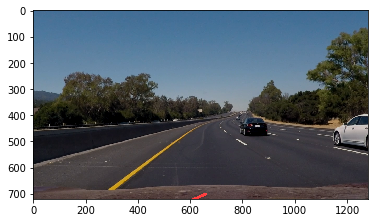

In [108]:
avg_pos_slope = 0
avg_neg_slope = 0
nFrames = 0
challenge_output = 'test_videos/modified_challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,2)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [197]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))